#### Summary: 
Here I'll revisit the HiChIP overlap enrichment comparisons between links methods. It's been over a year since I first worked on this and now I want to redo everything in a clean notebook and double check all my methods for mistakes. Additionally, now that we're using all links methods, we may be able to include these overlaps in the paper, even though they don't show SMORES as the best method. These analyses are done on sets of links binned by distances, as well as sets of significant links found by multiple methods. 

- Significant sets: all links within distance bins, subsampled down to match size of background set if larger
- Background sets: all links within same distance bins, subsampled down to match size of significant set if larger
- After everything removes thresholded files to save space

# 1. Basic Preparation

In [1]:
# Import necessary libraries
suppressMessages(library(tidyverse))
suppressMessages(library(stringr))
suppressMessages(library(data.table))
suppressMessages(library(grid))

suppressMessages(library(tictoc))
suppressMessages(library(UpSetR))
suppressMessages(library(cicero))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))

suppressMessages(library(parallel))

In [2]:
# Define celltypes list
celltypes <- c('beta','alpha','delta','gamma','ductal','acinar')

# Define colors for each celltype (same order as celltypes)
colors <- c('#3F98E0', '#F51646', '#E39E14', '#A1D99B', '#09850B', '#F5DE6C')

In [3]:
# Define names and colors for link methods
link_methods <- c('SMORES', 'ABC', 'Cicero')
link_colors <- c('#E151A7', '#1D8BDF', '#DEBE1D')
names(link_colors) <- link_methods

# Define overlap sets and colors
link_sets <- c('hm_abc_cic', 'hm_abc', 'hm_cic', 'abc_cic', 'hm', 'abc', 'cic')
overlap_colors <- c('#000000', #All 3 links (black)
                    '#7F6EC3', #HM + ABC (orange)                    
                    '#E08862', #HM + Cicero (purple)
                    '#7EA57E', #ABC + Cicero (green)
                    '#E151A7', #HM (pink)
                    '#1D8BDF', #ABC (blue)
                    '#DEBE1D') #Cicero (yellow)
names(overlap_colors) <- link_sets

In [4]:
distance_bins <- c('250000-1000000', '100000-250000', '50000-100000', '10000-50000', '0-10000')

In [5]:
# disable scientific notation for the filepath names of larger distances
options(scipen = 999)
set.seed(8)

### Important file paths

In [6]:
#significant links are in one file now
# sig links (w header) = links_dir + celltype + links_suffix
links_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/cRE-gene_links/method_overlaps/231211_links_summary'
links_suffix <- '_all_methods_links.wHeader.bedpe'

In [7]:
#background links are in different places 
# SMORES links (CP cut) = hm_prefix + celltype + hm_suffix
hm_prefix <- '/nfs/lab/hmummey/multiomic_islet/intermediates/230228_SMORES_PP_investigation/less_cols/'
hm_suffix <- '_all_CP_links.bedpe'

# ABC background files = abc_bg_dir + celltype + abc_bg_suffix
abc_bg_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/run_abc/reprocessed_outputs/230110_allCTs/nonsig_links/'
abc_bg_suffix <- '_nonsig_mapped_links.bedpe'

# Cicero background files = cic_bg_dir + celltype + cic_bg_suffix
cic_bg_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/cRE-gene_links/cicero/230111_final_map/reprocessed_all_links/'
cic_bg_suffix <- '_links.final_filt.bedpe'

In [8]:
# HiChIP files
#made versions of these files without the headers
hichip_dir    <-'/nfs/lab/hmummey/multiomic_islet/intermediates/221017_recluster_final_cRE-gene_links/hichip'

endoc_fp      <- file.path(hichip_dir,'endoc_untreated_merged.loops.bedpe')
islet_high_fp <- file.path(hichip_dir,'Human_Islets_High_S11_L004.5k.1.sig3Dinteractions.bedpe')
islet_low_fp  <- file.path(hichip_dir, 'Human_Islets_Low_S12_L004.5k.1.sig3Dinteractions.bedpe')

hichip_fps <- c(endoc_fp, islet_high_fp, islet_low_fp)
prefixes   <- c('endob', 'islet_high_glucose', 'islet_low_glucose')
names(hichip_fps) <- prefixes

In [9]:
#outdir <- '/nfs/lab/hmummey/multiomic_islet/intermediates/230406_distance_thresholded_enrichment_bins_sigperm/230412_alt_distance_bins2'
outdir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/cRE-gene_links/HiChIP_overlaps'

### Define necessary reference files

In [10]:
# read in the gene coords ref file
ref_df <- read.table('/nfs/lab/ABC/references/gene_coords.gencodev32.hg38.bed', sep='\t', header=FALSE) #read in gene coords ref

# 2. Calculate HiChIP overlap of links thresholded by distance (separate method sets)

## 2a. Threshold link sets by distances, output as bedpe files

In [11]:
#this was already done in the eQTL notebook and I don't want to make more big files, so will just use those files!
eqtl_outdir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/cRE-gene_links/eQTL_overlaps'
dist_indir <- file.path(eqtl_outdir, 'cut_links')

## 2b. Perform HiChIP overlaps

In [12]:
### Extra function to perform overlaps, so I can parallelize (also cuts links down randomly)
run_compare_connections <- function(N, links, num_links, hichip, max_bp=1000){
    # Randomly cut down links as necessary
    fin_links <- links[sample(dim(links)[1], num_links),]
    
    # Make links sets
    links <- data.frame(Peak1 = paste(fin_links[,1], fin_links[,2], fin_links[,3], sep="_"),
                        Peak2 = paste(fin_links[,4], fin_links[,5], fin_links[,6], sep="_"))
    hichip_links <- data.frame(Peak1 = paste(hichip[,1], hichip[,2], hichip[,3], sep="_"),
                               Peak2 = paste(hichip[,4], hichip[,5], hichip[,6], sep="_"))
    
    # Overlap using cicero compare_connections and return summary of overlaps
    inn = compare_connections(links, hichip_links, maxgap=max_bp)
    return(sum(inn))
}

In [13]:
### Use Cicero's compare_connections() function to find overlap between method links and HiChIP links
### This assumes none of the link files have headers
wrapper1_run_compare_connections <- function(signif_links_fp, all_links, hichip_fp, N=100, max_bp=1000){
    # Read in files, noting if they have a header or not -- will pass all_links file so read in less
    signif_links <- read.table(signif_links_fp, sep='\t', header=FALSE)
    hichip <- read.table(hichip_fp, sep='\t', header=FALSE)

    # Remove any significant links from the background (some bg files have them still)
    signif_links$link <- paste(paste(signif_links[,1], signif_links[,2], signif_links[,3], sep="-"),
                               paste(signif_links[,4], signif_links[,5], signif_links[,6], sep="-"), sep='_')
    all_links$link <- paste(paste(all_links[,1], all_links[,2], all_links[,3], sep="-"),
                            paste(all_links[,4], all_links[,5], all_links[,6], sep="-"), sep='_')
    all_links_cut <- all_links[!all_links$link %in% signif_links$link,]
    
    # If # bg links is > # sig links, will subsample and calculate overlap many times
    if (dim(all_links_cut)[1] > dim(signif_links)[1]){
        bg_overlaps <- unlist(mclapply(seq(1,N), run_compare_connections, all_links_cut, dim(signif_links)[1], hichip, mc.cores=10))
        bg_overlap <- round(mean(bg_overlaps))
        sig_overlap <- run_compare_connections(1, signif_links, dim(signif_links)[1], hichip)
        num_links <- dim(signif_links)[1]
    # Otherwise permute subsampling for the significant links set
    } else {
        print(paste('Less background links than significant!', signif_links_fp))
        bg_overlap <- run_compare_connections(1, all_links_cut, dim(all_links_cut)[1], hichip)
        sig_overlaps <- unlist(mclapply(seq(1,N), run_compare_connections, signif_links, dim(all_links_cut)[1], hichip, mc.cores=10))
        sig_overlap <- round(mean(sig_overlaps))
        num_links <- dim(all_links_cut)[1]
    }   

    # Compile all the data for output
    outlist <- c(num_links, sig_overlap, sig_overlap/num_links, 
                num_links, bg_overlap, bg_overlap/num_links)
    return(outlist)
}

In [14]:
### Even higher level wrapper for comparing HiChIP overlaps LOL
wrapper2_run_compare_connections <- function(celltype, indir, outdir, link_methods, distance_bins, hichip_fp, hichip_prefix){
    # set up dirs where we'll find the links
    ct_indir1 <- file.path(indir,paste0(celltype,'_bg'))
    ct_indir2 <- file.path(indir,paste0(celltype,'_sig')) 
    
    overlap_df <- data.frame()
    # For each method go through the distance thresholded links and calculate overlap with HiChIP
    for (method in link_methods){
        for (dist in distance_bins){
            bg_fp <- file.path(ct_indir1,sprintf('%s_links_dist_bin_%s.bedpe',method, as.character(dist)))
            bg_links <- read.table(bg_fp, sep='\t', header=FALSE)
            sig_fp <- file.path(ct_indir2,sprintf('%s_links_dist_bin_%s.bedpe',method, as.character(dist)))                                
            results <- wrapper1_run_compare_connections(sig_fp, bg_links, hichip_fp)
            overlap_df <- rbind(overlap_df, results)
        }
    }

    # Final modifications to the dataframe, then write out
    rownames(overlap_df) <- paste(rep(link_methods, each=length(distance_bins)), distance_bins, sep='_')
    colnames(overlap_df) <- c('signif_links','signif_links_overlap_HiChIP','percent_signif',
                              'nonsignif_links','nonsignif_links_overlap_HiChIP','percent_nonsignif')
    out_fp <- file.path(outdir, sprintf('%s_%s_HiChIP_overlap.link_methods_dist_bin_comp.txt', celltype, hichip_prefix))
    write.table(overlap_df, out_fp, sep='\t', row.names = TRUE, col.names = TRUE, quote=FALSE)
    return(overlap_df)
}

### Run functions

In [15]:
fin_outdir <- file.path(outdir, 'dist_outputs')
dir.create(fin_outdir, showWarnings=FALSE)

In [16]:
# run the celltype comparison function 

tic()
for (prefix in names(hichip_fps)){
    hichip_fp <- hichip_fps[[prefix]]
    print(hichip_fp)
    for (celltype in celltypes){
        print(paste(celltype, Sys.time()))
        test <- wrapper2_run_compare_connections(celltype, dist_indir, fin_outdir, link_methods, distance_bins, hichip_fp, prefix)
    }
}
toc()

[1] "/nfs/lab/hmummey/multiomic_islet/intermediates/221017_recluster_final_cRE-gene_links/hichip/endoc_untreated_merged.loops.bedpe"
[1] "beta 2024-04-22 14:51:54"
[1] "Less background links than significant! /nfs/lab/projects/multiomic_islet/outputs/multiome/cRE-gene_links/eQTL_overlaps/cut_links/beta_sig/ABC_links_dist_bin_0-10000.bedpe"
[1] "alpha 2024-04-22 14:59:06"
[1] "Less background links than significant! /nfs/lab/projects/multiomic_islet/outputs/multiome/cRE-gene_links/eQTL_overlaps/cut_links/alpha_sig/ABC_links_dist_bin_0-10000.bedpe"
[1] "delta 2024-04-22 15:07:49"
[1] "Less background links than significant! /nfs/lab/projects/multiomic_islet/outputs/multiome/cRE-gene_links/eQTL_overlaps/cut_links/delta_sig/ABC_links_dist_bin_0-10000.bedpe"
[1] "gamma 2024-04-22 15:16:13"
[1] "Less background links than significant! /nfs/lab/projects/multiomic_islet/outputs/multiome/cRE-gene_links/eQTL_overlaps/cut_links/gamma_sig/ABC_links_dist_bin_0-10000.bedpe"
[1] "ductal 2024-04-22 15

## 2c. Calculate enrichment

### Functions

In [17]:
### Basic function to run Fisher's exact test for enrichment using an input data.table (2 x 2)
### Returns vector of (CI left side, odds ratio, CI right side)
test_hichip_enrichment <- function(df_row){
    # Set up data table (2 x 2) for test
    data <- data.frame('links_match'=c(as.numeric(df_row[['signif_links_overlap_HiChIP']]), as.numeric(df_row[['nonsignif_links_overlap_HiChIP']])),
                        'total_links'=as.numeric(c(df_row[['signif_links']]), as.numeric(df_row[['nonsignif_links']])),
                        row.names=c('signif_links','nonsignif_links'))
    data_fin <- as.matrix(data)
    test <- fisher.test(data_fin)
    vector <- c(test$conf.int[1], test$estimate, test$conf.int[2], test$p.value)
    return(vector)
}


### Function to read in 3 method compare connections output files and run Fisher's exact test for enrichment
### for a given celltype, then create a Forest plot comparing the odds ratio and CIs
calculate_hichip_eqtl_enrichment <- function(fp, outdir, celltype, hichip_prefix){
    # Read in HiChIP overlap dataframe (it's celltype specific, already has all methods)
    df <- read.table(fp, sep='\t', row.names=1, header=TRUE)
    df$method <- str_split_fixed(row.names(df),'_',2)[,1]
    df$dist_bin <- str_split_fixed(row.names(df),'_',2)[,2]
    df$id <- row.names(df)
    rownames(df) <- seq(1, dim(df)[1])
    
    # Run Fisher's exact test for each row in each df_fin
    tests <- apply(df, 1, test_hichip_enrichment)
    test_results <- as.data.frame(t(tests))
    colnames(test_results) <- c('CI_L','odds_ratio','CI_R','pval')
    
    # Add in other information
    test_results$method <- df$method
    test_results$dist_bin <- df$dist_bin
    test_results$id <- df$id
    
    # Write this out to a file!
    out_fp <- file.path(outdir, sprintf('%s_%s_HiChIP_overlap.link_methods_dist_bin_comp.Fishers_enrichment.txt',celltype, hichip_prefix))
    write.table(test_results, out_fp, sep='\t', col.names=TRUE, row.names=FALSE, quote=FALSE)
}

### Use functions to calculate enrichment

In [18]:
# Combine all dataframes of HiChIP enrichment results and run Fisher's Exact test
for (prefix in names(hichip_fps)){
    hichip_fp <- hichip_fps[[prefix]]
    for (celltype in celltypes){
        fp <- file.path(fin_outdir, sprintf('%s_%s_HiChIP_overlap.link_methods_dist_bin_comp.txt', celltype, prefix))
        calculate_hichip_eqtl_enrichment(fp, fin_outdir, celltype, prefix)
    }
}

## 2d. Make plots! -- these are just for visualization, I'll make final version in a Figure making notebook

In [19]:
### dedicated plotting function
plot_enrichment_comp_fin <- function(fp, distance_bins, xmax, methods, colors, title){
    # Read in table of Fisher's exact test odd's ratios and CIs
    data <- read.table(fp, sep='\t', header = TRUE)
    row.names(data) <- data$id
    
    # Cut down to desired celltype/s and method/s and add in color info!
    data_cut <- subset(data, method %in% methods & dist_bin %in% distance_bins)
    data_cut$color <- colors[data_cut$id] 
    
    # Sort data_cut by celltype (use to refactor later on)
    data_cut_sort <- data_cut[order(data_cut$method, data_cut$dist_bin),]
    
    # Set any values outside of xmax to the limits (also record which values exceed the limits)
    past_xmax <- row.names(data_cut_sort[data_cut_sort$CI_R > xmax,])
    data_cut_sort[past_xmax, 'CI_R'] <- xmax
    or_past_xmax <- row.names(data_cut_sort[data_cut_sort$odds_ratio > xmax,])
    
    # Prepare input vectors for arrows 
    data_cut_sort$max_arrow_L <- NA 
    data_cut_sort[past_xmax, 'max_arrow_L'] <- data_cut_sort[past_xmax,'odds_ratio'] + 0.5
    data_cut_sort$max_arrow_R <- NA
    data_cut_sort[past_xmax, 'max_arrow_R'] <- xmax
    if (length(or_past_xmax) > 0){
        print(or_past_xmax)
        data_cut_sort[or_past_xmax, 'max_arrow_L'] <- NA
        data_cut_sort[or_past_xmax, 'max_arrow_R'] <- NA
    }
    
    # Prepare strings for y-labels (get rid of underscore in rownames)
    y_labels <- rev(gsub('_', ' ', data_cut_sort$id))
        
    # Make a forest plot with the subsetted data
    #print(data_cut_sort)
    options(repr.plot.width = 14, repr.plot.height = 12)
    theme_set(
        theme_classic())

    p1 <- ggplot(data=data_cut_sort, aes(x=odds_ratio, y=id, group=celltype, fill=color)) + 
            geom_vline(xintercept=seq(0, xmax, 1), linetype='dashed', color='black', alpha=0.5, size=0.5) + 
            geom_linerange(aes(xmin=CI_L, xmax=CI_R), size=0.75) + 
            geom_point(aes(x=odds_ratio), size=10, color=colors[data_cut_sort$id], group=celltype) + 
            scale_color_manual() + xlim(0,xmax) + 
            scale_y_discrete(labels=y_labels) + 
            xlab('Enrichment Odds Ratio (OR)') + ylab('Link set') + labs(title=title) + 
            theme(plot.title=element_text(size=20, hjust=0.5),
                  axis.text.x=element_text(size=20, vjust=0.5),
                  axis.text.y=element_text(size=20, vjust=0.5),
                  axis.title.x = element_text(size=20, vjust=-0.35),
                  axis.title.y = element_text(size=20, vjust=0.5),
                  legend.position = "none")
    p1$data$id <- factor(x = p1$data$id, levels=rev(data_cut_sort$id))
    if(length(past_xmax) > 0){
        p1 <- p1 + geom_segment(aes(x=max_arrow_L, xend=max_arrow_R, y=row.names(data_cut_sort), yend=row.names(data_cut_sort)),
                                lineend = 'butt', linejoin='mitre', size = 0.75, 
                                 arrow = arrow(length = unit(0.03, "npc")))
    }
    
    print(p1)
}

### Use functions to plot comparisons between methods and distances (by cell type) 

In [20]:
#make colors vector (method colors * number of distance bins)
num <- length(distance_bins)
method_colors <- c(rep(link_colors[['SMORES']],num), rep(link_colors[['ABC']],num), rep(link_colors[['Cicero']], num))
names(method_colors) <- paste(rep(link_methods, each=length(distance_bins)), distance_bins, sep='_')
#method_colors

[1] "ABC_250000-1000000"


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."
Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 14 rows containing missing values (`geom_segment()`)."


[1] "ABC_250000-1000000"


Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 15 rows containing missing values (`geom_segment()`)."


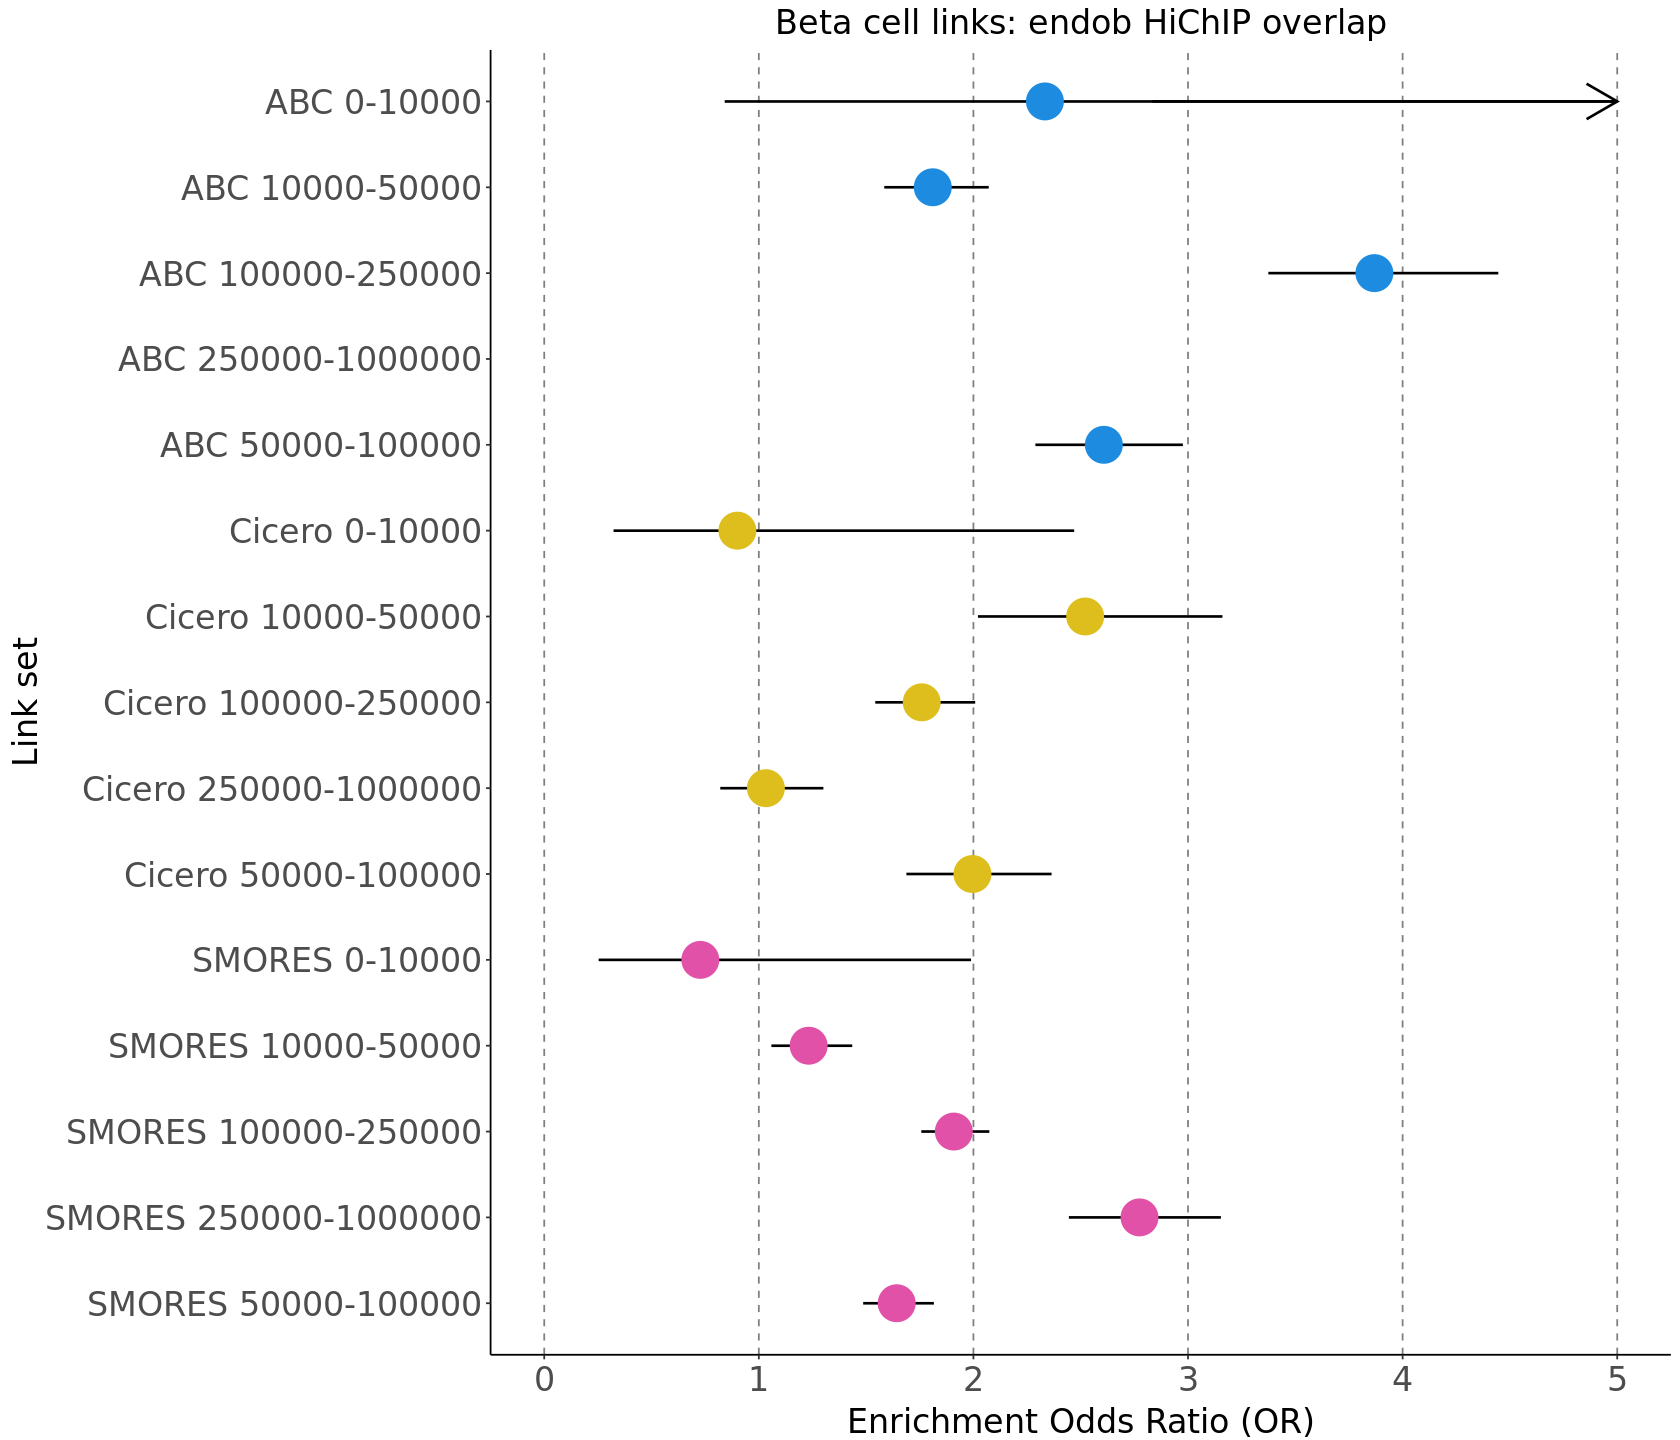

[1] "ABC_250000-1000000"


Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 14 rows containing missing values (`geom_segment()`)."


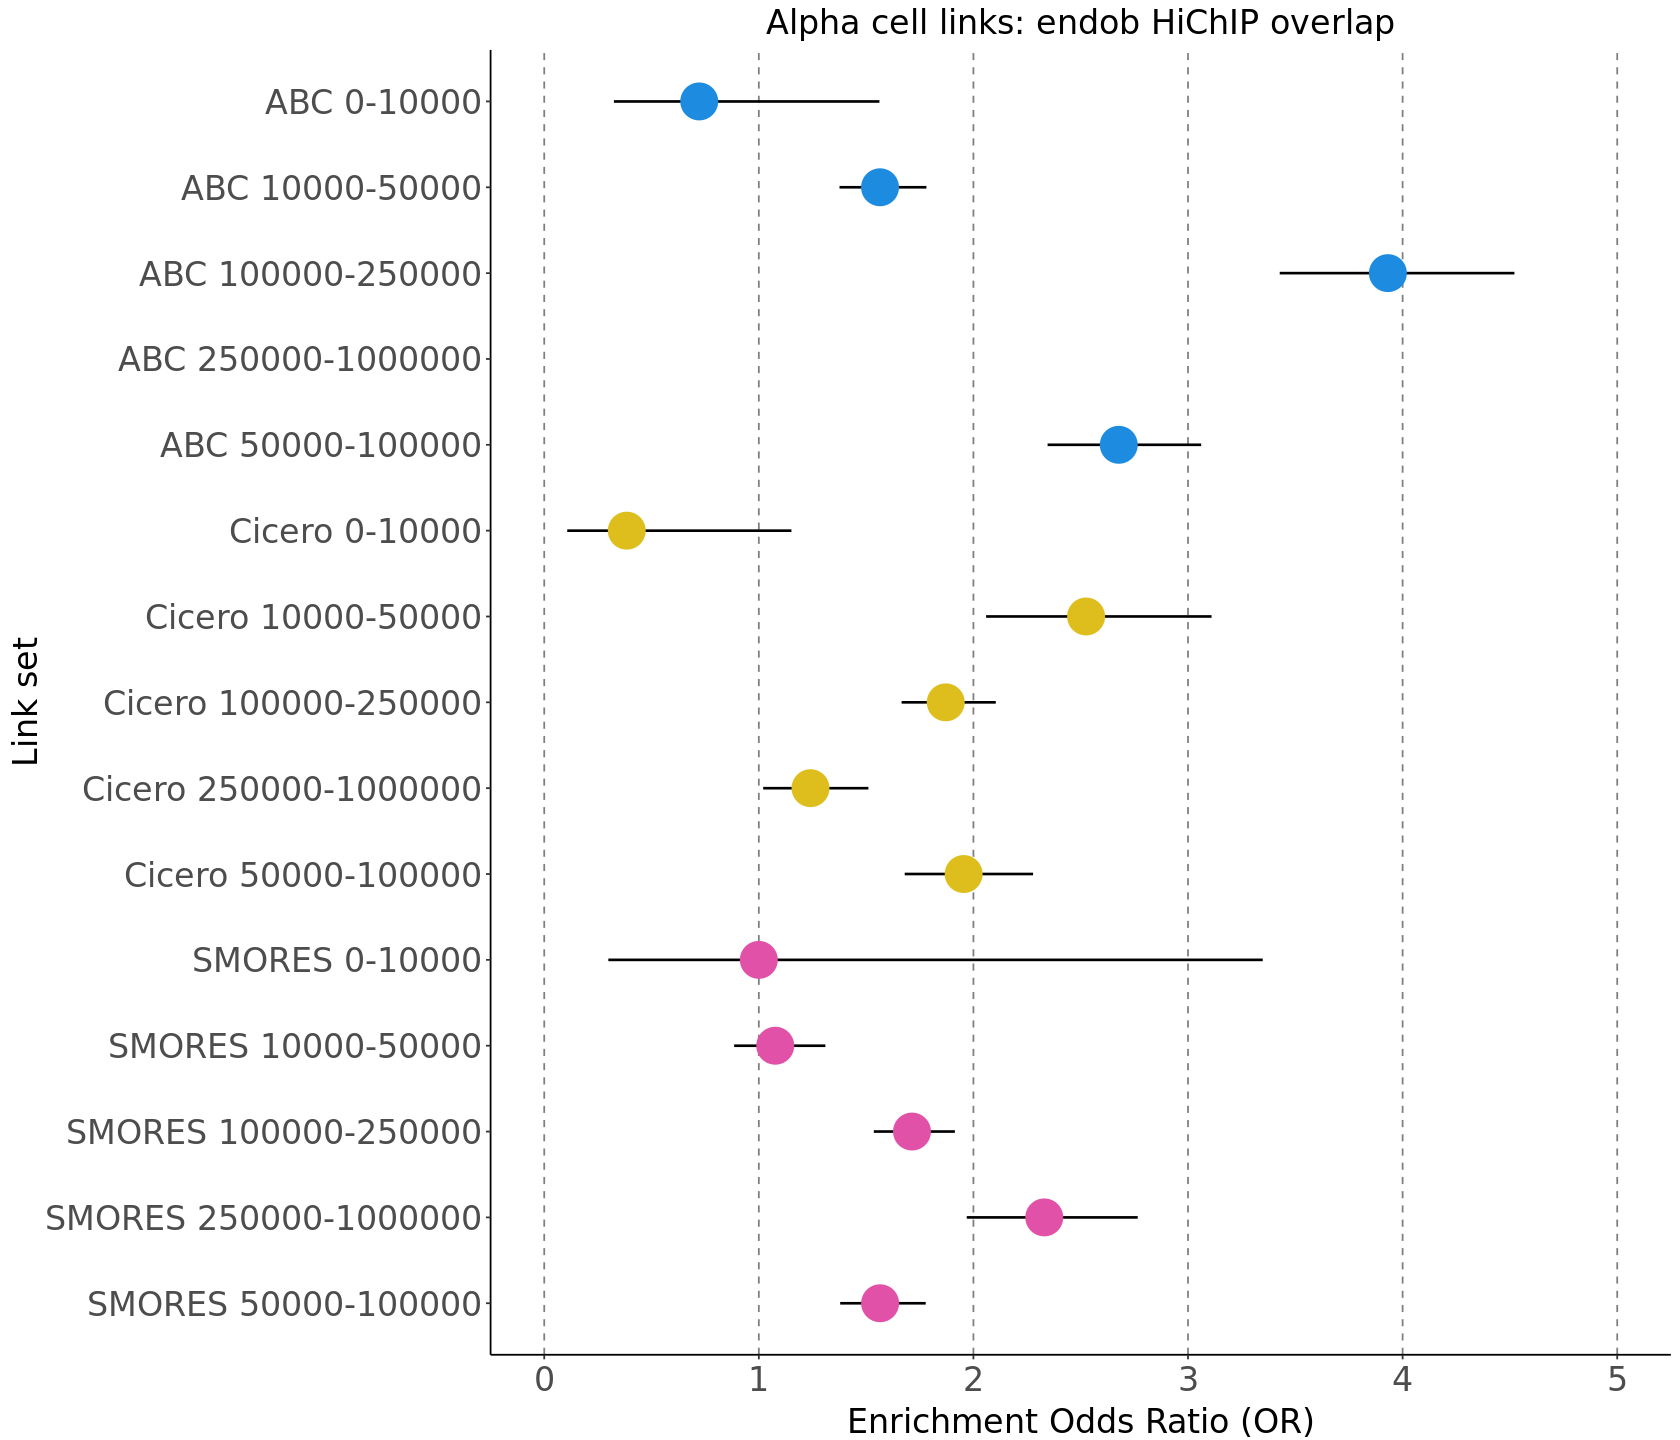

[1] "ABC_250000-1000000"


Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 14 rows containing missing values (`geom_segment()`)."


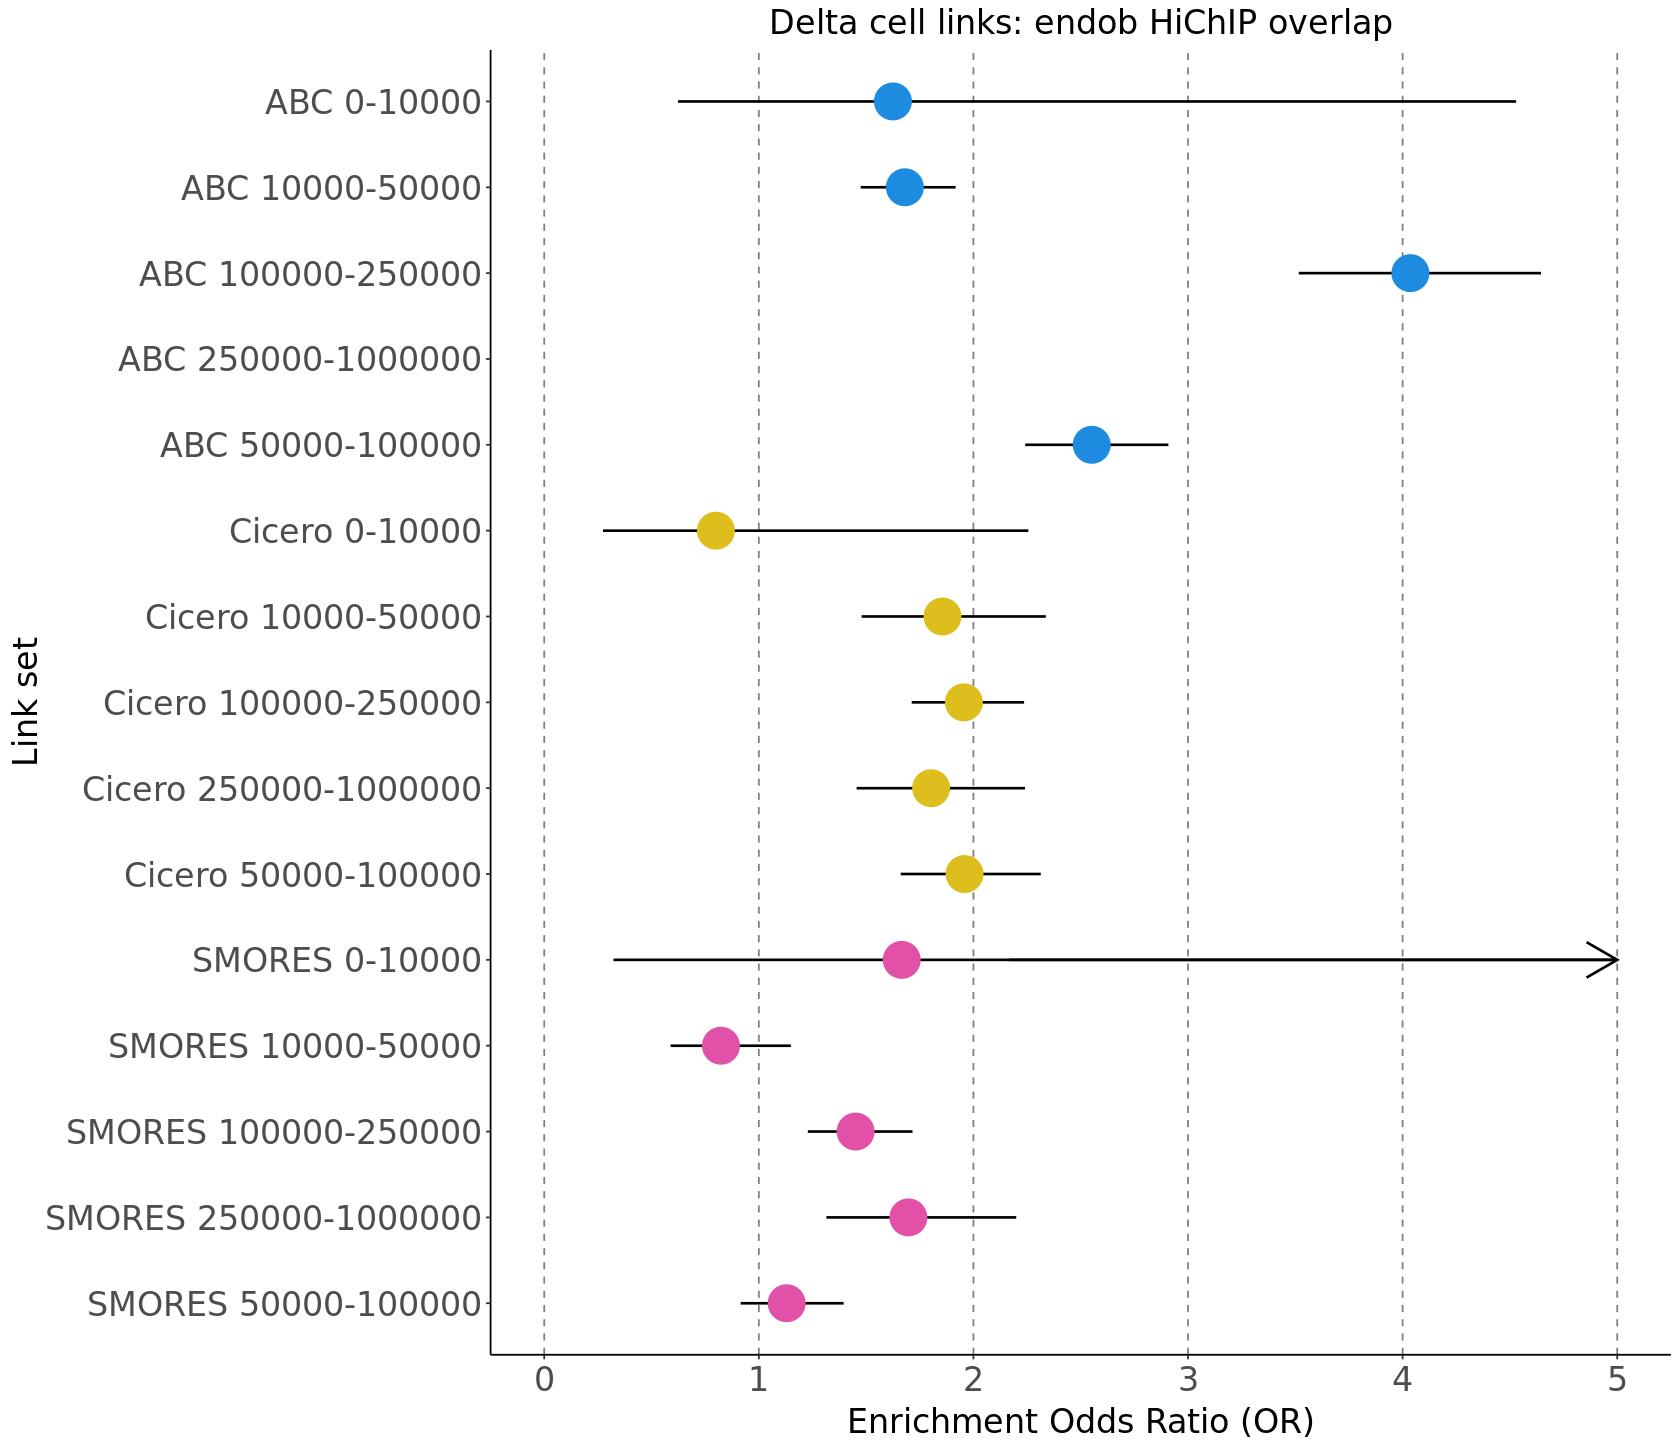

[1] "ABC_250000-1000000"


Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 15 rows containing missing values (`geom_segment()`)."


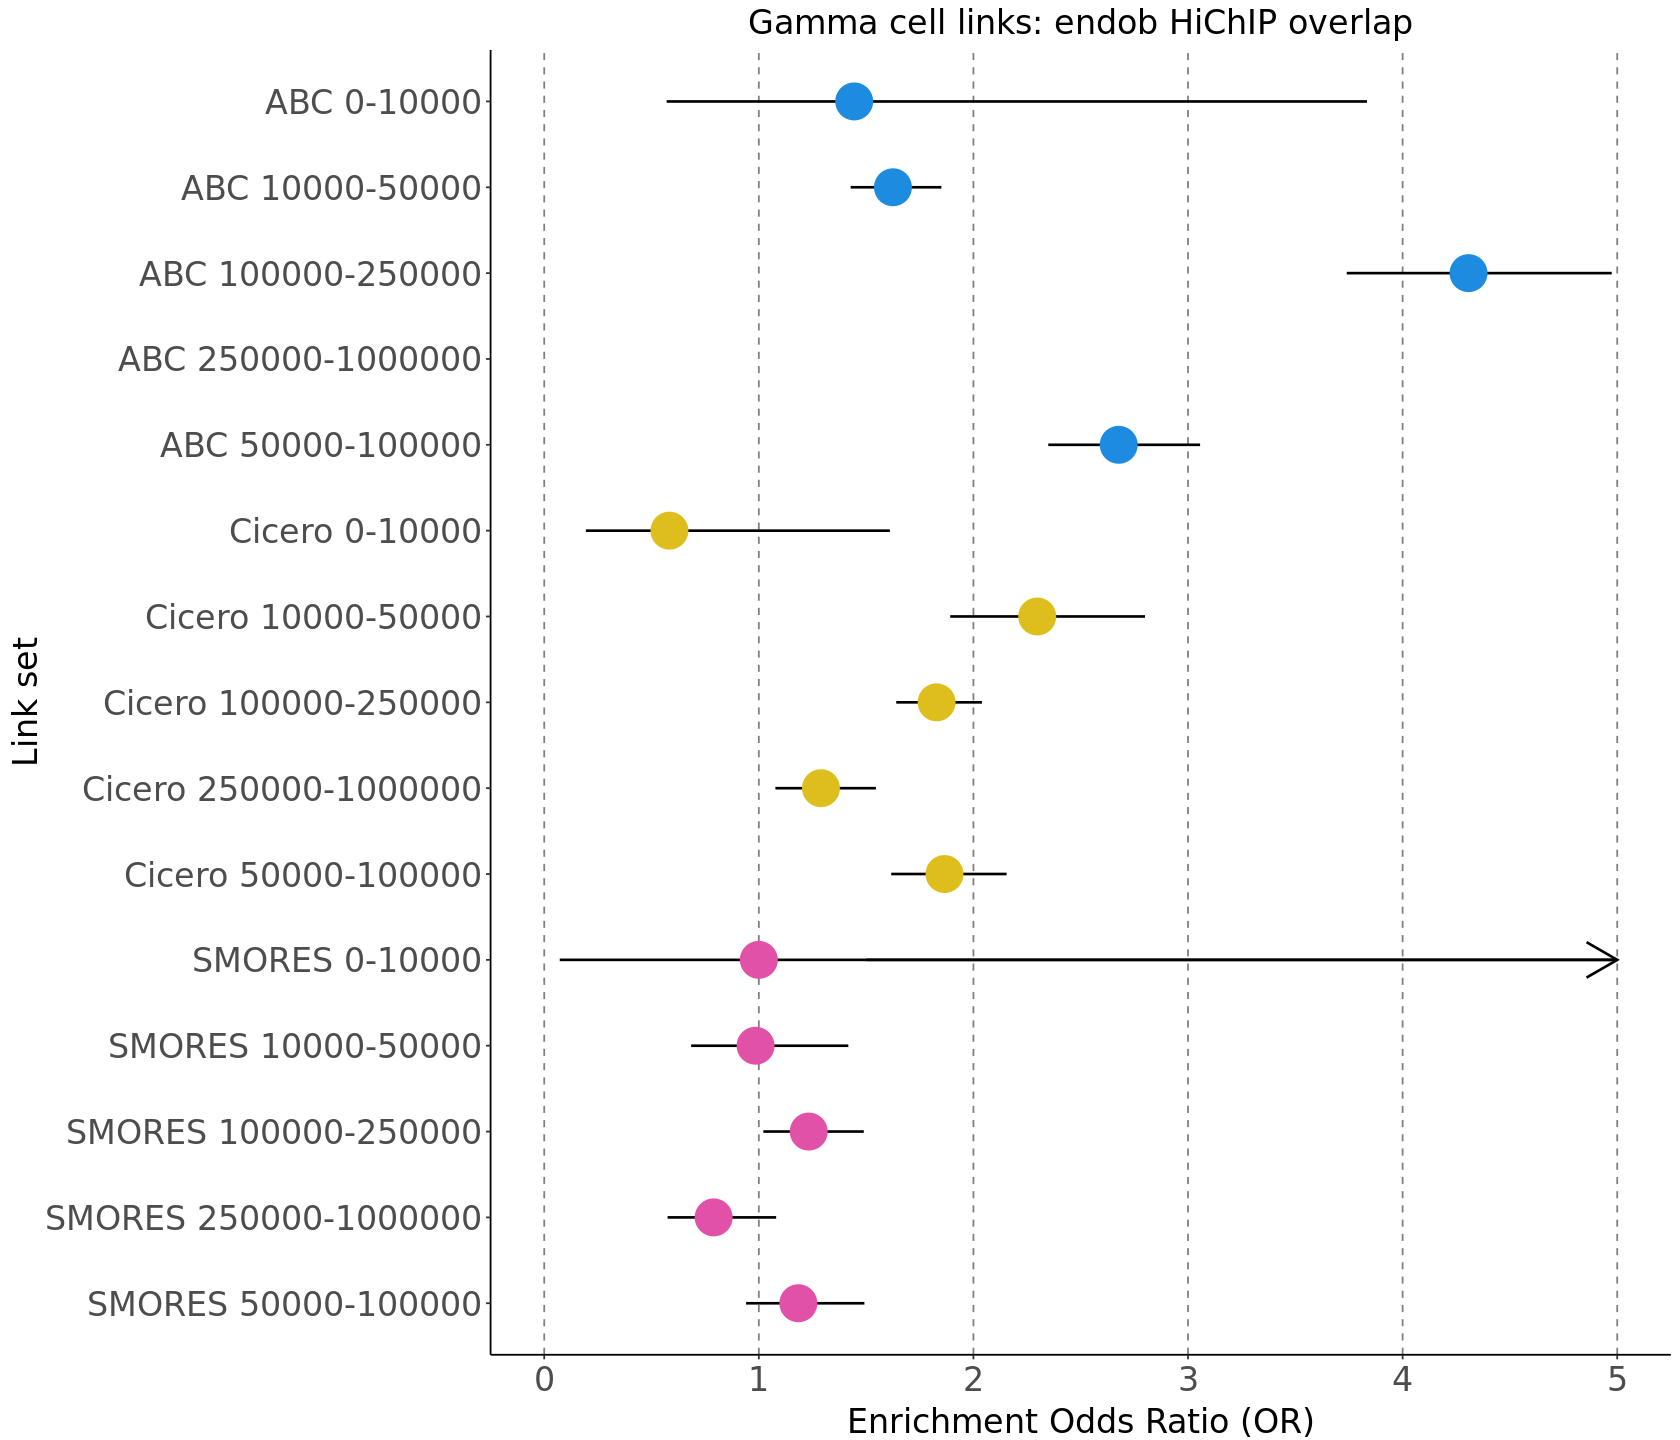

[1] "ABC_250000-1000000"


Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 14 rows containing missing values (`geom_segment()`)."


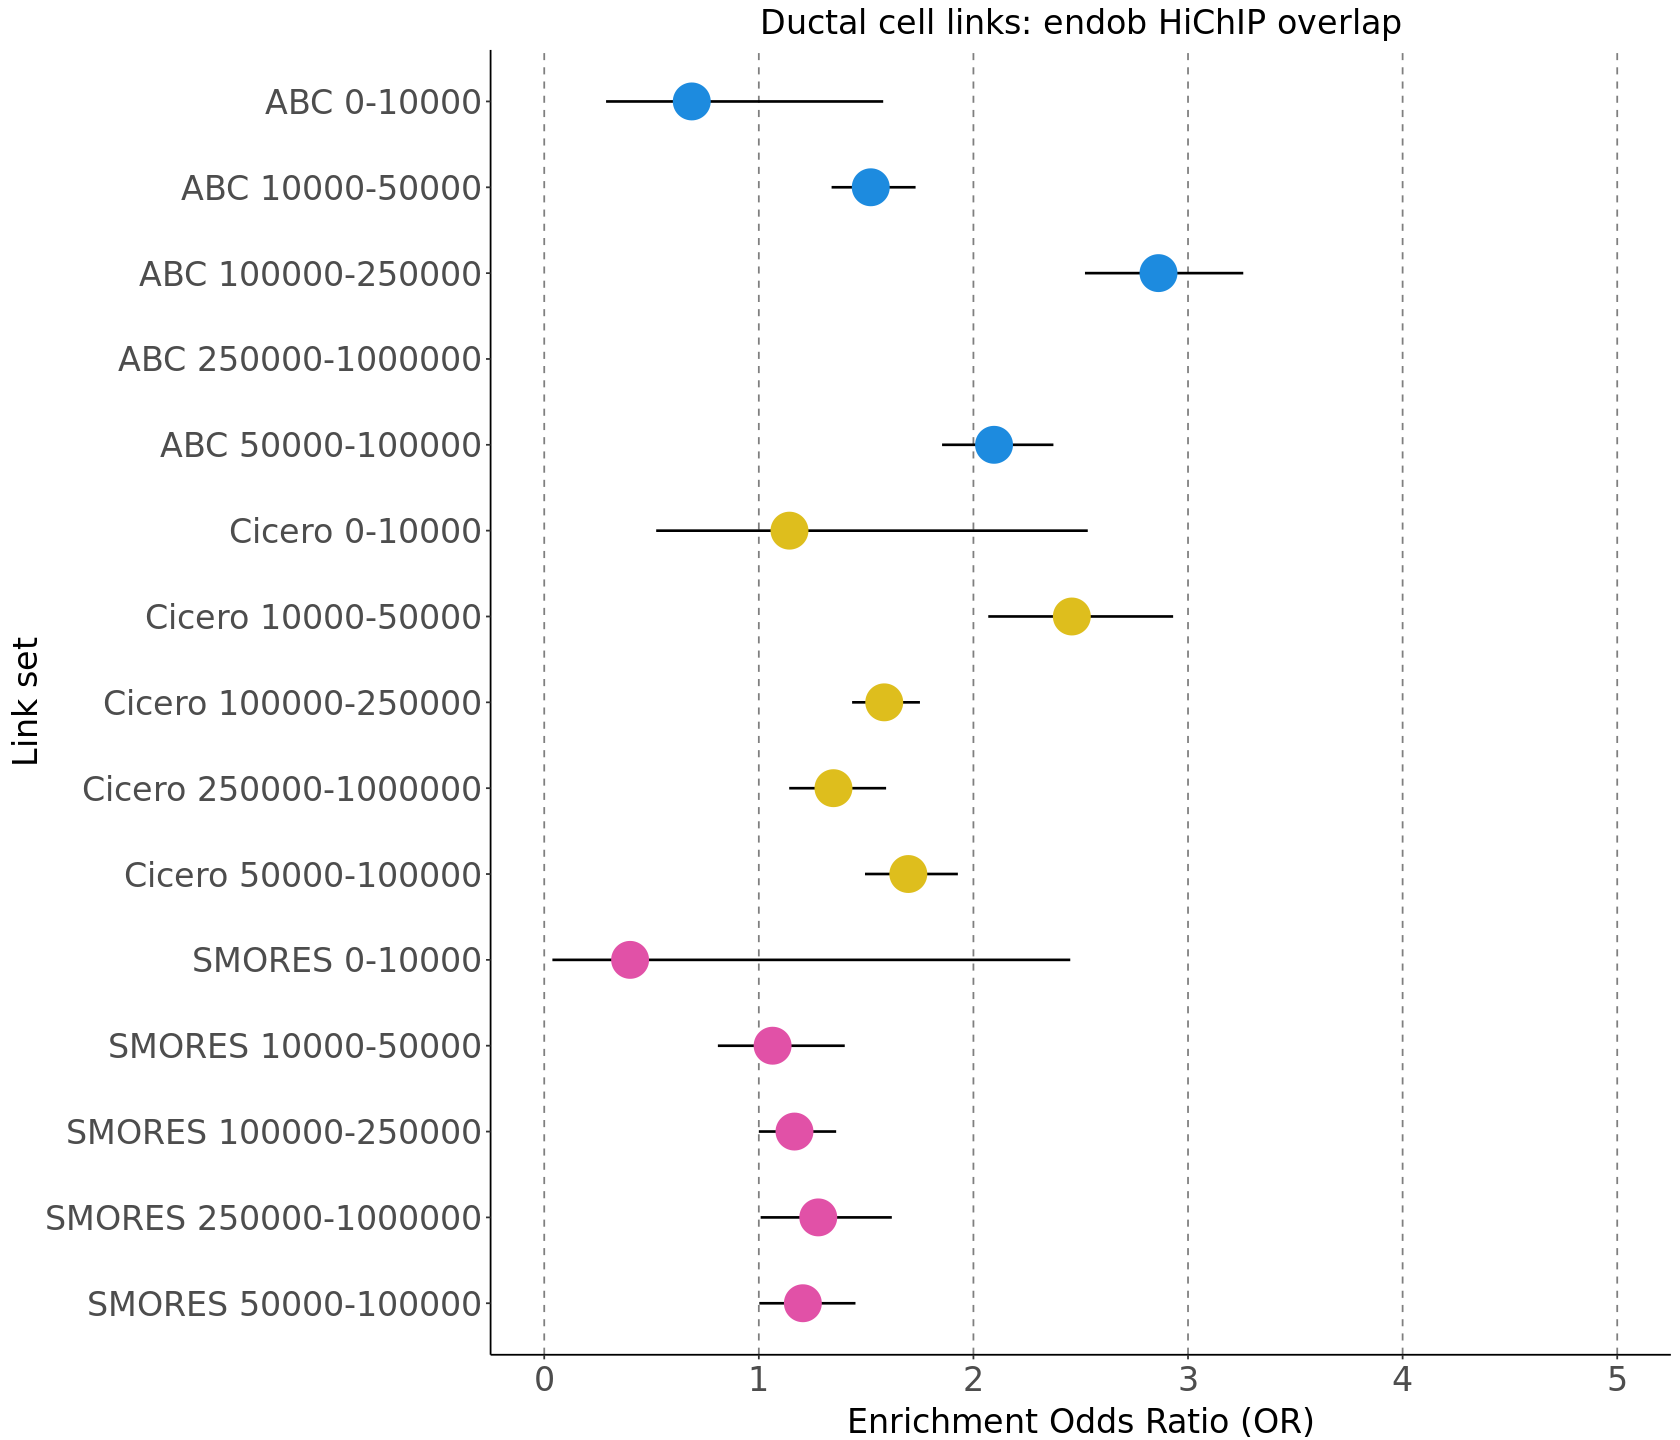

[1] "ABC_250000-1000000"


Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 14 rows containing missing values (`geom_segment()`)."


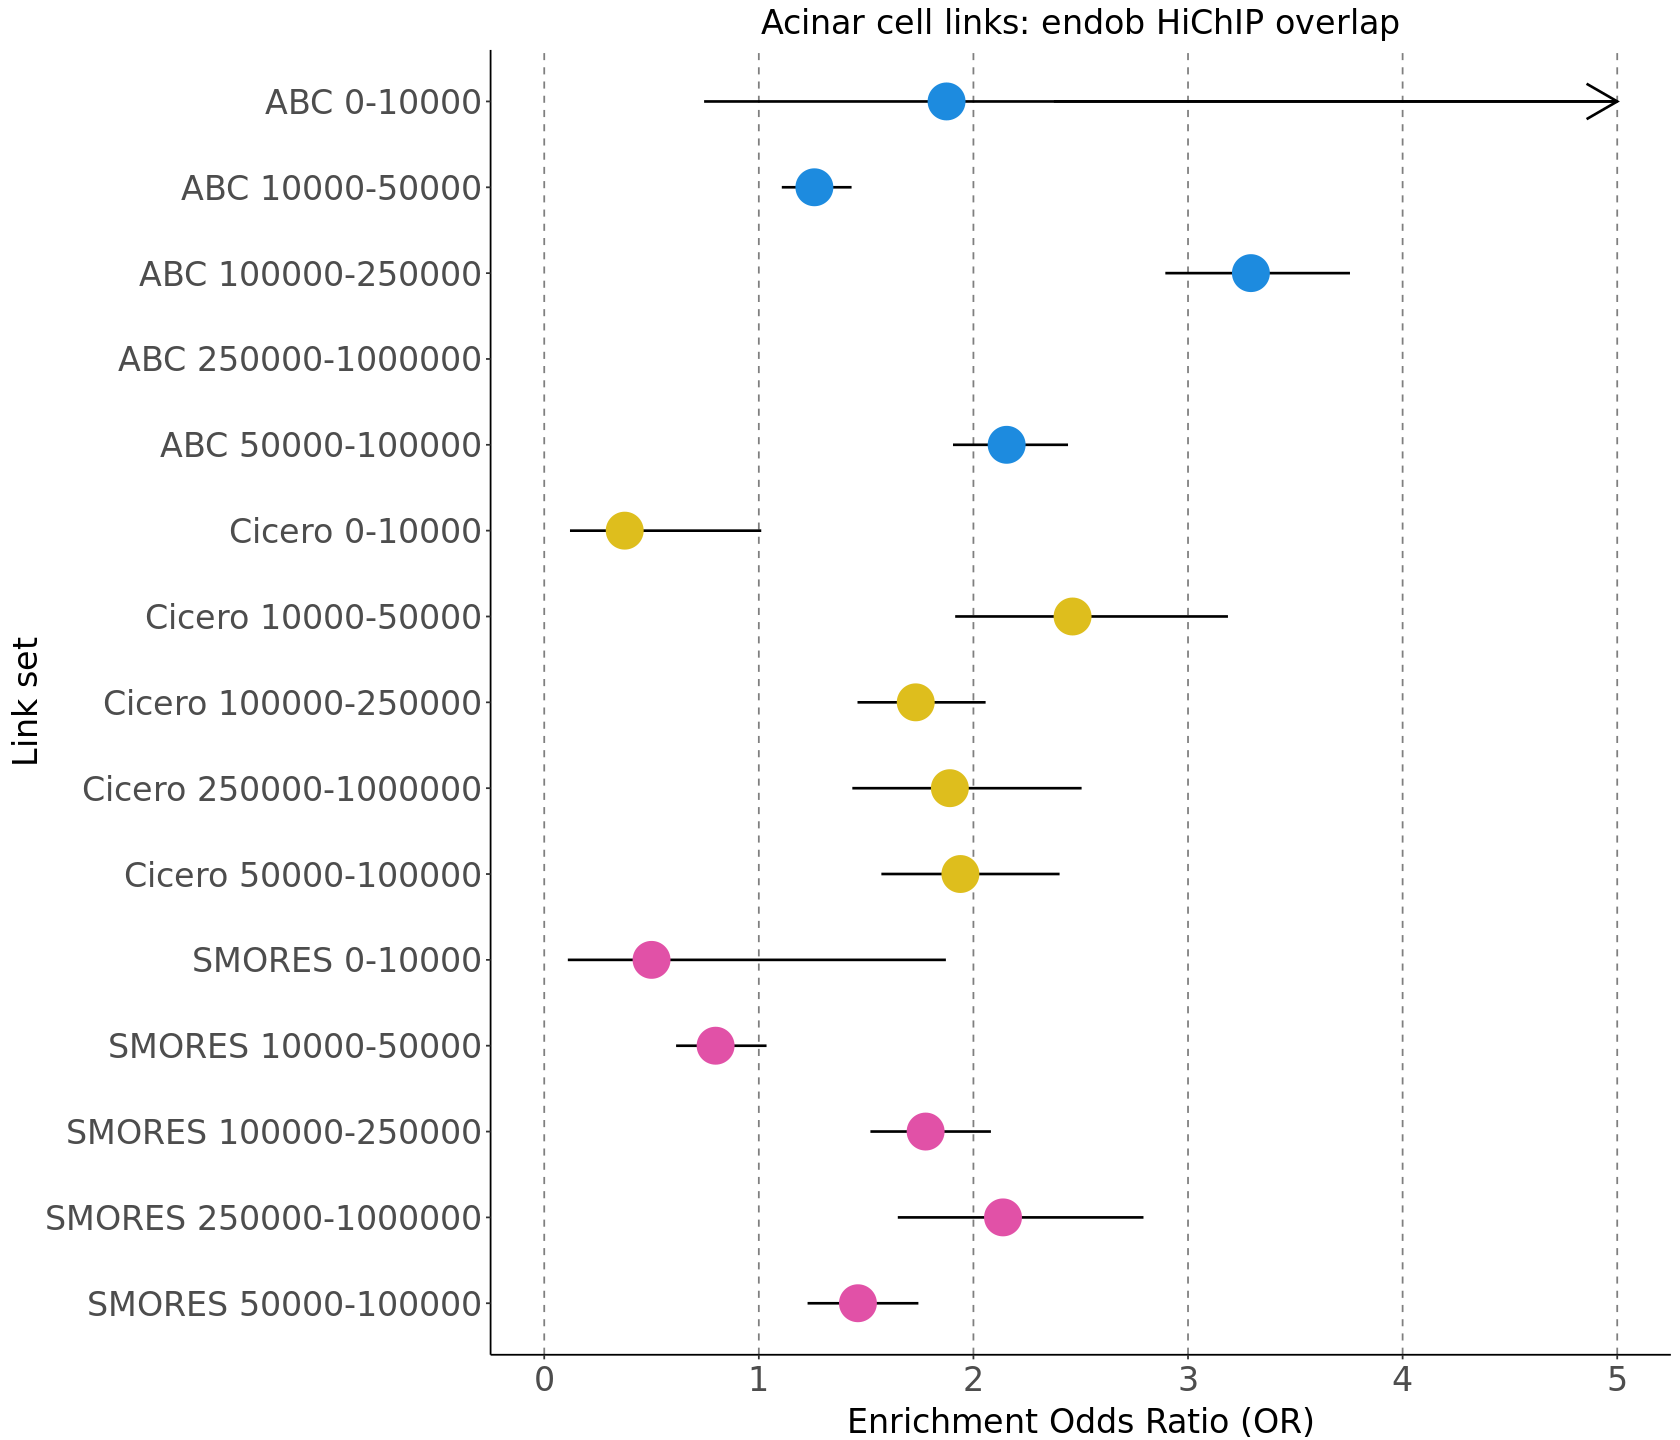

[1] "ABC_250000-1000000"


Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 15 rows containing missing values (`geom_segment()`)."


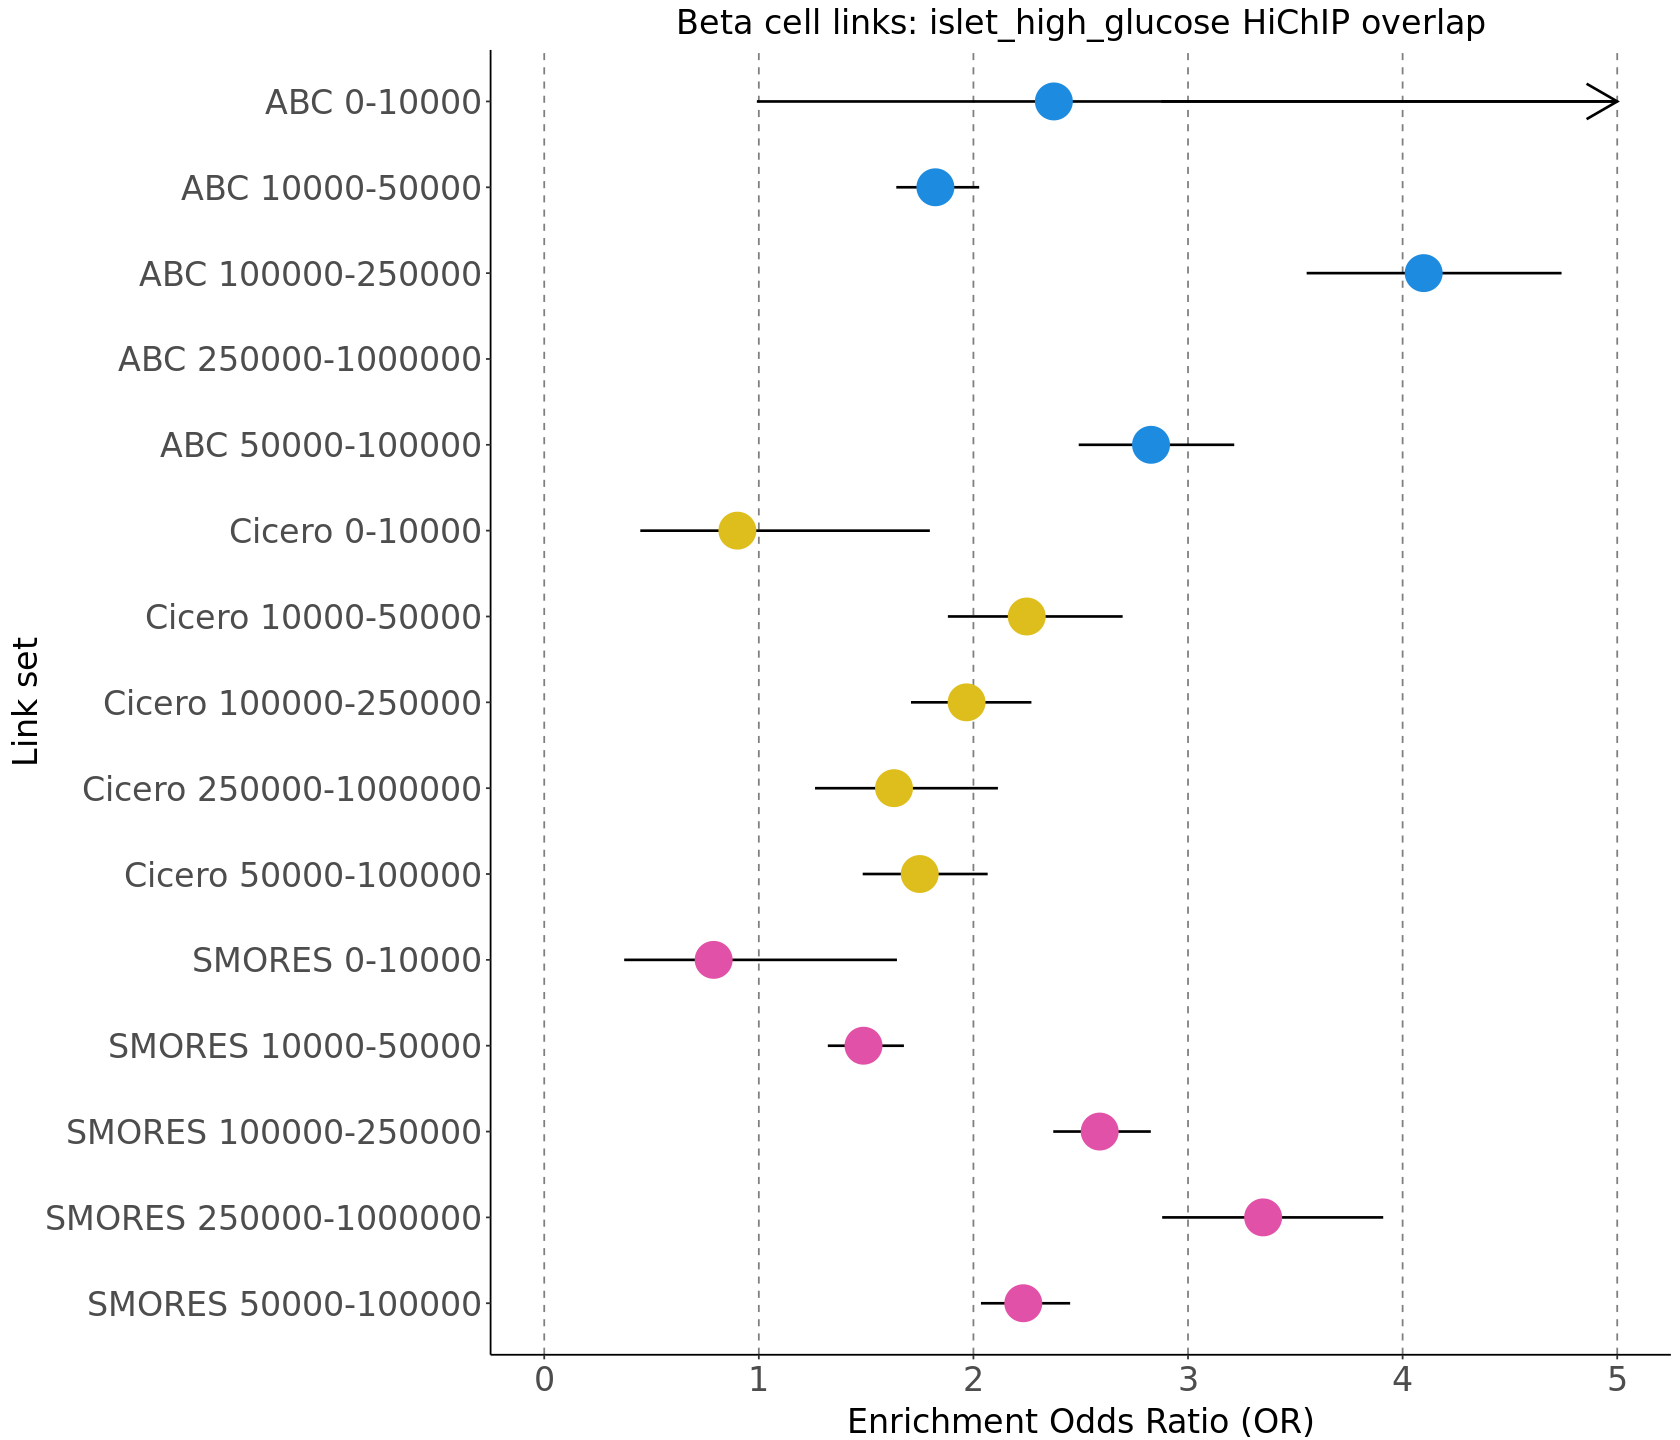

[1] "ABC_250000-1000000"


Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 14 rows containing missing values (`geom_segment()`)."


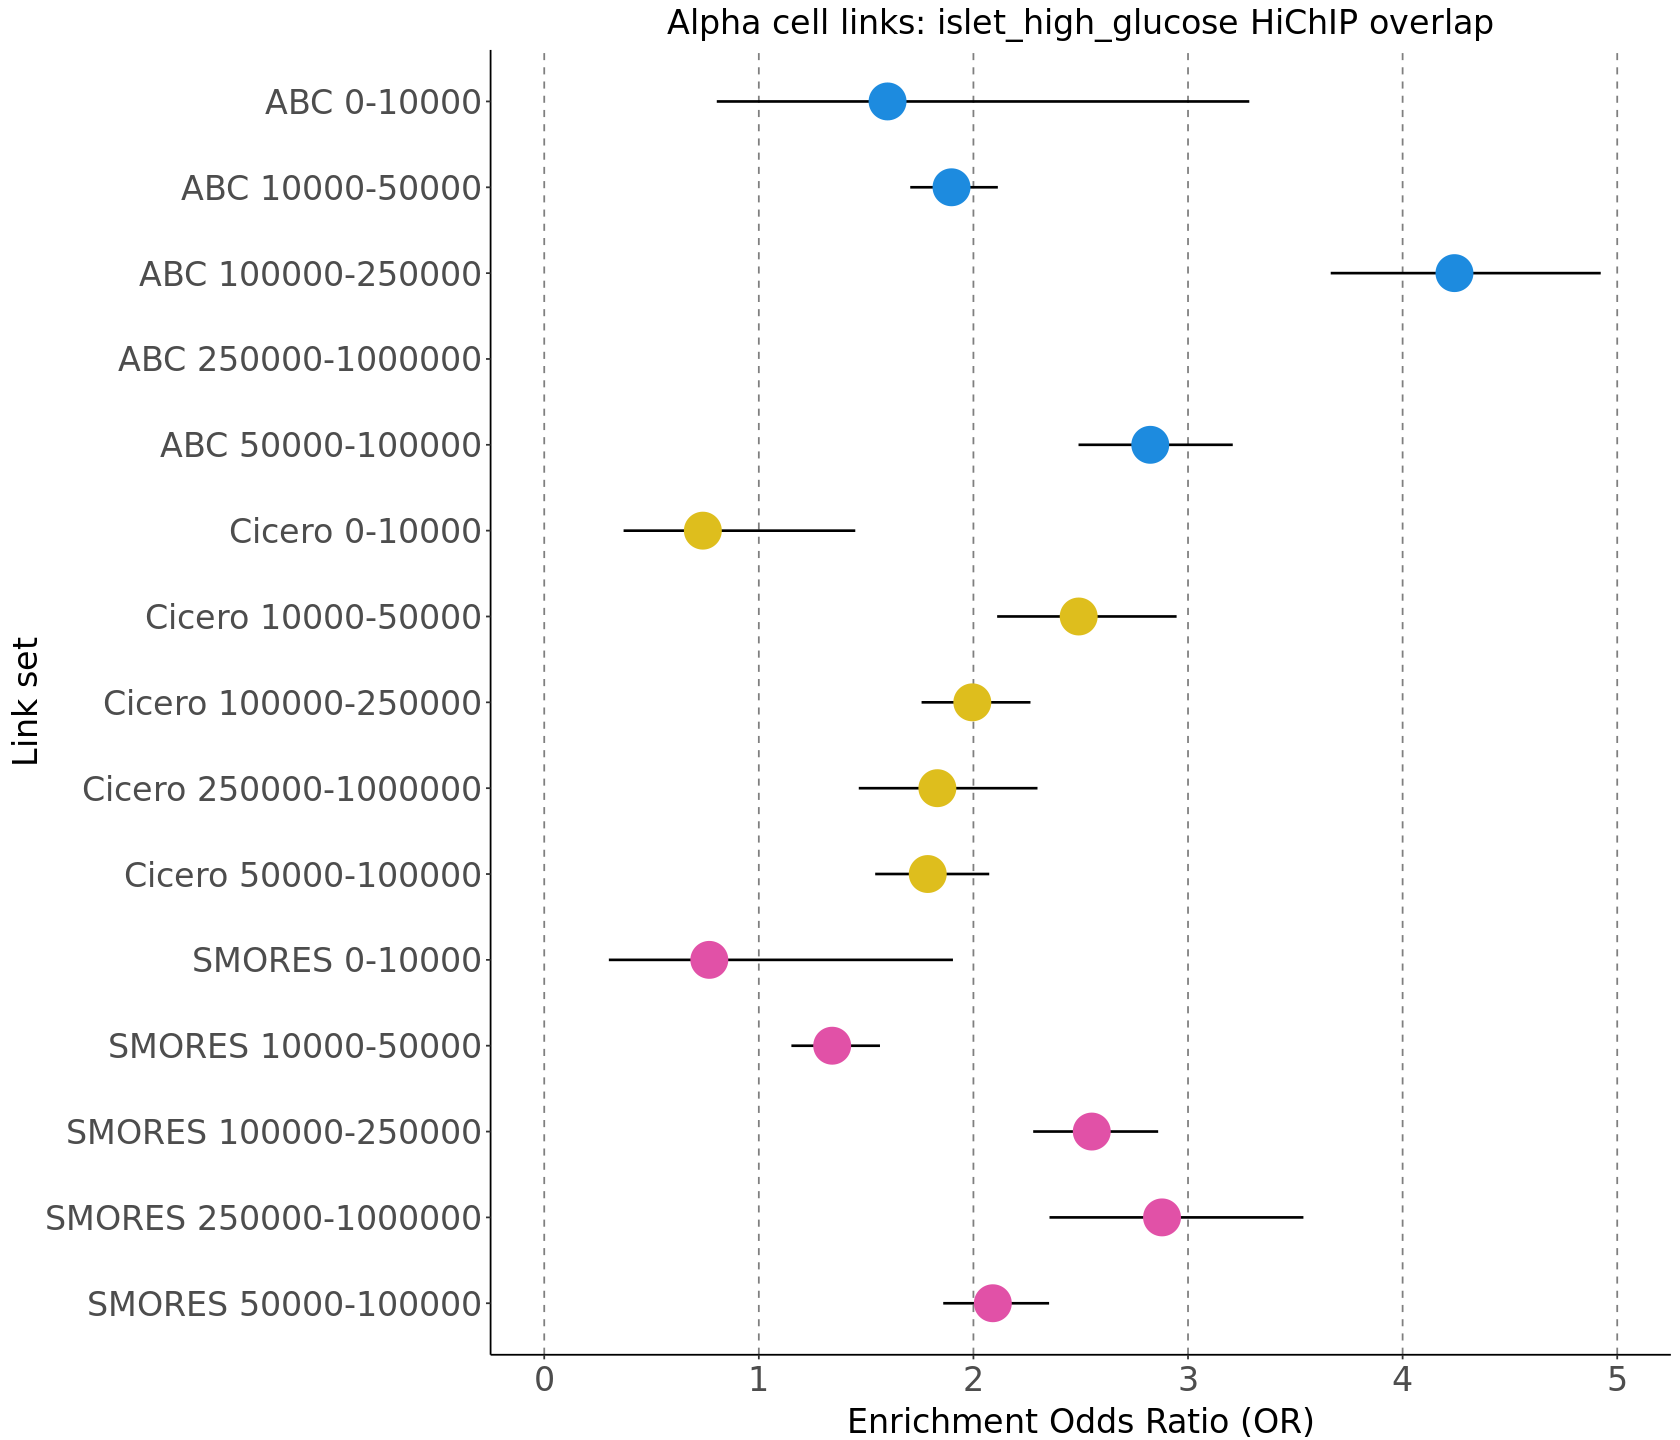

[1] "ABC_250000-1000000"


Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 13 rows containing missing values (`geom_segment()`)."


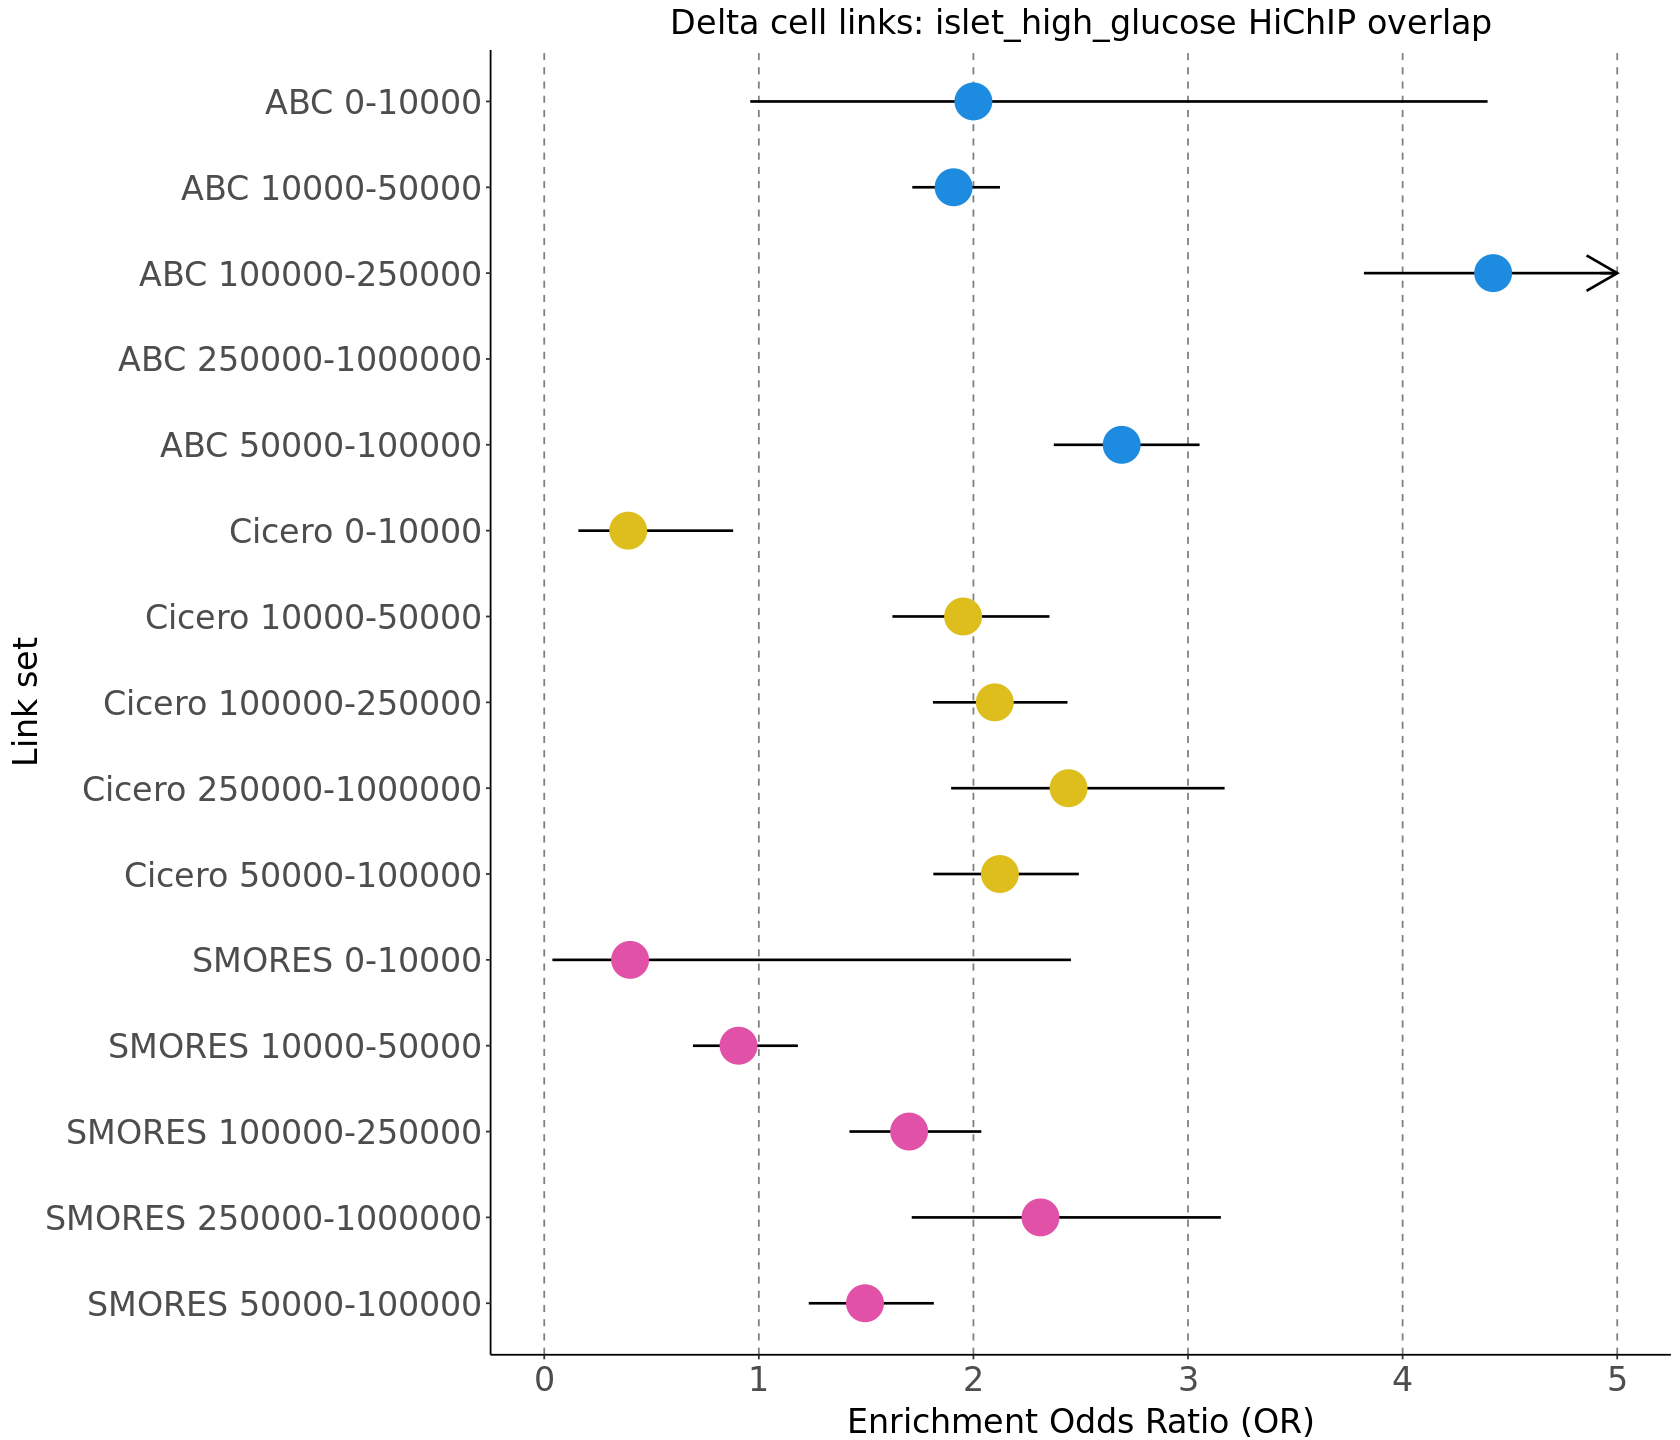

[1] "ABC_250000-1000000"


Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 15 rows containing missing values (`geom_segment()`)."


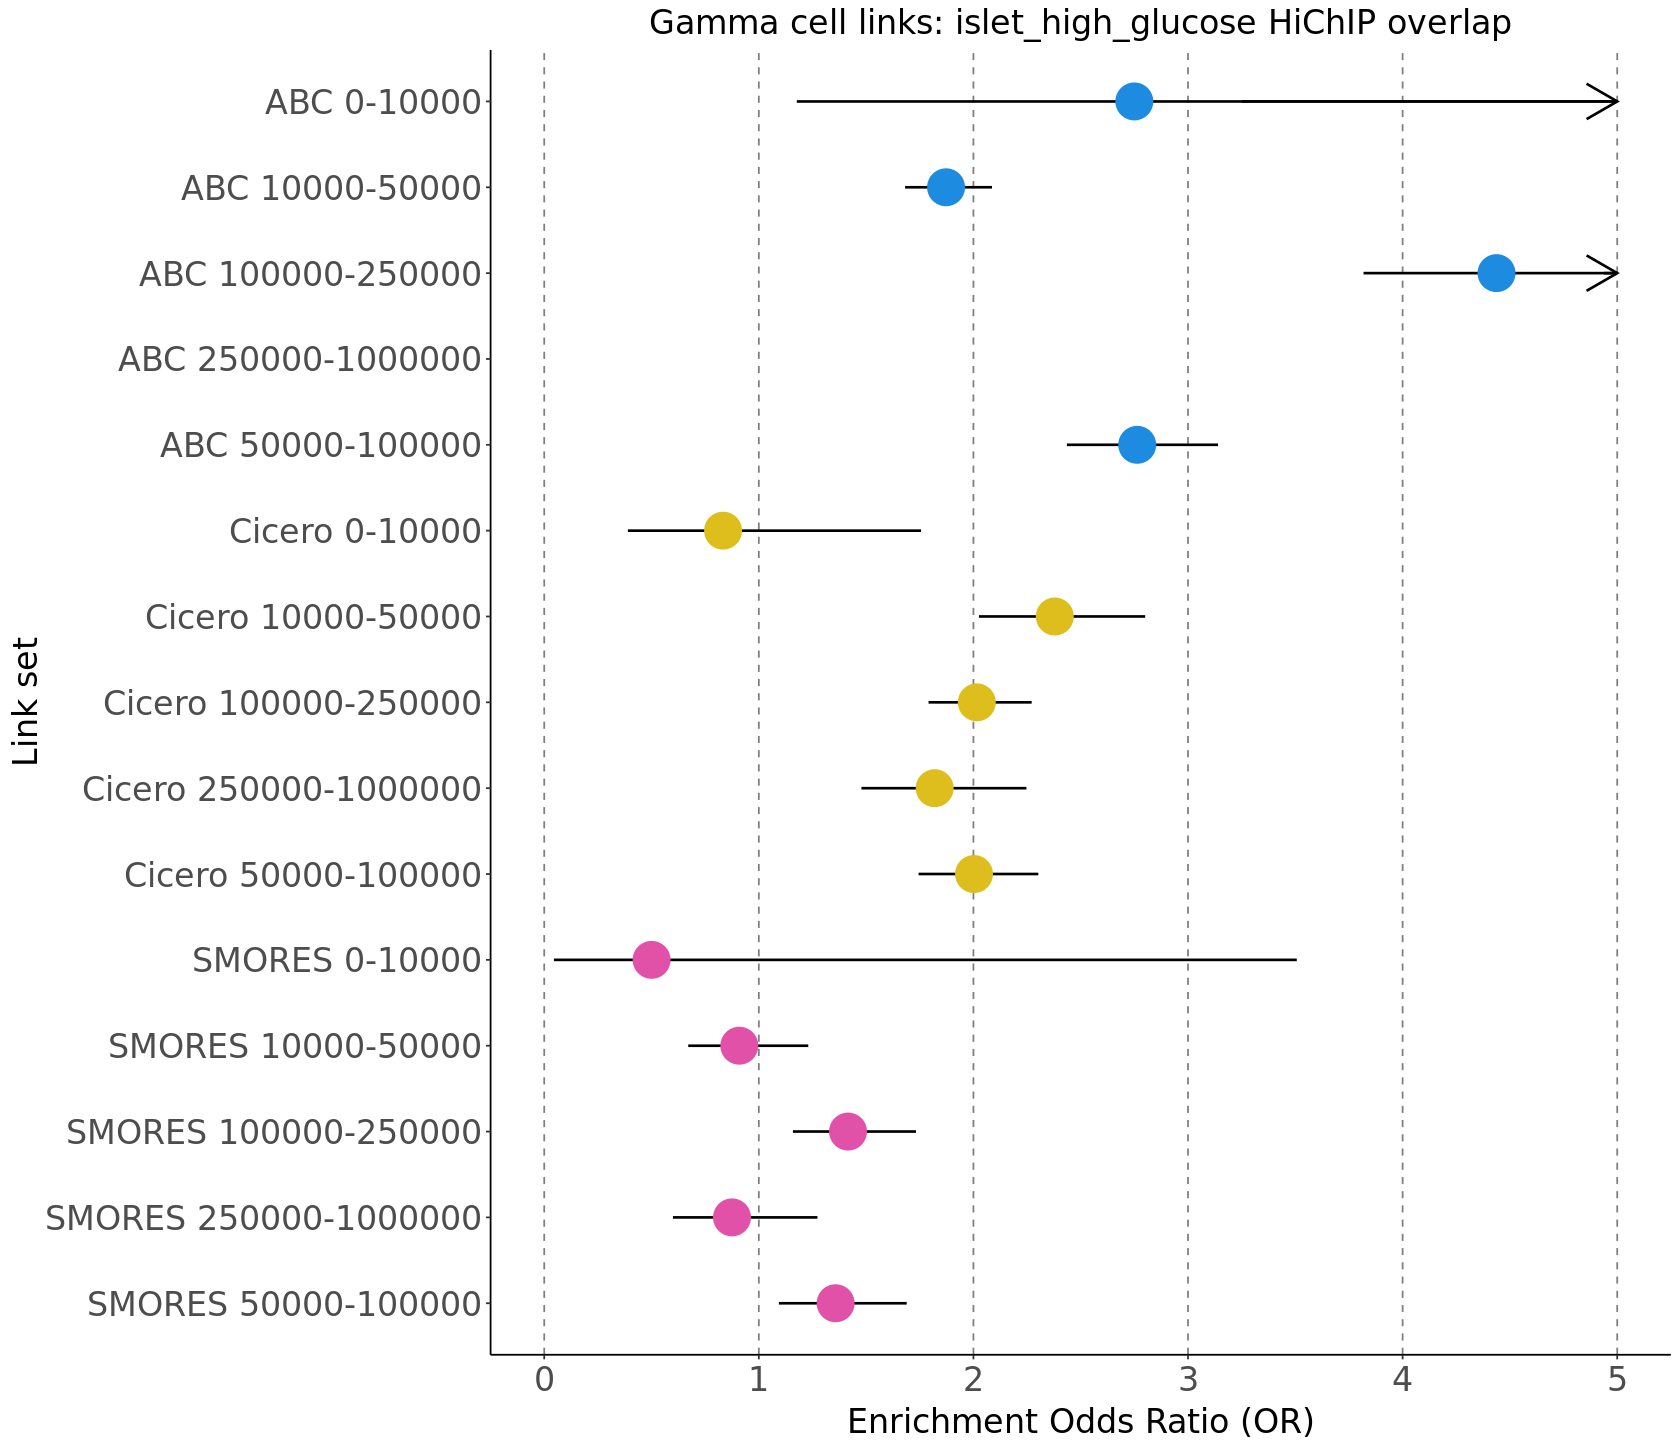

[1] "ABC_250000-1000000"


Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 15 rows containing missing values (`geom_segment()`)."


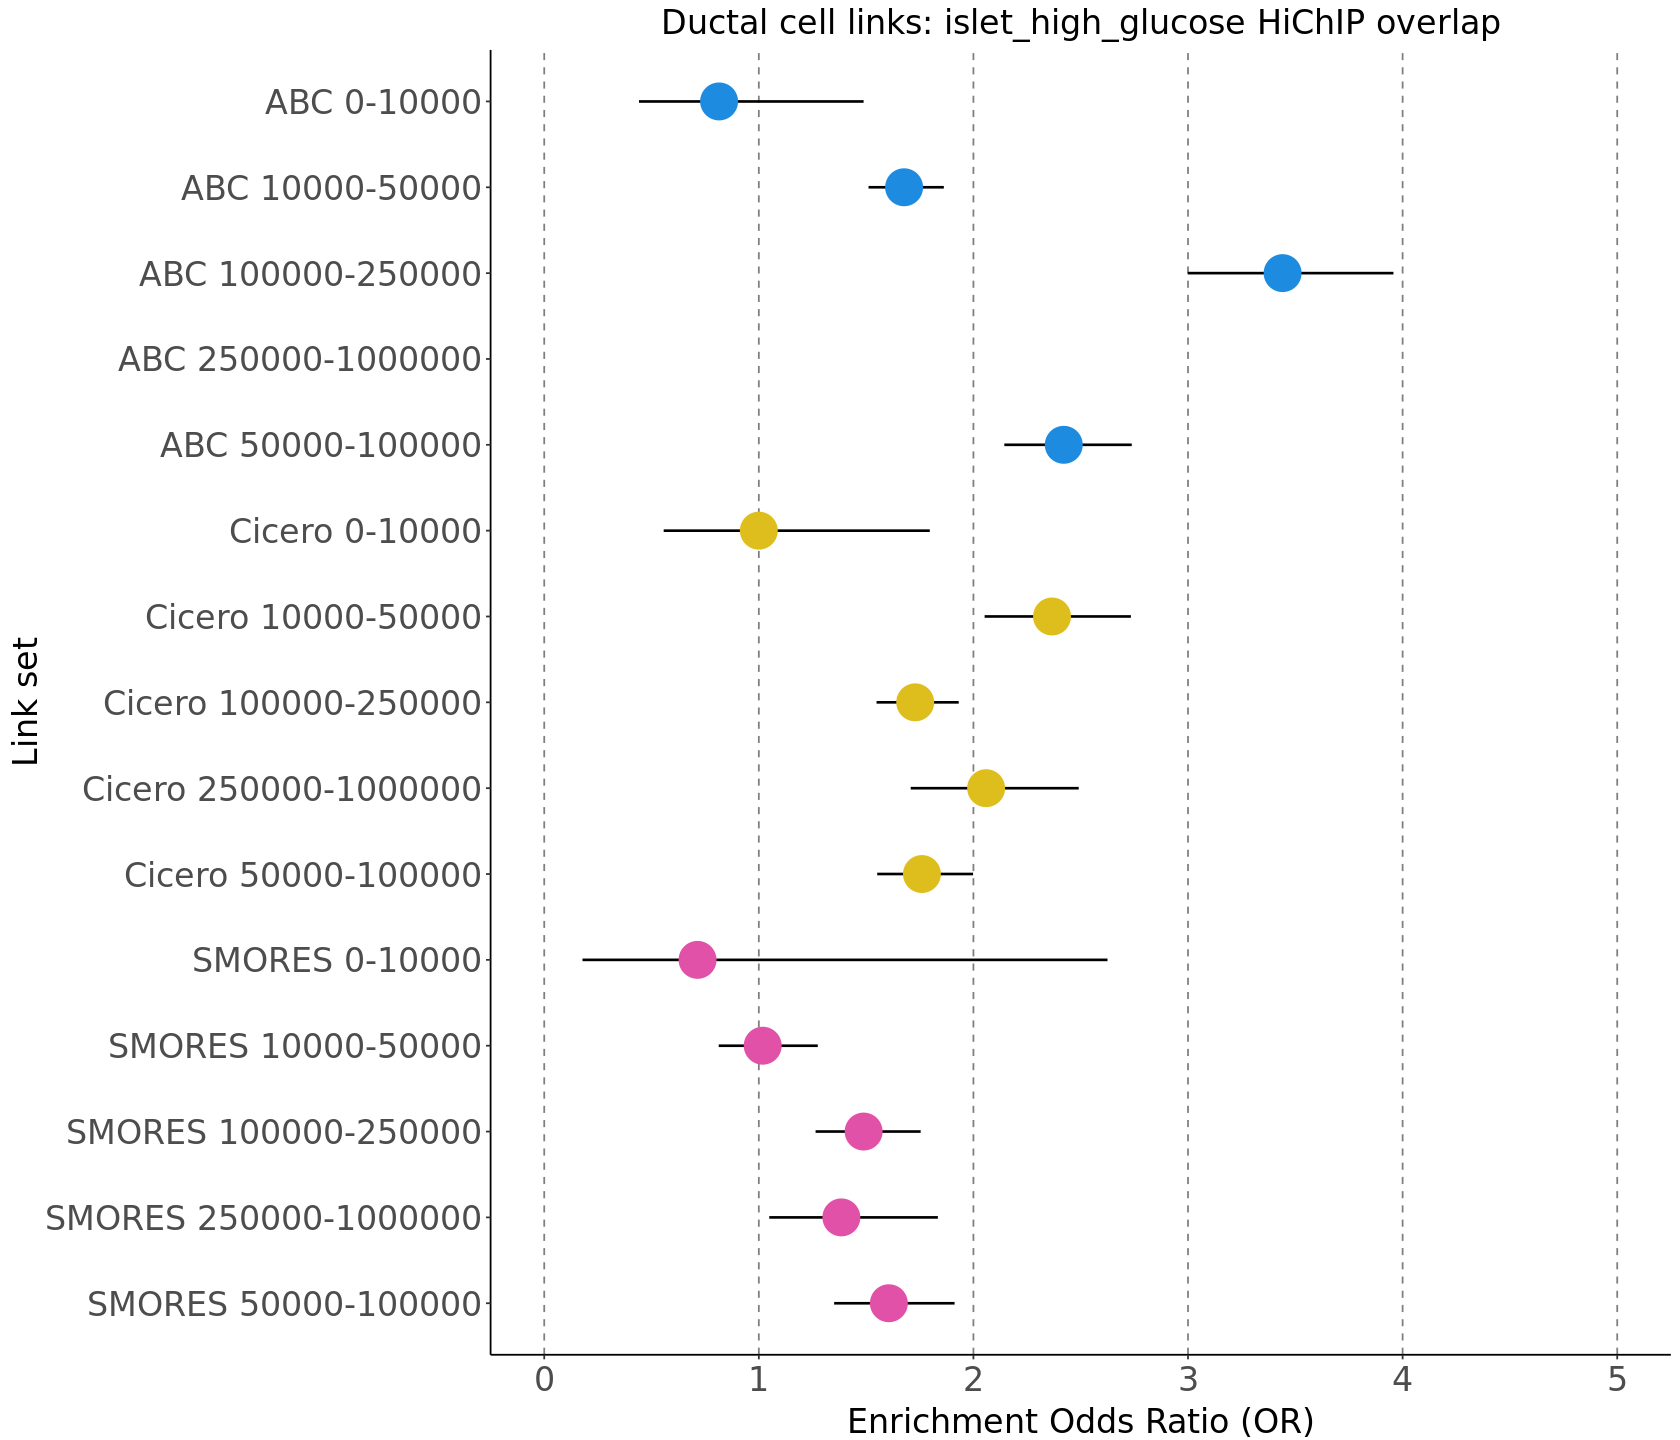

[1] "ABC_250000-1000000"


Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 15 rows containing missing values (`geom_segment()`)."


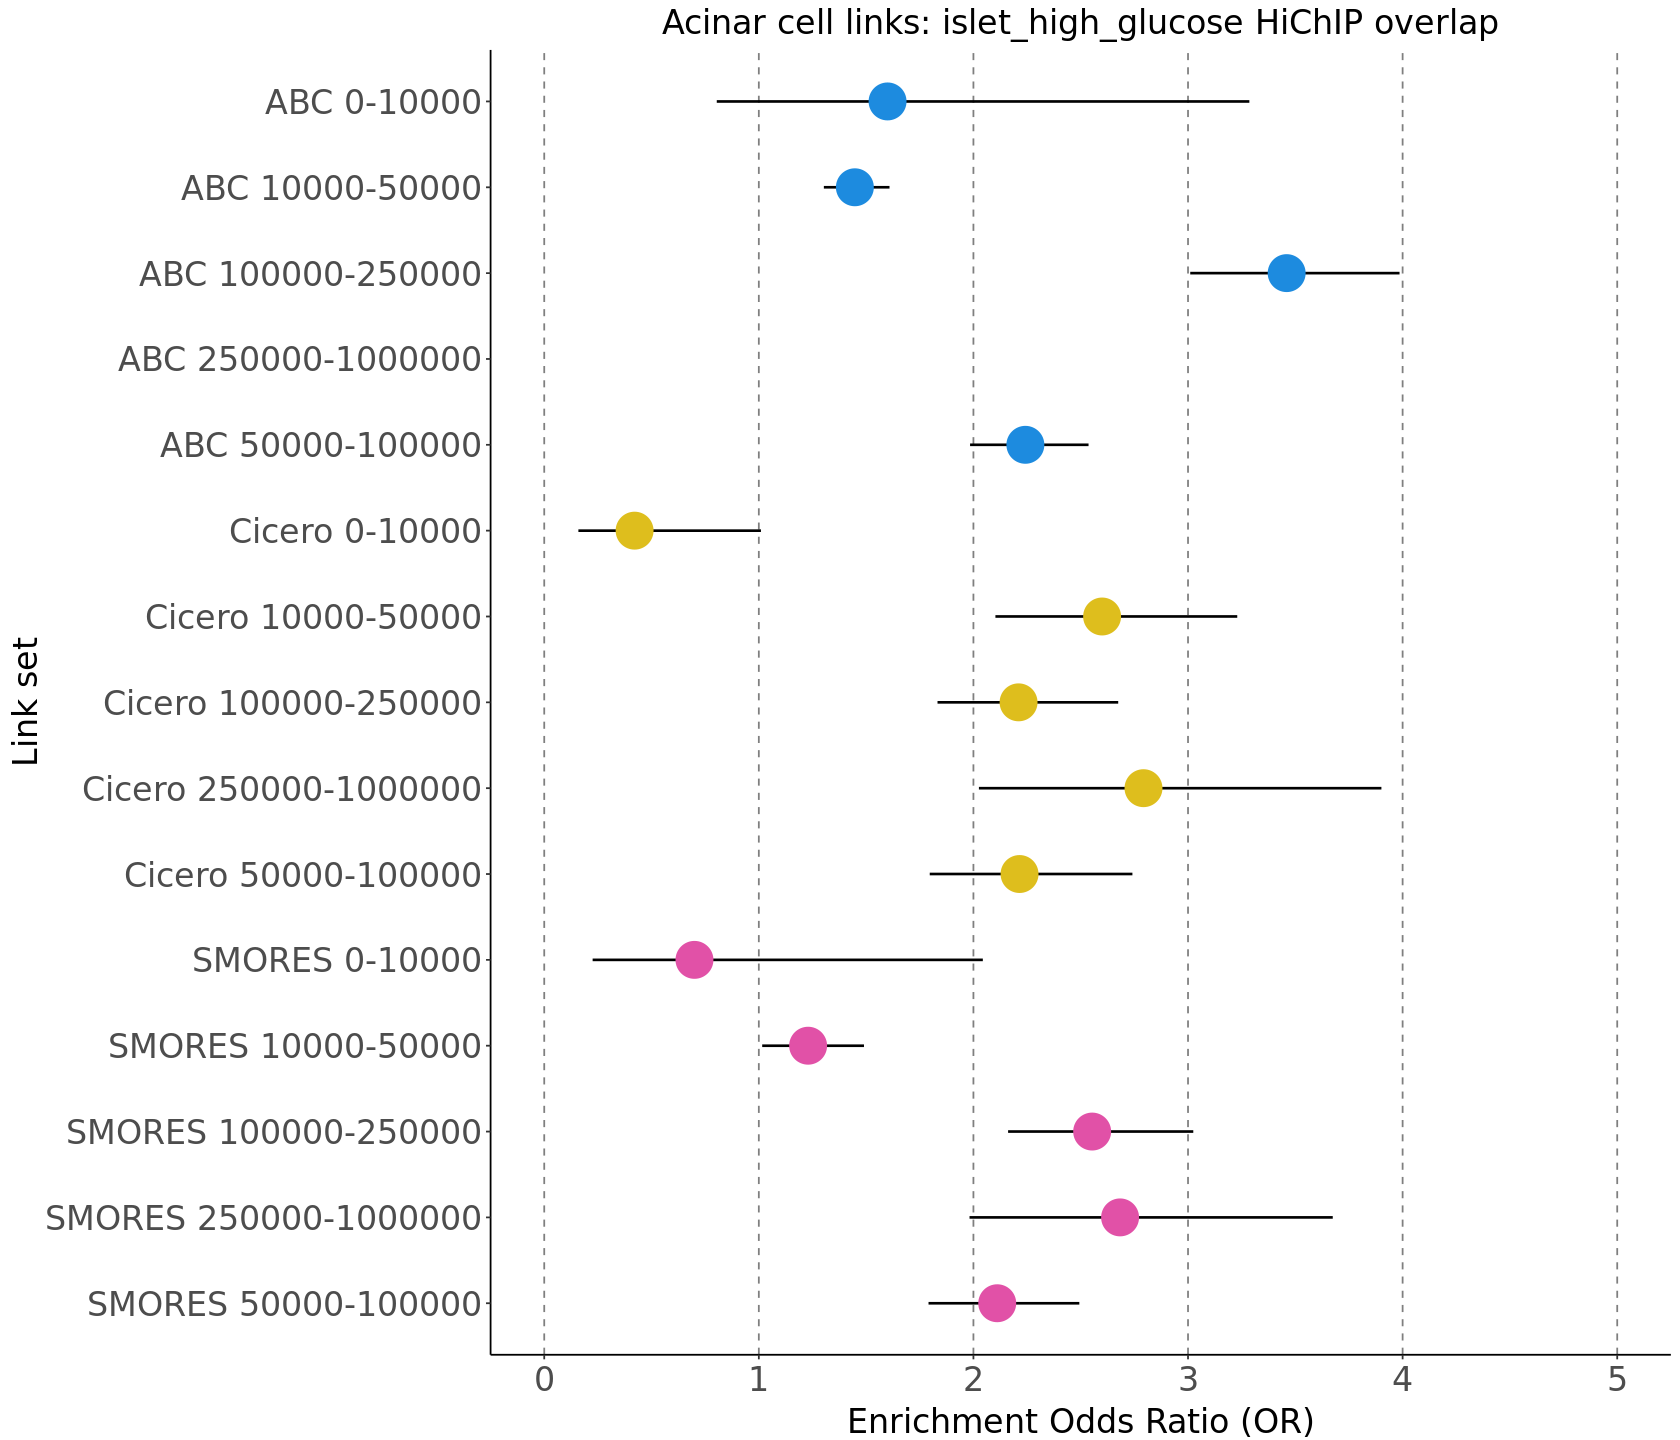

[1] "ABC_250000-1000000"


Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 14 rows containing missing values (`geom_segment()`)."


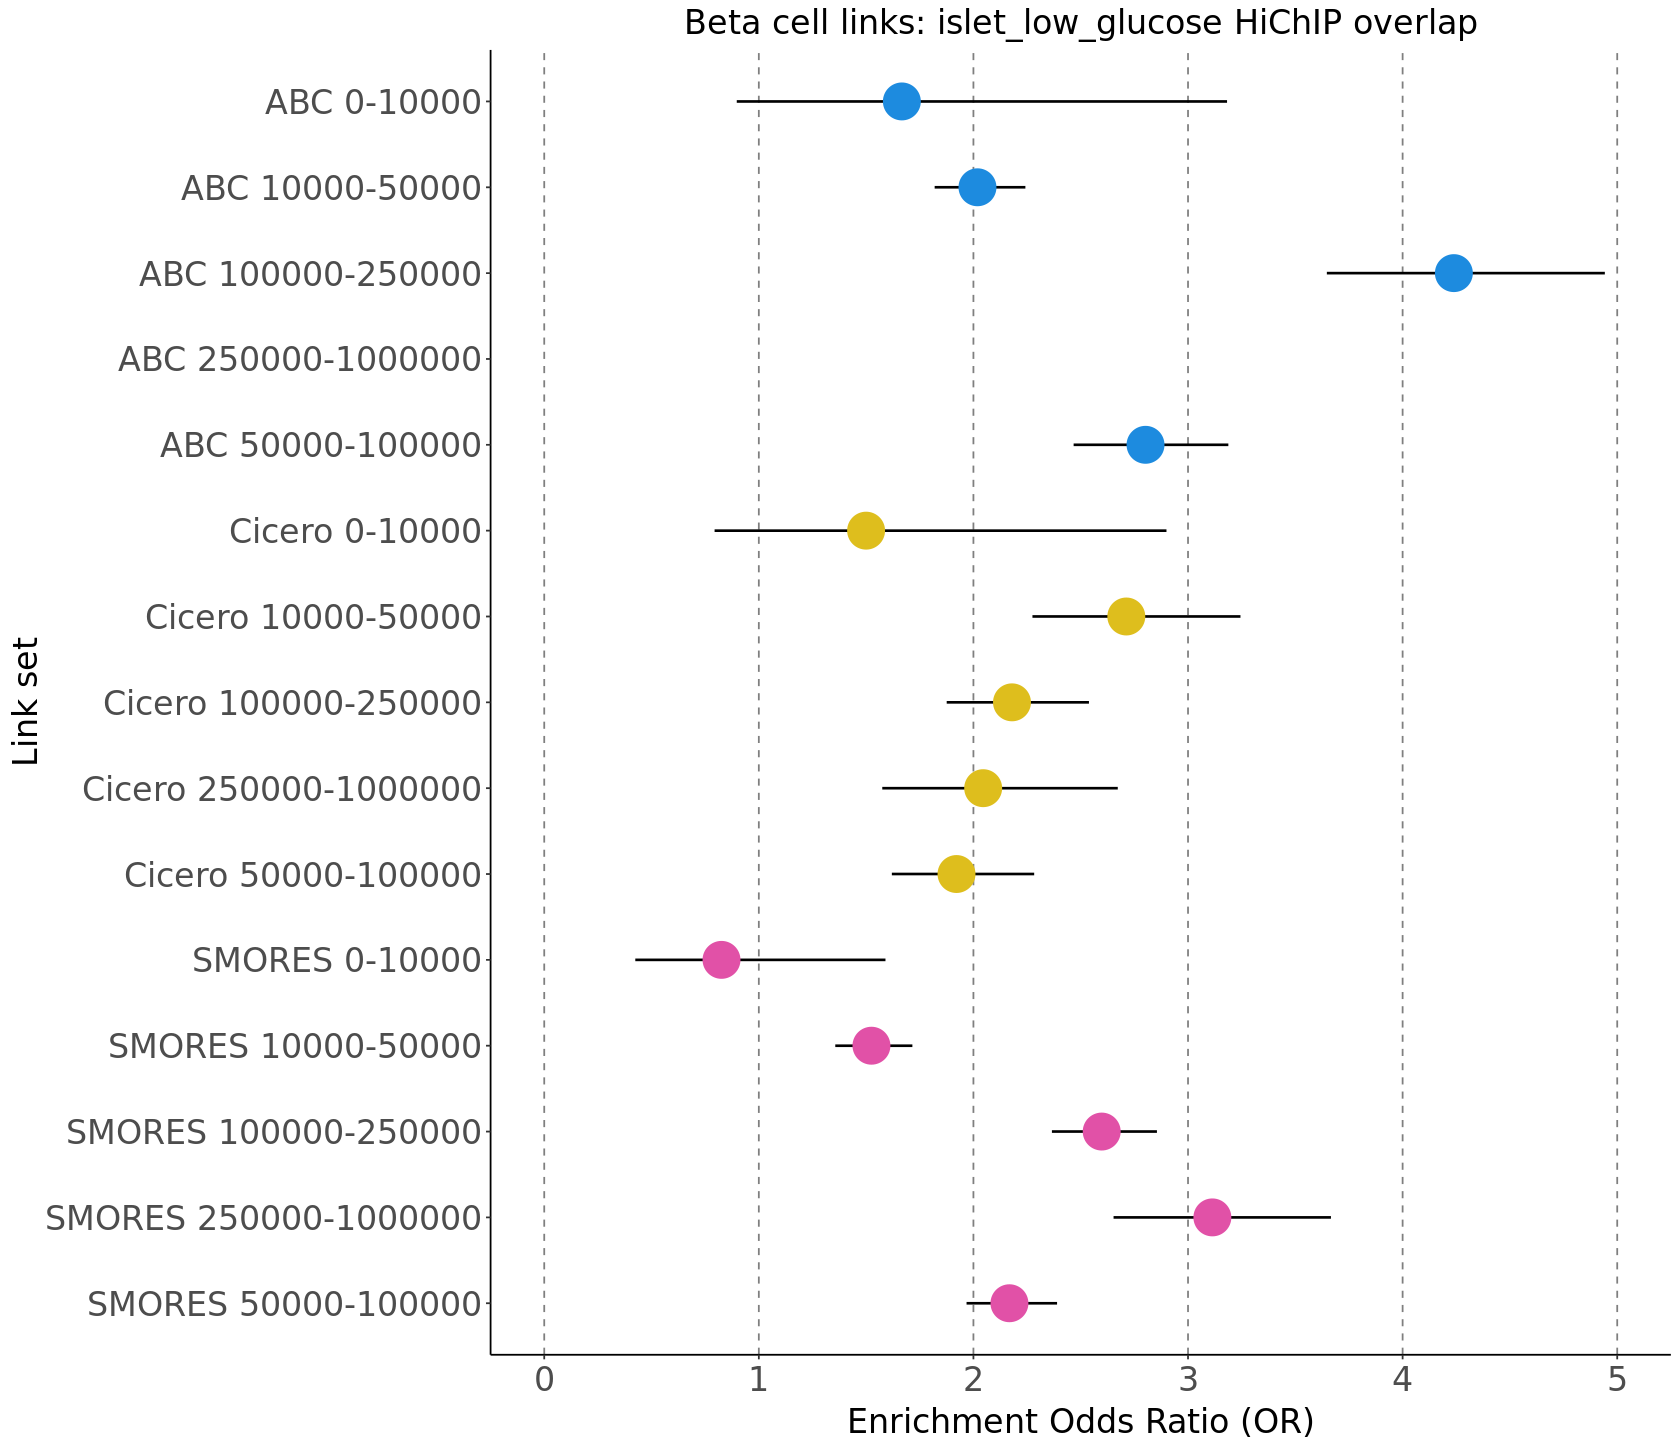

[1] "ABC_250000-1000000"


Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 15 rows containing missing values (`geom_segment()`)."


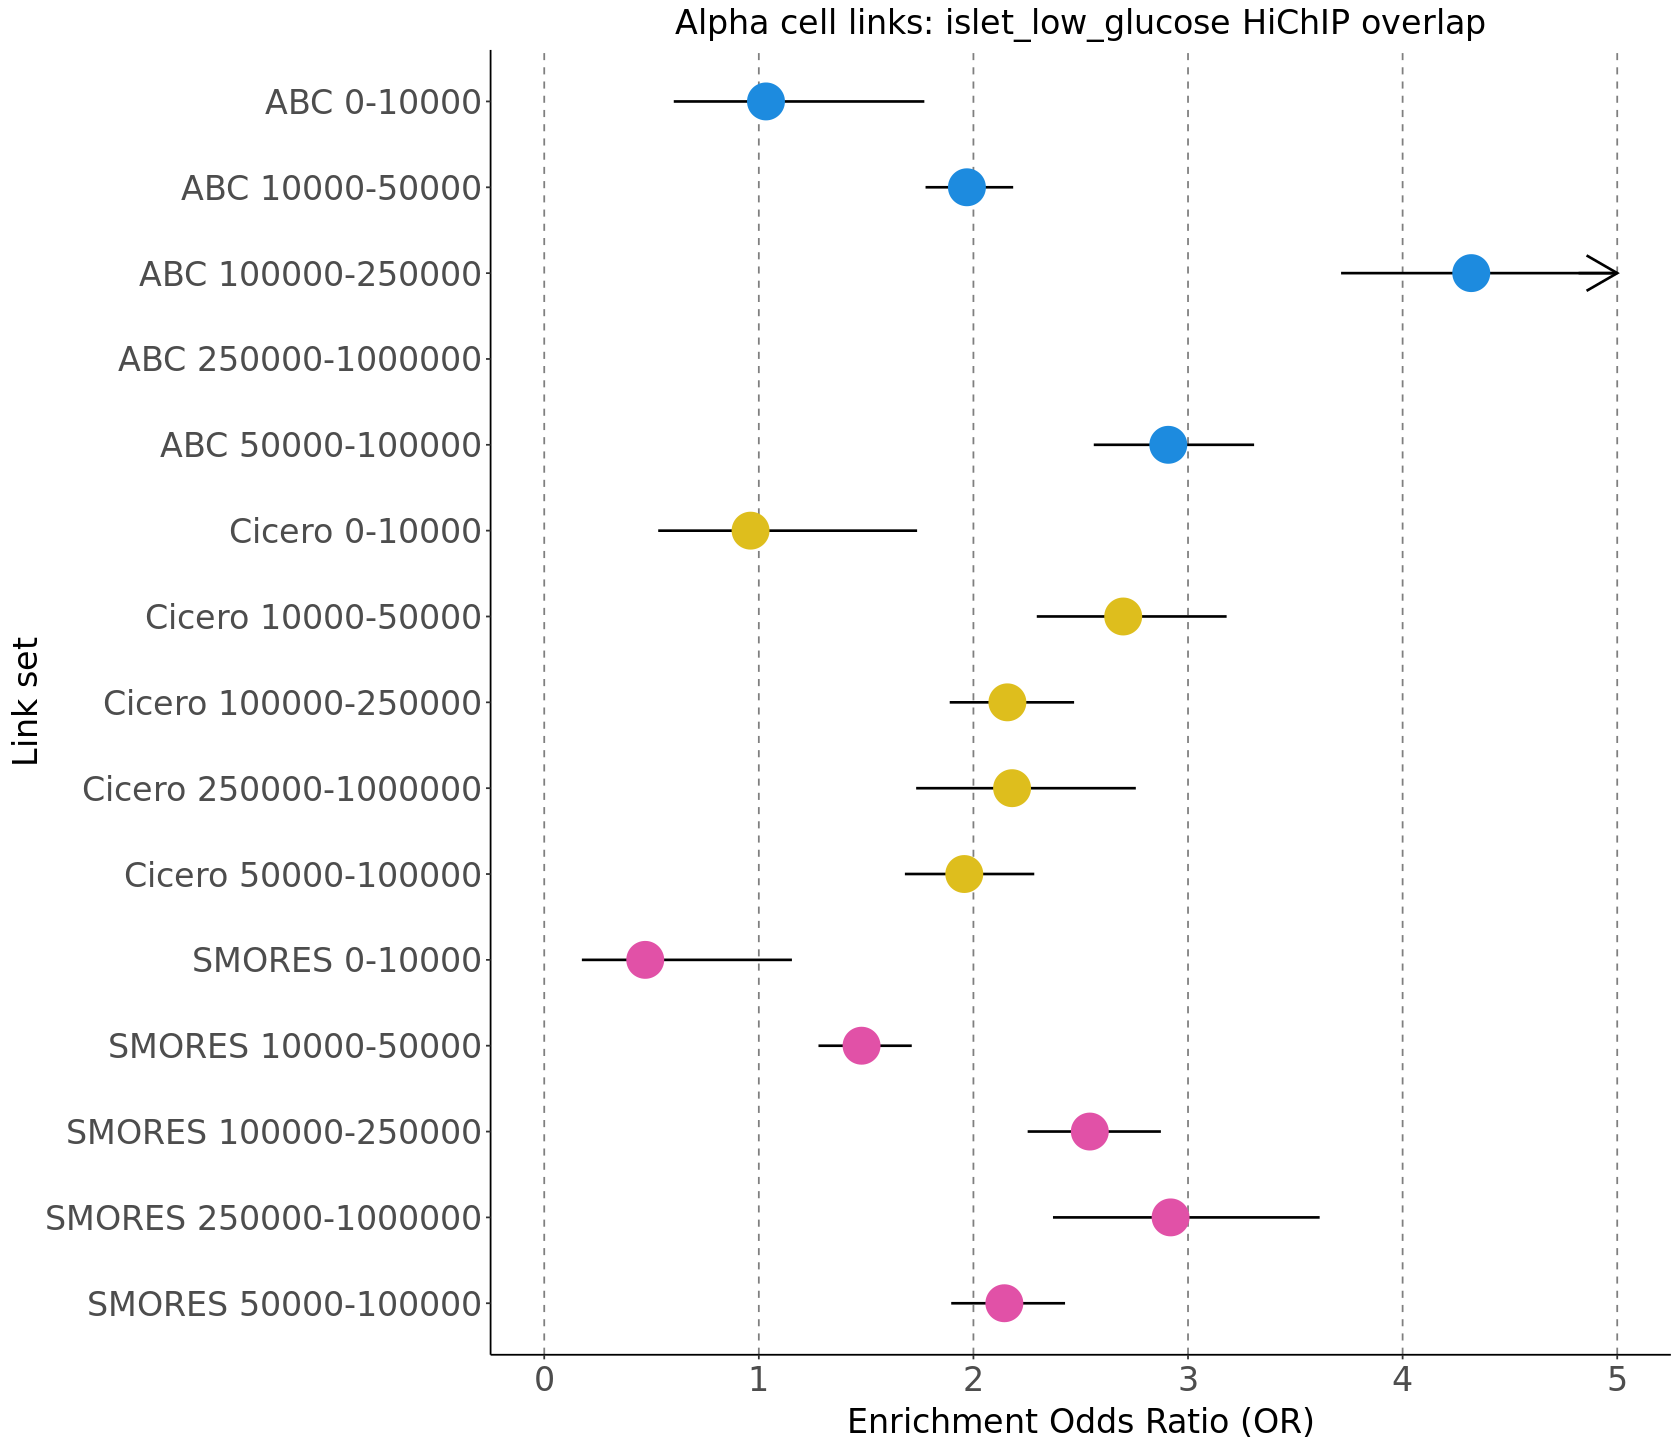

[1] "ABC_250000-1000000"


Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 15 rows containing missing values (`geom_segment()`)."


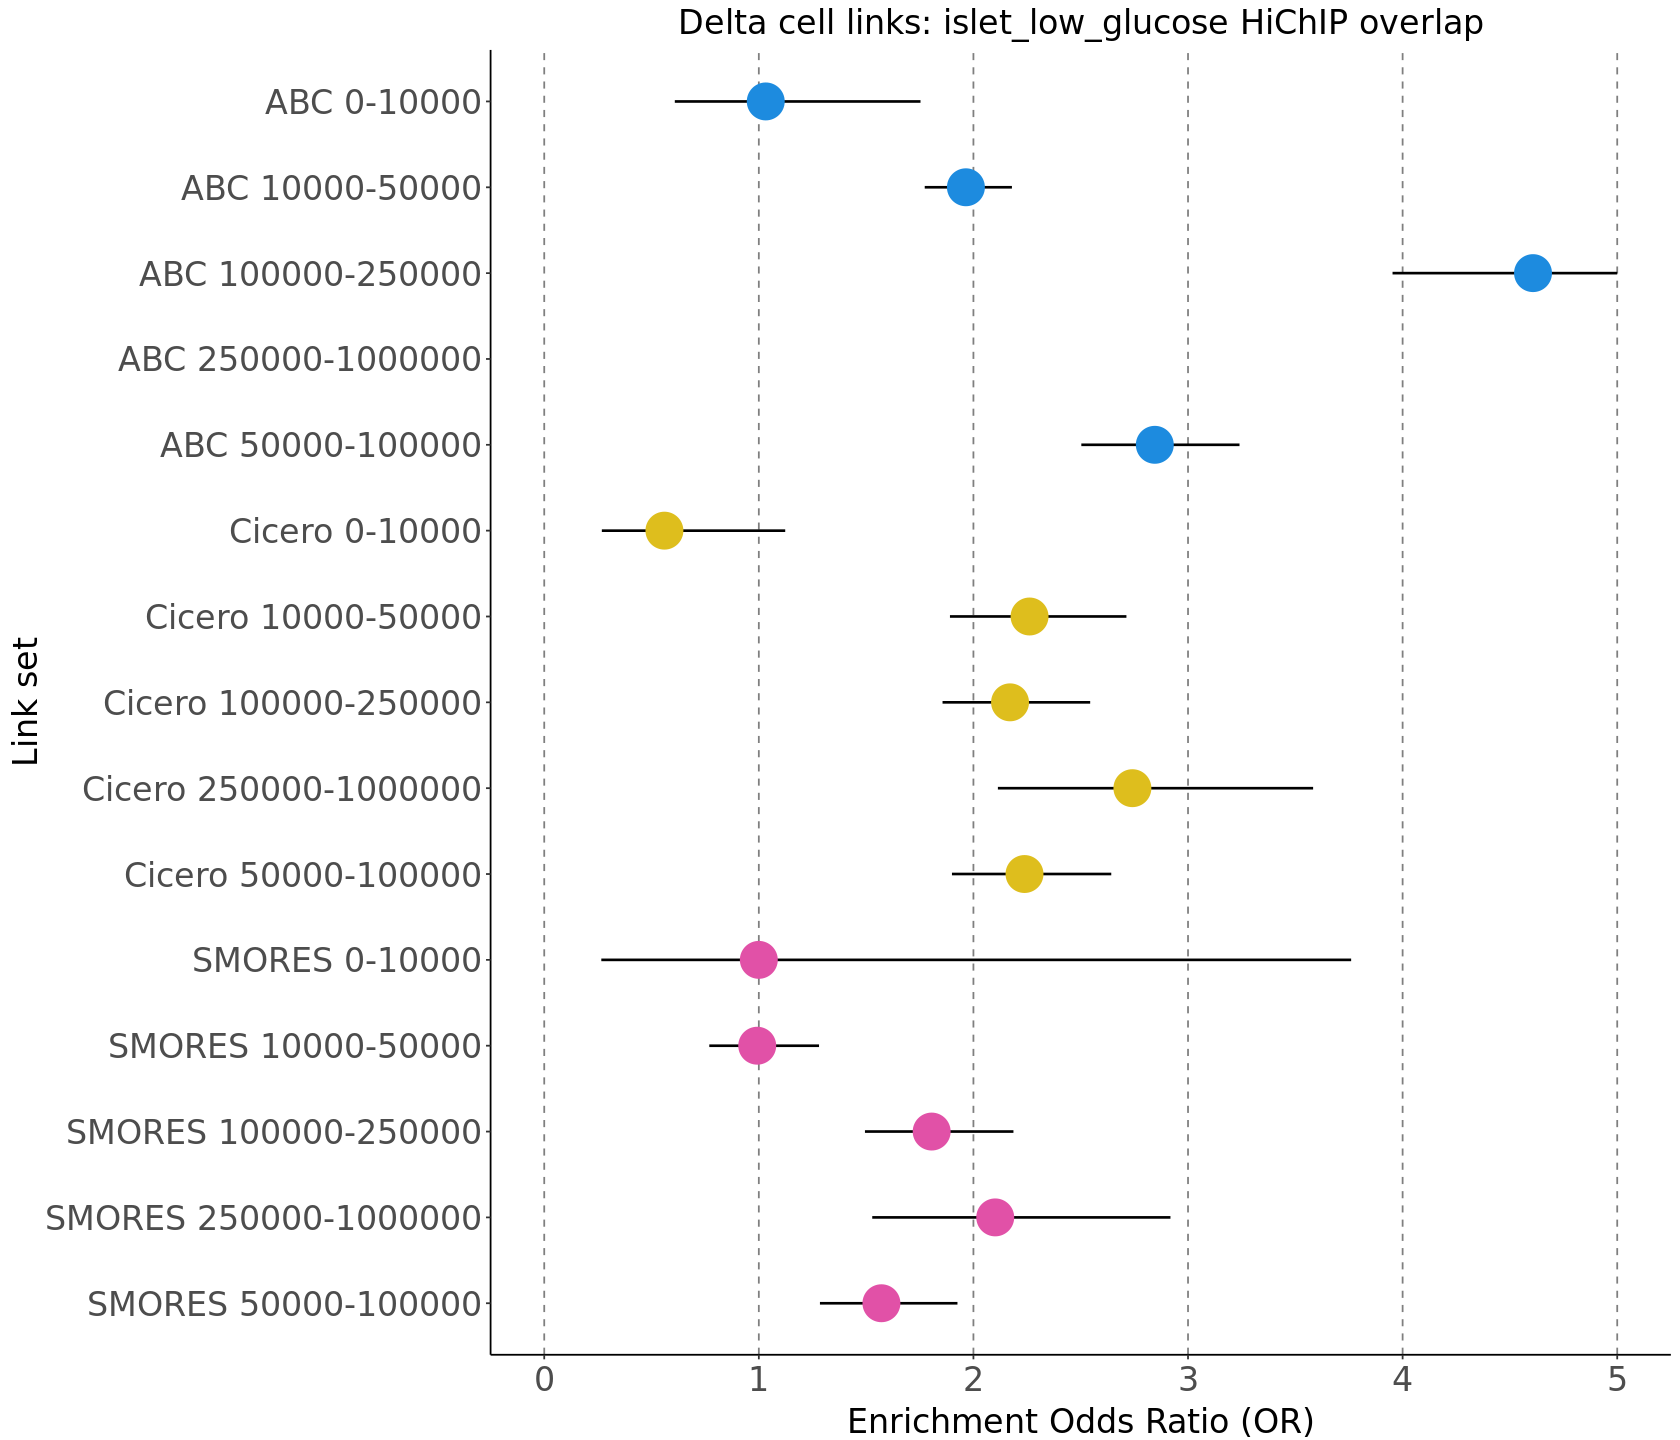

[1] "ABC_250000-1000000"


Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 15 rows containing missing values (`geom_segment()`)."


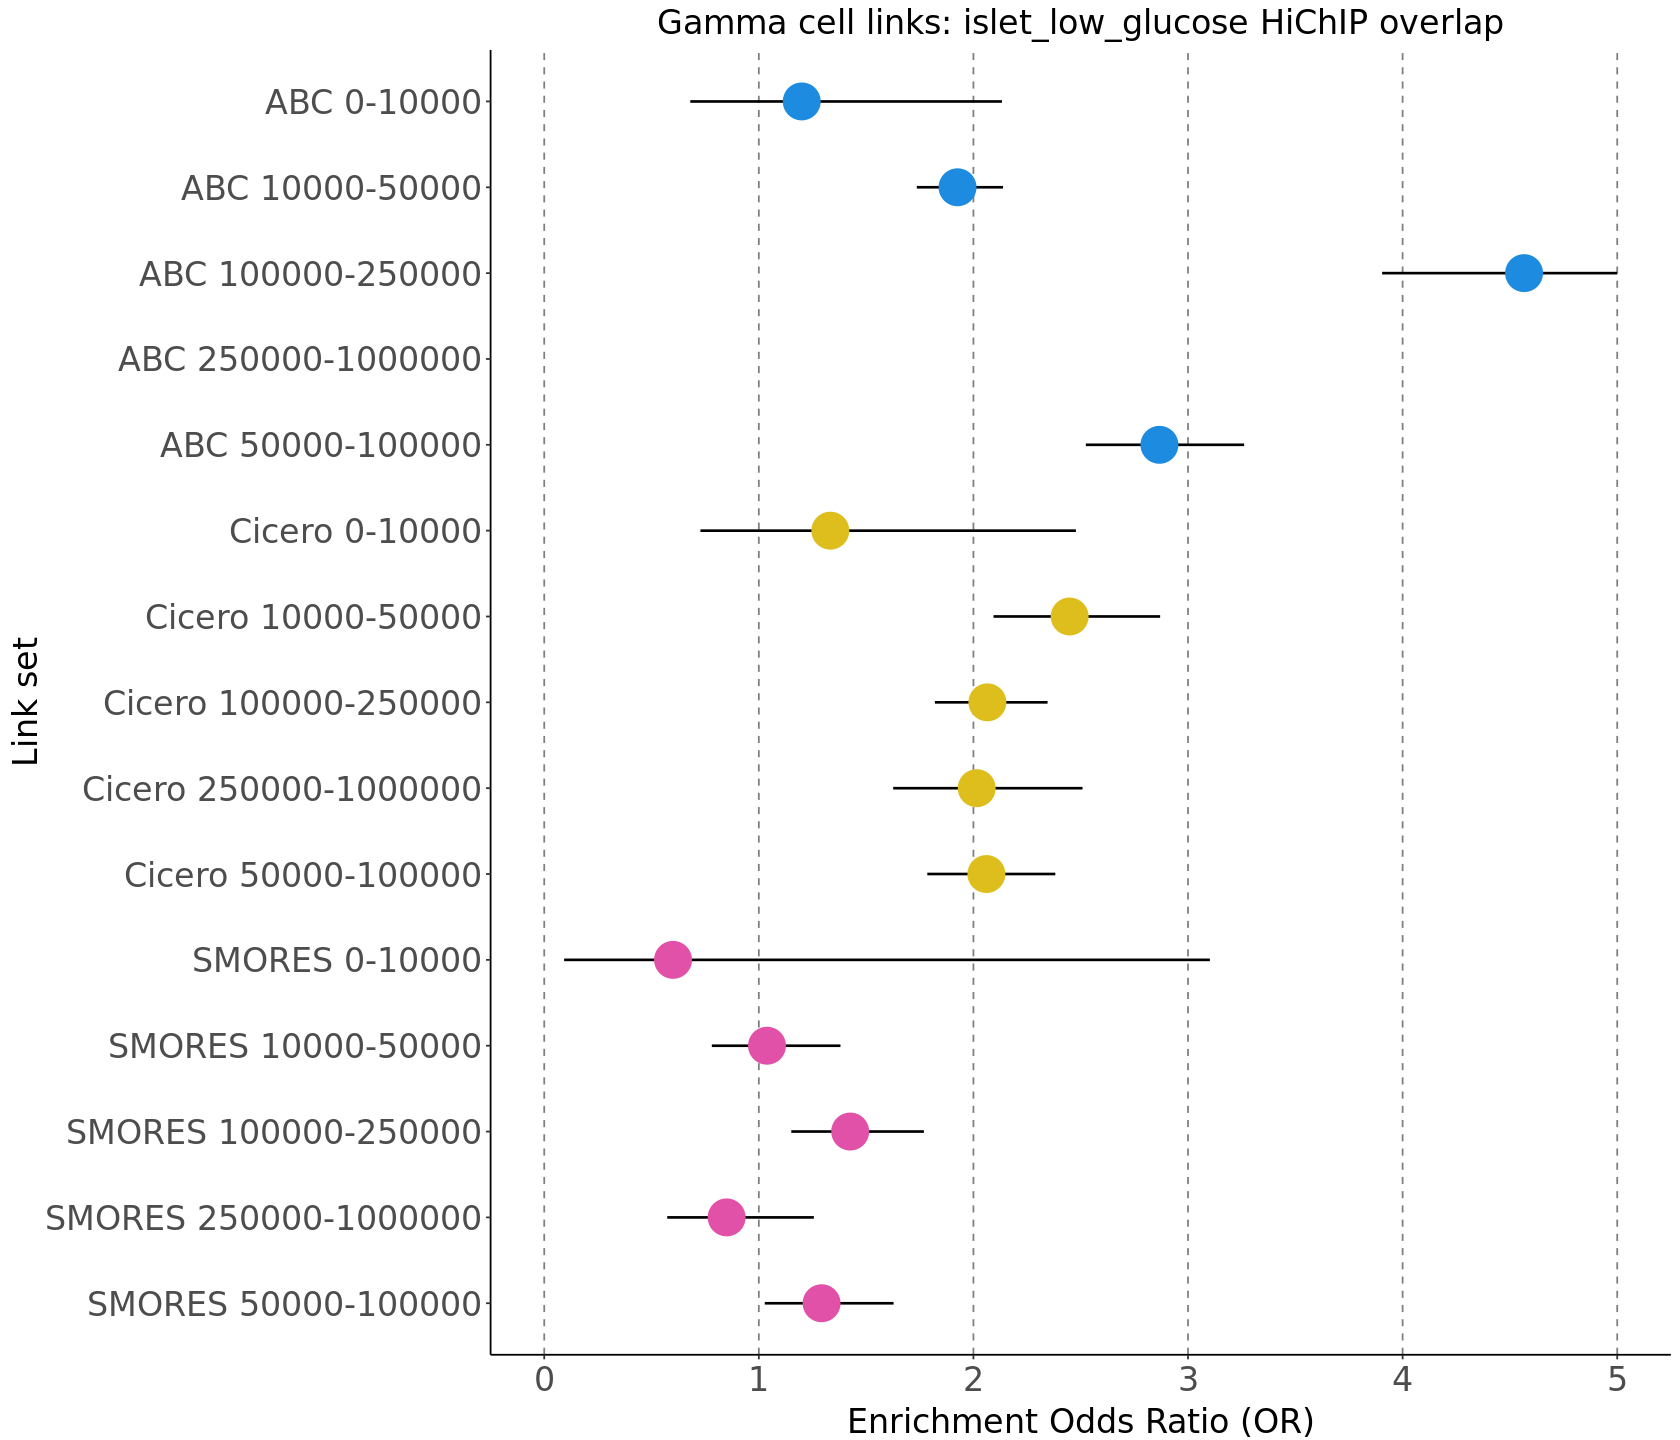

[1] "ABC_250000-1000000"


Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 15 rows containing missing values (`geom_segment()`)."


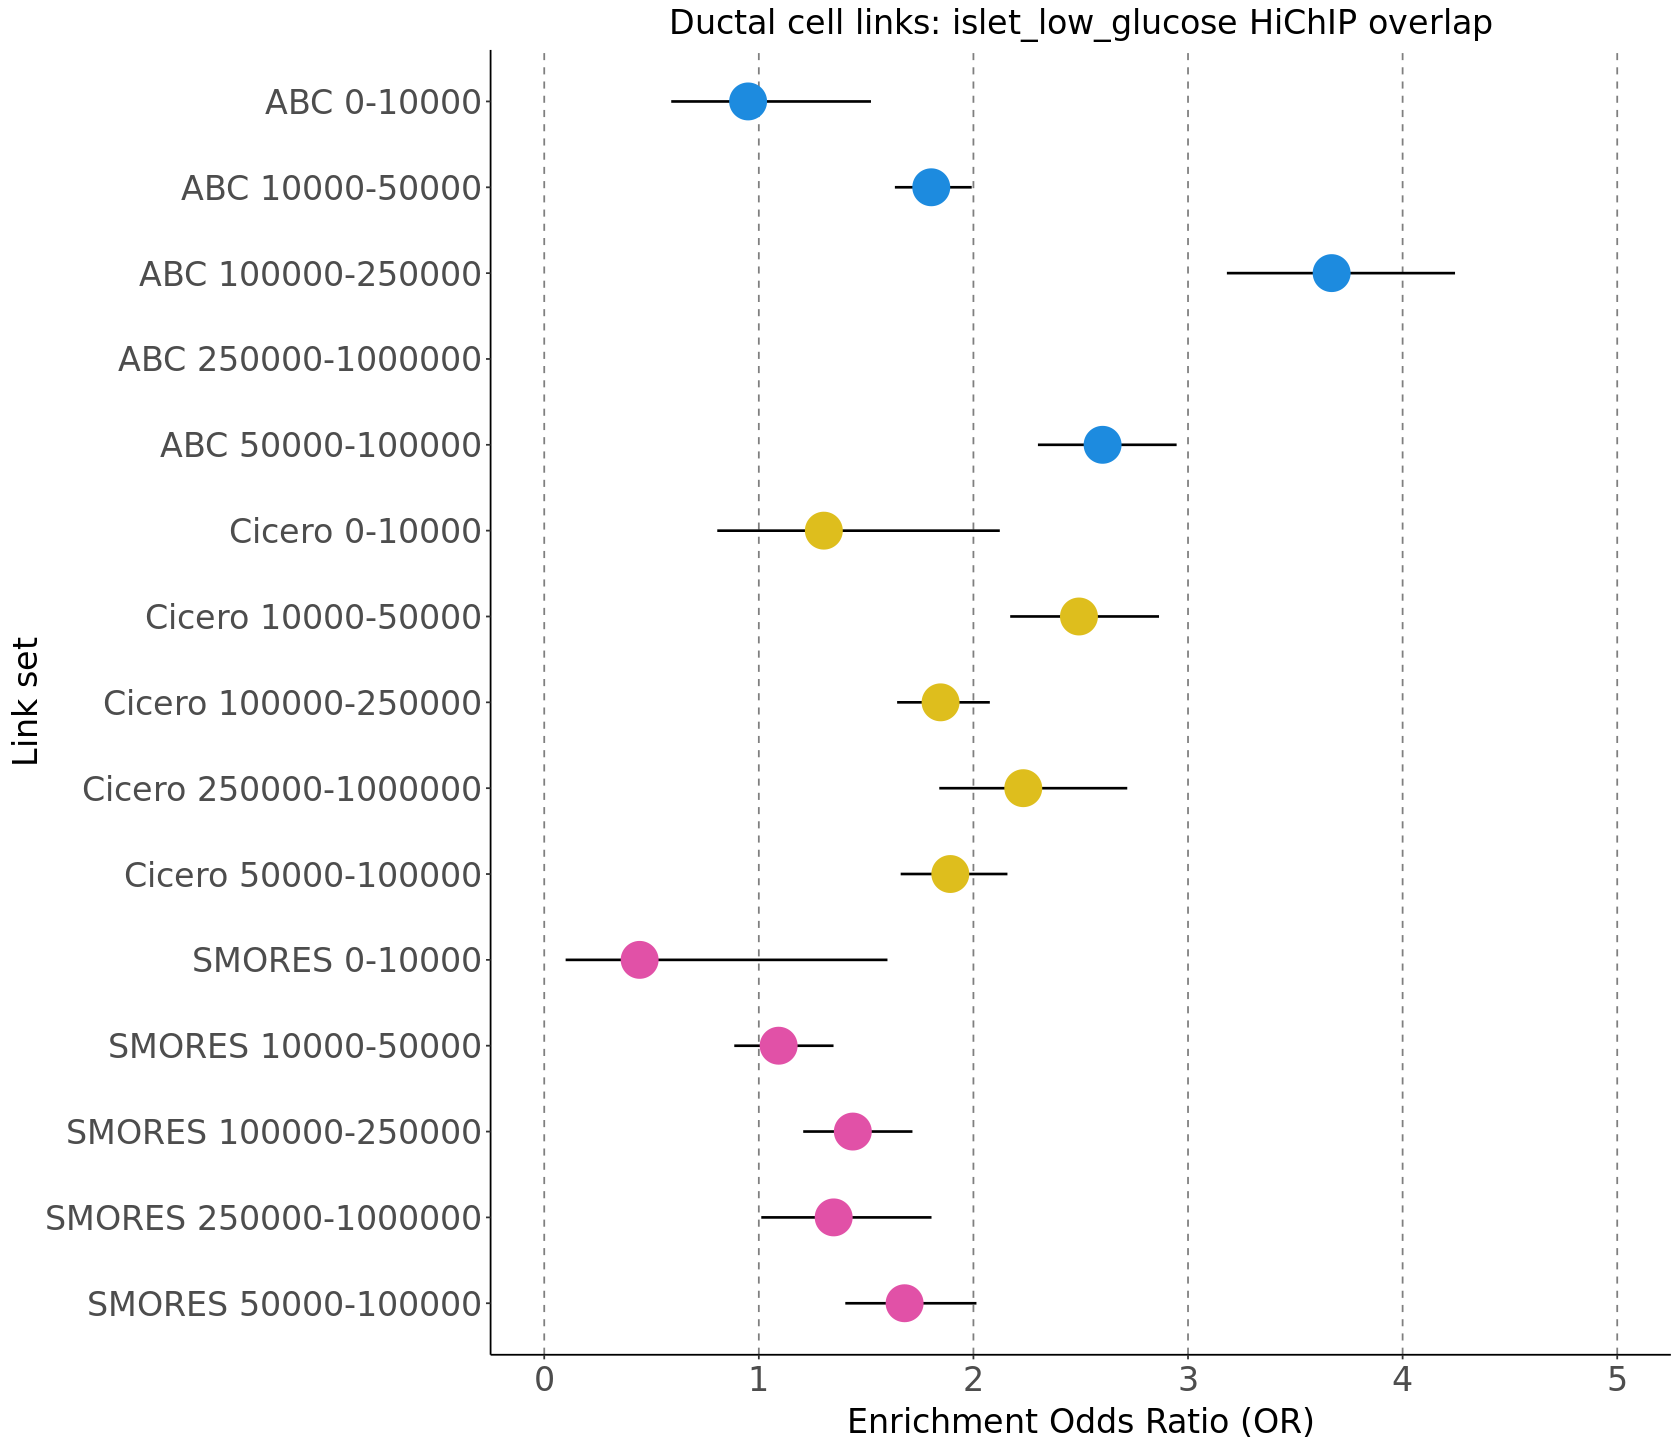

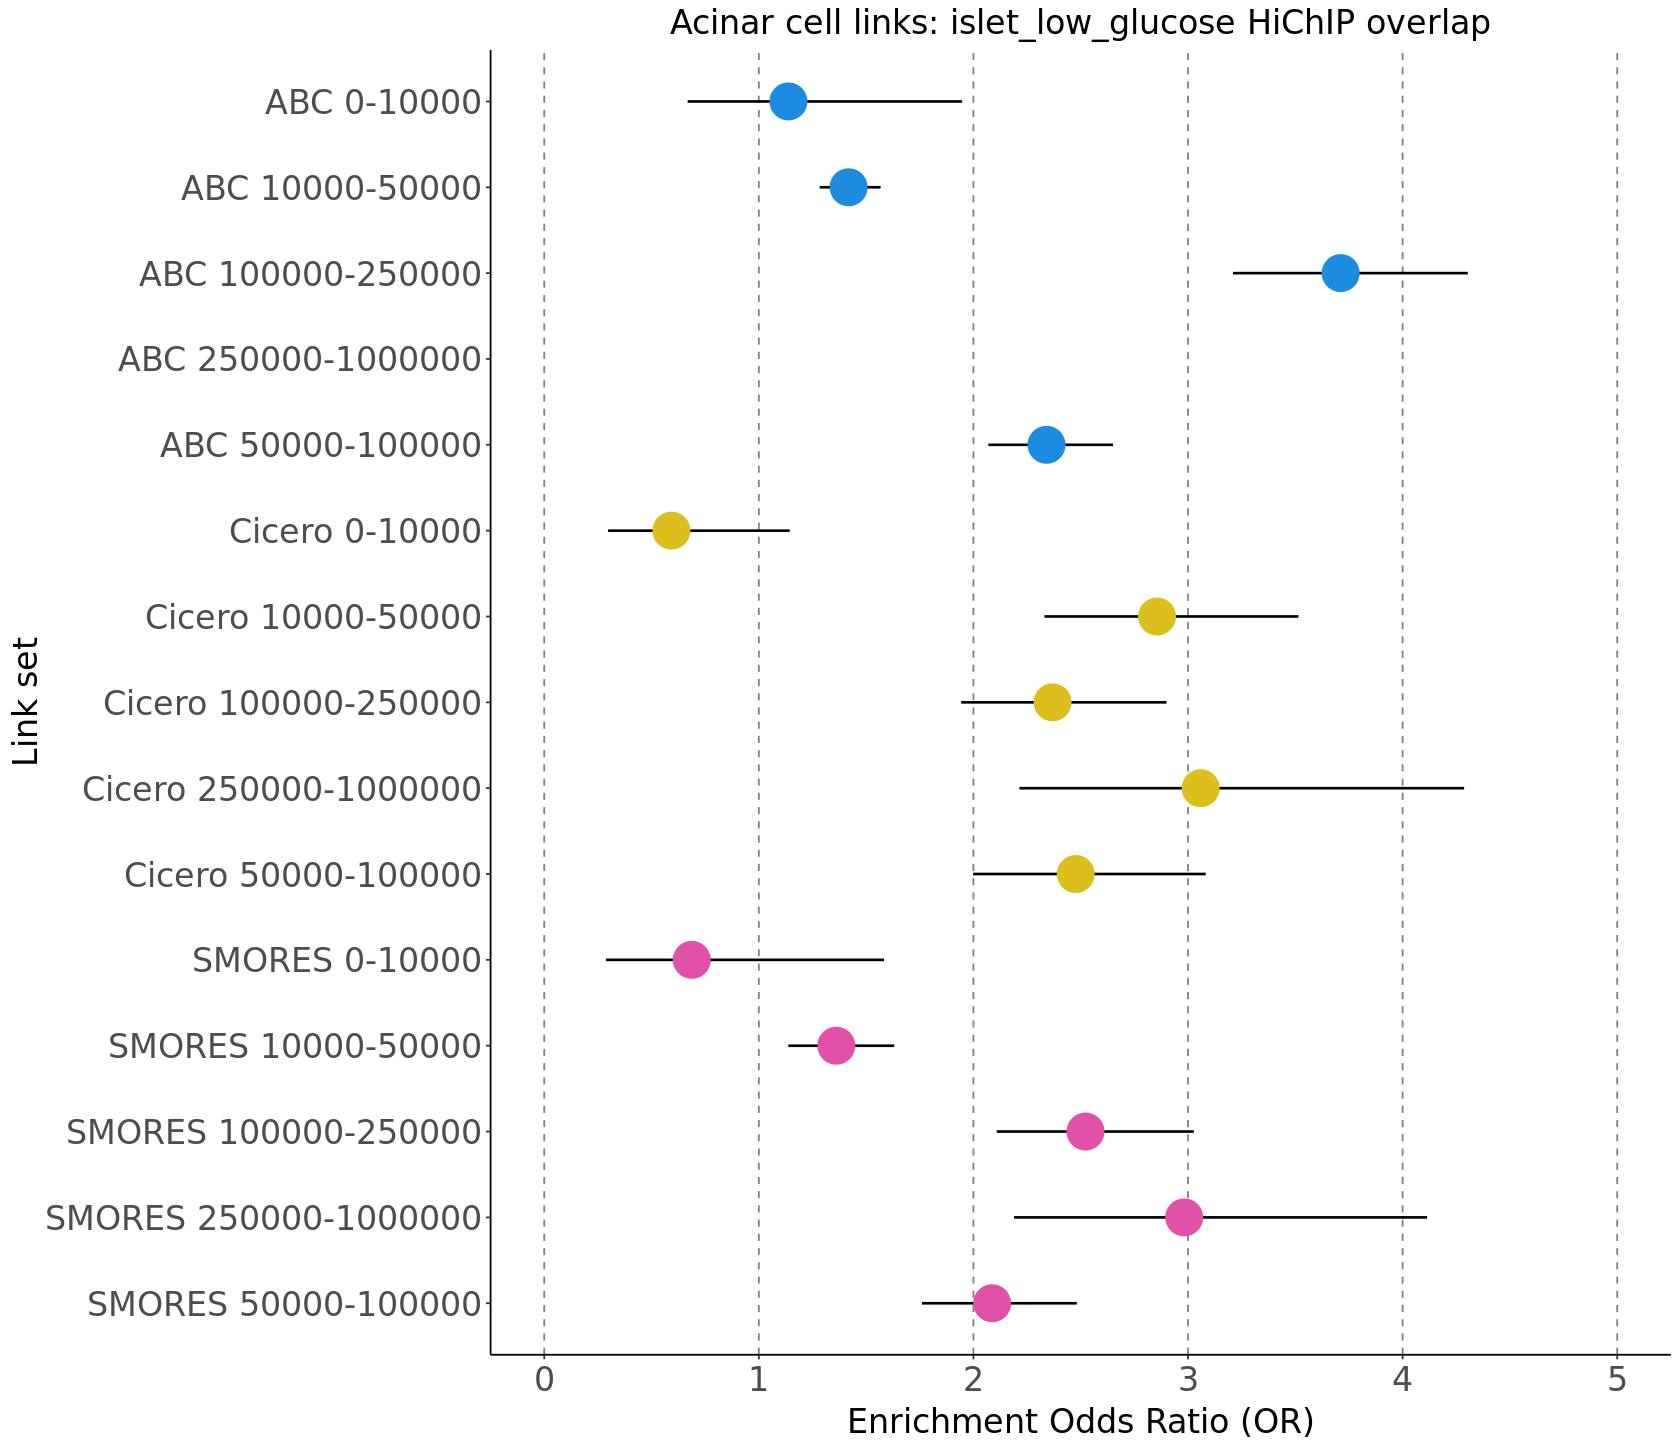

In [21]:
# Make plots by celltypes and/or methods
for(prefix in names(hichip_fps)){
    for (celltype in celltypes){
        results_fp <- file.path(fin_outdir, sprintf('%s_%s_HiChIP_overlap.link_methods_dist_bin_comp.Fishers_enrichment.txt', celltype, prefix))
        title <- sprintf('%s cell links: %s HiChIP overlap', str_to_title(celltype), prefix)
        plot_enrichment_comp_fin(results_fp, distance_bins, 5, c('SMORES', 'ABC', 'Cicero'), method_colors, title)
    }
}

# 3. Calculate HiChIP overlap of links (OVERLAP method sets)
Note: this is reusing all the functions from the previous section, so make sure those blocks have been run before running this part!

## 3a. Threshold link sets by distances, output as bedpe files

In [22]:
#this was already done in the eQTL notebook and I don't want to make more big files, so will just use those files!
eqtl_outdir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/cRE-gene_links/eQTL_overlaps'
overlap_indir <- file.path(eqtl_outdir, 'cut_links_overlaps')

In [23]:
# Background links -- also made previously
bg_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/cRE-gene_links/method_overlaps/link_set_enrichment'

## 3b. Perform HiChIP overlaps

In [24]:
fin_outdir2 <- file.path(outdir, 'method_overlap_outputs')
dir.create(fin_outdir2, showWarnings=FALSE)

In [25]:
### Even higher level wrapper for comparing HiChIP overlaps LOL -- slightly adjusted for the method overlaps
wrapper2b_run_compare_connections <- function(celltype, indir, bg_dir, outdir, link_methods, hichip_fp, hichip_prefix){
    # set up dirs where we'll find the links
    ct_indir <- file.path(indir,paste0(celltype,'_sig')) 

    #read in bg file before loop so only have to once
    bg_fp <- file.path(bg_dir,sprintf('%s_3method_merged_all_links.bedpe',celltype))
    all_links <- read.table(bg_fp, sep='\t', header=FALSE)
    colnames(all_links) <- c('CRE_chr','CRE_start','CRE_end','gene_chr','gene_start','gene_end','link_gene')
    
    overlap_df <- data.frame()
    # For each method go through the method overlap links and calculate overlap with HiChIP
    for (method in link_methods){
        sig_fp <- file.path(ct_indir,sprintf('%s_links.bedpe',method))
        results <- wrapper1_run_compare_connections(sig_fp, all_links, hichip_fp)
        overlap_df <- rbind(overlap_df, results)
     }

    # Final modifications to the dataframe, then write out
    rownames(overlap_df) <- link_methods
    colnames(overlap_df) <- c('signif_links','signif_links_overlap_HiChIP','percent_signif',
                              'nonsignif_links','nonsignif_links_overlap_HiChIP','percent_nonsignif')
    out_fp <- file.path(outdir, sprintf('%s_%s_HiChIP_overlap.link_methods_overlap_comp.txt', celltype, hichip_prefix))
    write.table(overlap_df, out_fp, sep='\t', row.names = TRUE, col.names = TRUE, quote=FALSE)
    return(overlap_df)
}

In [26]:
# run the celltype comparison function 

tic()
for (prefix in names(hichip_fps)){
    hichip_fp <- hichip_fps[[prefix]]
    print(hichip_fp)
    for (celltype in celltypes){
        print(paste(celltype, Sys.time()))
        test <- wrapper2b_run_compare_connections(celltype, overlap_indir, bg_dir, fin_outdir2, link_sets, hichip_fp, prefix)
    }
}
toc()

[1] "/nfs/lab/hmummey/multiomic_islet/intermediates/221017_recluster_final_cRE-gene_links/hichip/endoc_untreated_merged.loops.bedpe"
[1] "beta 2024-04-22 16:59:43"
[1] "alpha 2024-04-22 17:04:27"
[1] "delta 2024-04-22 17:09:11"
[1] "gamma 2024-04-22 17:13:32"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chrX
  - in 'y': chr13
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."
Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chrX
  - in 'y': chr13
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."


[1] "ductal 2024-04-22 17:17:52"
[1] "acinar 2024-04-22 17:22:51"
[1] "/nfs/lab/hmummey/multiomic_islet/intermediates/221017_recluster_final_cRE-gene_links/hichip/Human_Islets_High_S11_L004.5k.1.sig3Dinteractions.bedpe"
[1] "beta 2024-04-22 17:27:10"
[1] "alpha 2024-04-22 17:31:14"
[1] "delta 2024-04-22 17:34:53"
[1] "gamma 2024-04-22 17:38:26"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chrX
  - in 'y': chr13
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."
Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chrX
  - in 'y': chr13
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."


[1] "ductal 2024-04-22 17:42:04"
[1] "acinar 2024-04-22 17:45:59"
[1] "/nfs/lab/hmummey/multiomic_islet/intermediates/221017_recluster_final_cRE-gene_links/hichip/Human_Islets_Low_S12_L004.5k.1.sig3Dinteractions.bedpe"
[1] "beta 2024-04-22 17:49:25"
[1] "alpha 2024-04-22 17:54:26"
[1] "delta 2024-04-22 18:01:23"
[1] "gamma 2024-04-22 18:05:06"


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chrX
  - in 'y': chr13
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."
Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chrX
  - in 'y': chr13
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."


[1] "ductal 2024-04-22 18:09:35"
[1] "acinar 2024-04-22 18:13:24"
4610.062 sec elapsed


## 3c. Calculate enrichment

In [27]:
### Function to read in 3 method compare connections output files and run Fisher's exact test for enrichment
### for a given celltype, then create a Forest plot comparing the odds ratio and CIs
calculate_hichip_eqtl_enrichment2 <- function(fp, outdir, celltype, hichip_prefix){
    # Read in HiChIP overlap dataframe (it's celltype specific, already has all methods)
    df <- read.table(fp, sep='\t', row.names=1, header=TRUE)
    df$method <- str_split_fixed(row.names(df),'_',2)[,1]
    df$dist_bin <- str_split_fixed(row.names(df),'_',2)[,2]
    df$id <- row.names(df)
    rownames(df) <- seq(1, dim(df)[1])
    
    # Run Fisher's exact test for each row in each df_fin
    tests <- apply(df, 1, test_hichip_enrichment)
    test_results <- as.data.frame(t(tests))
    colnames(test_results) <- c('CI_L','odds_ratio','CI_R','pval')
    
    # Add in other information
    test_results$method <- df$method
    test_results$dist_bin <- df$dist_bin
    test_results$id <- df$id
    
    # Write this out to a file!
    out_fp <- file.path(outdir, sprintf('%s_%s_HiChIP_overlap.link_methods_overlap_comp.Fishers_enrichment.txt',celltype, hichip_prefix))
    write.table(test_results, out_fp, sep='\t', col.names=TRUE, row.names=FALSE, quote=FALSE)
}

In [28]:
# Combine all dataframes of HiChIP enrichment results and run Fisher's Exact test
for (prefix in names(hichip_fps)){
    hichip_fp <- hichip_fps[[prefix]]
    for (celltype in celltypes){
        fp <- file.path(fin_outdir2, sprintf('%s_%s_HiChIP_overlap.link_methods_overlap_comp.txt', celltype, prefix))
        calculate_hichip_eqtl_enrichment2(fp, fin_outdir2, celltype, prefix)
    }
}

## 3d. Make plots! -- these are just for visualization, I'll make final version in a Figure making notebook

In [29]:
### dedicated plotting function
plot_enrichment_comp_fin2 <- function(fp, methods, xmax, colors, title){
    # Read in table of Fisher's exact test odd's ratios and CIs
    data <- read.table(fp, sep='\t', header = TRUE)
    row.names(data) <- data$id
    
    # Cut down to desired celltype/s and method/s and add in color info!
    data_cut <- subset(data, method %in% methods)
    data_cut$color <- colors[data_cut$id] 
    
    # Sort data_cut by celltype (use to refactor later on)
    data_cut_sort <- data_cut[order(data_cut$method, data_cut$dist_bin),]
    
    # Set any values outside of xmax to the limits (also record which values exceed the limits)
    past_xmax <- row.names(data_cut_sort[data_cut_sort$CI_R > xmax,])
    data_cut_sort[past_xmax, 'CI_R'] <- xmax
    or_past_xmax <- row.names(data_cut_sort[data_cut_sort$odds_ratio > xmax,])
    
    # Prepare input vectors for arrows 
    data_cut_sort$max_arrow_L <- NA 
    data_cut_sort[past_xmax, 'max_arrow_L'] <- data_cut_sort[past_xmax,'odds_ratio'] + 0.5
    data_cut_sort$max_arrow_R <- NA
    data_cut_sort[past_xmax, 'max_arrow_R'] <- xmax
    if (length(or_past_xmax) > 0){
        print(or_past_xmax)
        data_cut_sort[or_past_xmax, 'max_arrow_L'] <- NA
        data_cut_sort[or_past_xmax, 'max_arrow_R'] <- NA
    }
    
    # Prepare strings for y-labels (get rid of underscore in rownames)
    y_labels <- rev(gsub('_', ' ', data_cut_sort$id))
        
    # Make a forest plot with the subsetted data
    #print(data_cut_sort)
    options(repr.plot.width = 14, repr.plot.height = 12)
    theme_set(
        theme_classic())

    p1 <- ggplot(data=data_cut_sort, aes(x=odds_ratio, y=id, group=celltype, fill=color)) + 
            geom_vline(xintercept=seq(0, xmax, 1), linetype='dashed', color='black', alpha=0.5, size=0.5) + 
            geom_linerange(aes(xmin=CI_L, xmax=CI_R), size=0.75) + 
            geom_point(aes(x=odds_ratio), size=10, color=colors[data_cut_sort$id], group=celltype) + 
            scale_color_manual() + xlim(0,xmax) + 
            scale_y_discrete(labels=y_labels) + 
            xlab('Enrichment Odds Ratio (OR)') + ylab('Link set') + labs(title=title) + 
            theme(plot.title=element_text(size=20, hjust=0.5),
                  axis.text.x=element_text(size=20, vjust=0.5),
                  axis.text.y=element_text(size=20, vjust=0.5),
                  axis.title.x = element_text(size=20, vjust=-0.35),
                  axis.title.y = element_text(size=20, vjust=0.5),
                  legend.position = "none")
    p1$data$id <- factor(x = p1$data$id, levels=rev(data_cut_sort$id))
    if(length(past_xmax) > 0){
        p1 <- p1 + geom_segment(aes(x=max_arrow_L, xend=max_arrow_R, y=row.names(data_cut_sort), yend=row.names(data_cut_sort)),
                                lineend = 'butt', linejoin='mitre', size = 0.75, 
                                 arrow = arrow(length = unit(0.03, "npc")))
    }
    
    print(p1)
}

Warning message:
"Removed 6 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_segment()`)."


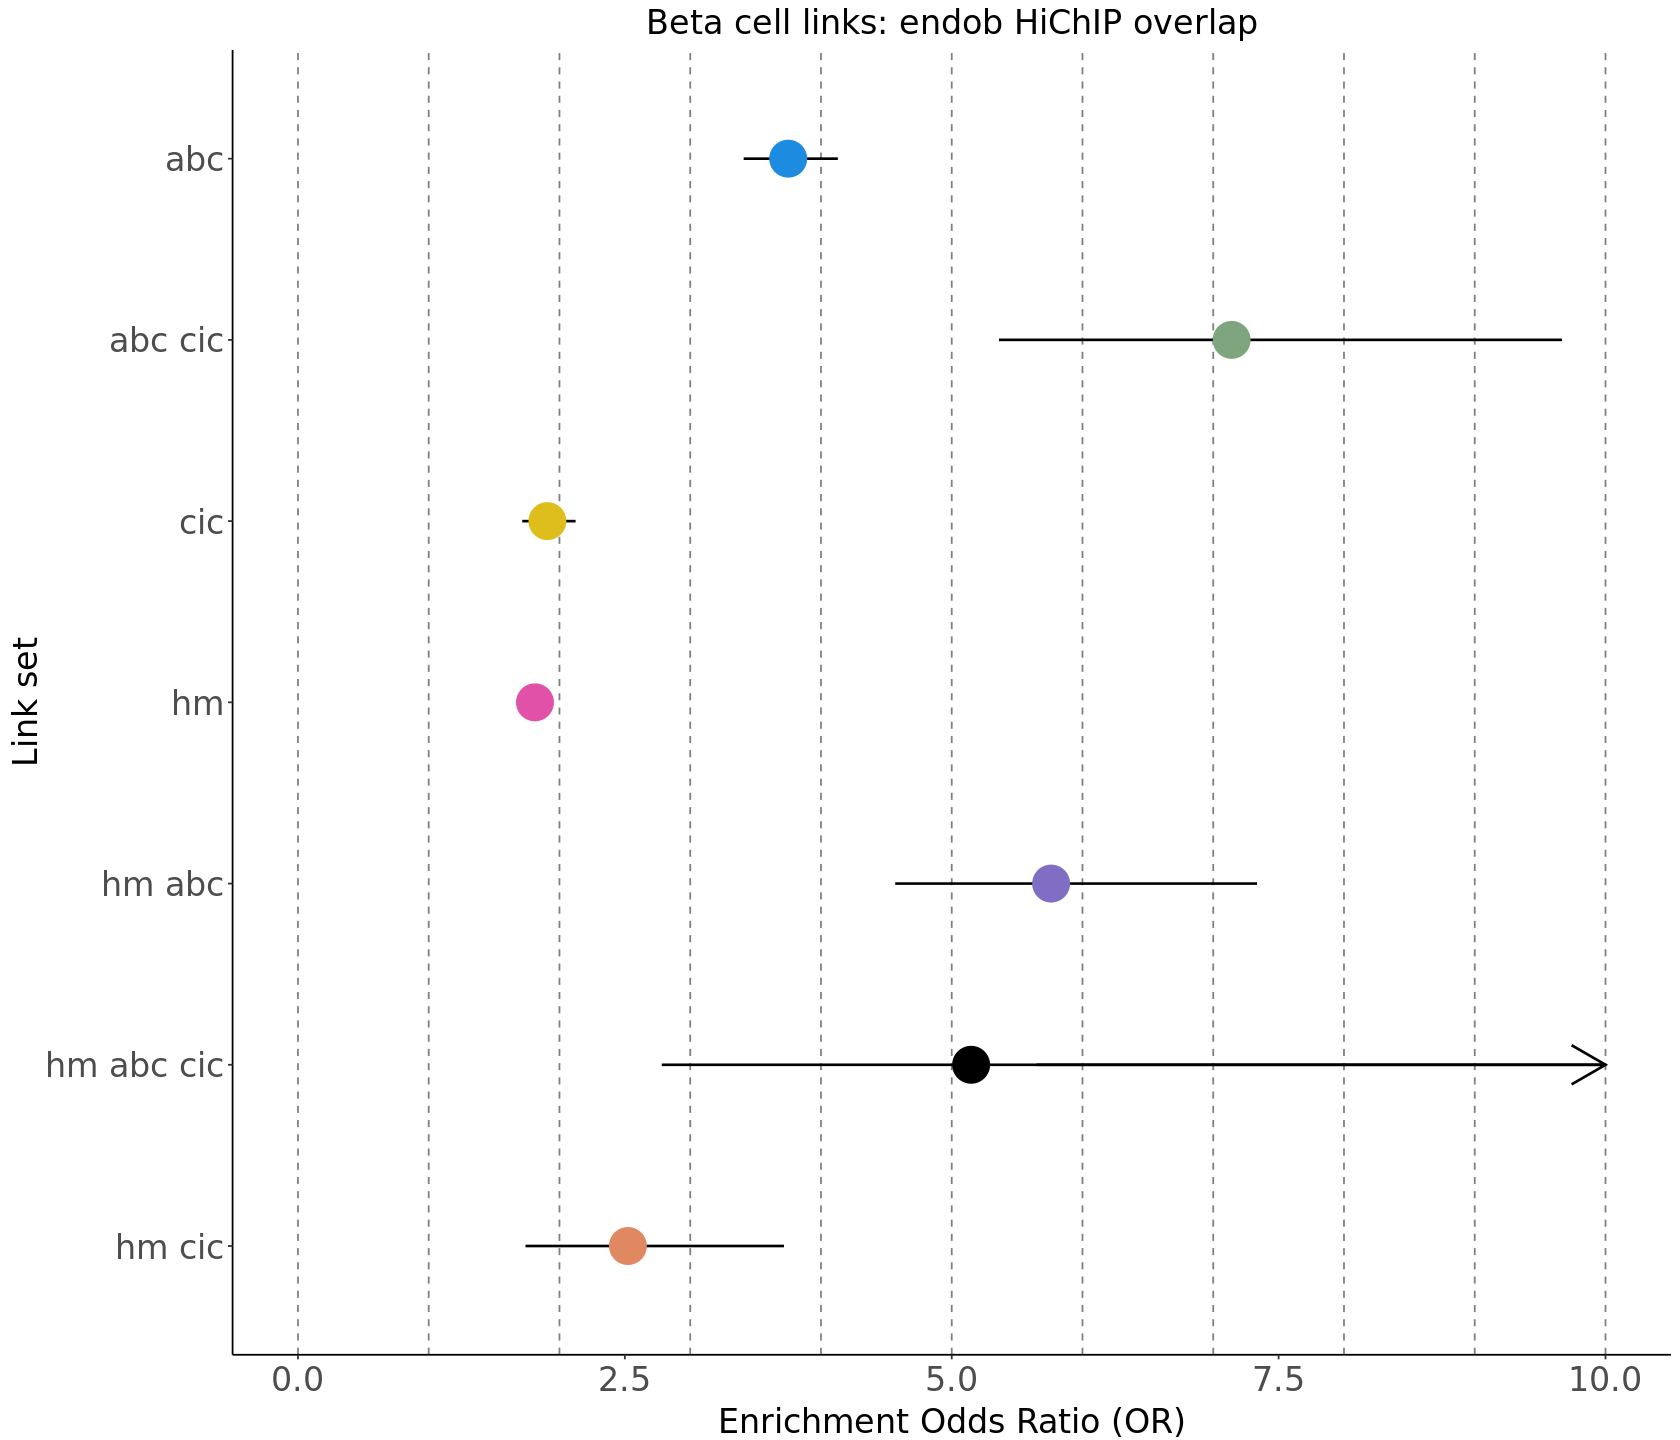

Warning message:
"Removed 6 rows containing missing values (`geom_segment()`)."


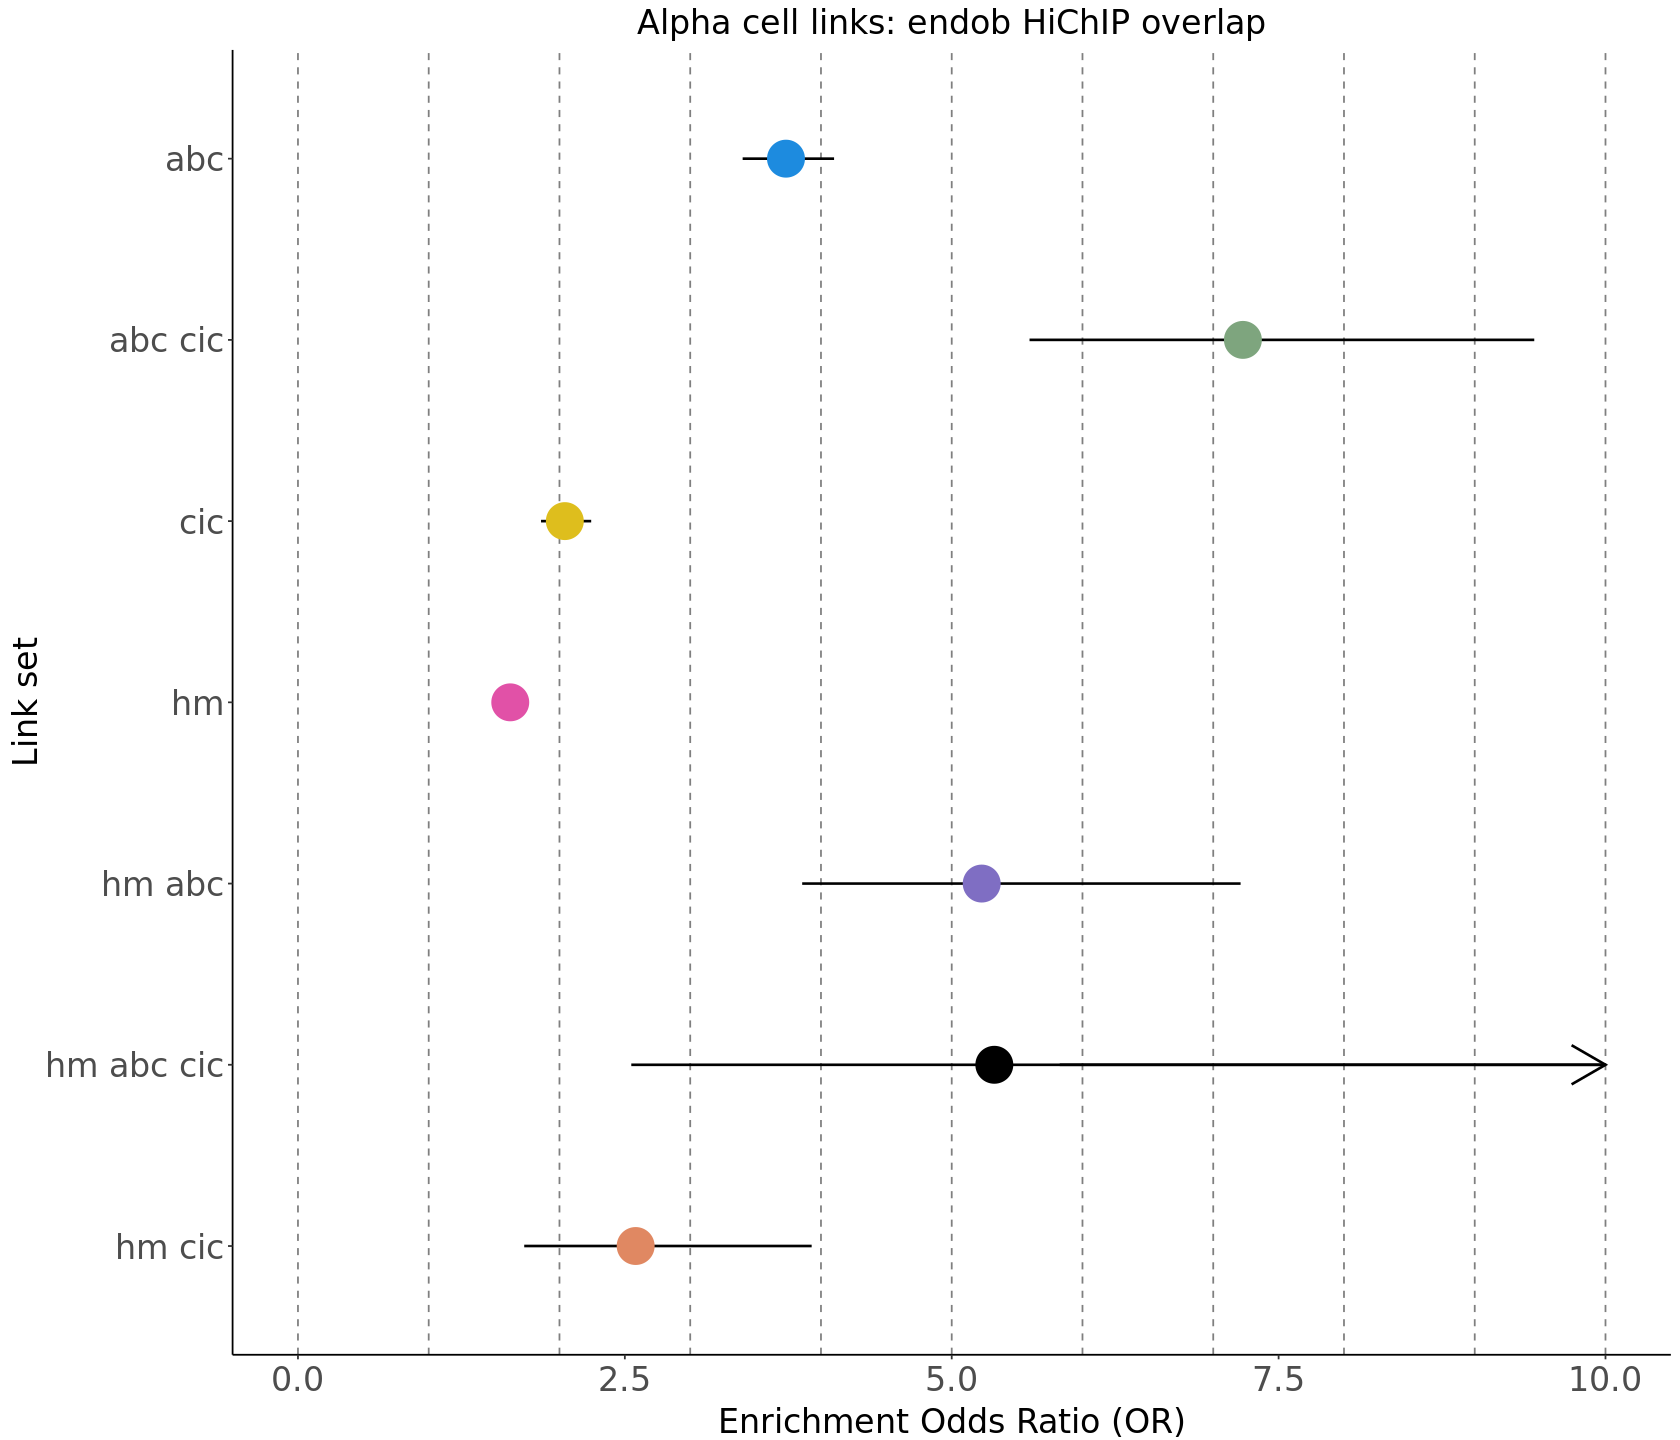

Warning message:
"Removed 6 rows containing missing values (`geom_segment()`)."


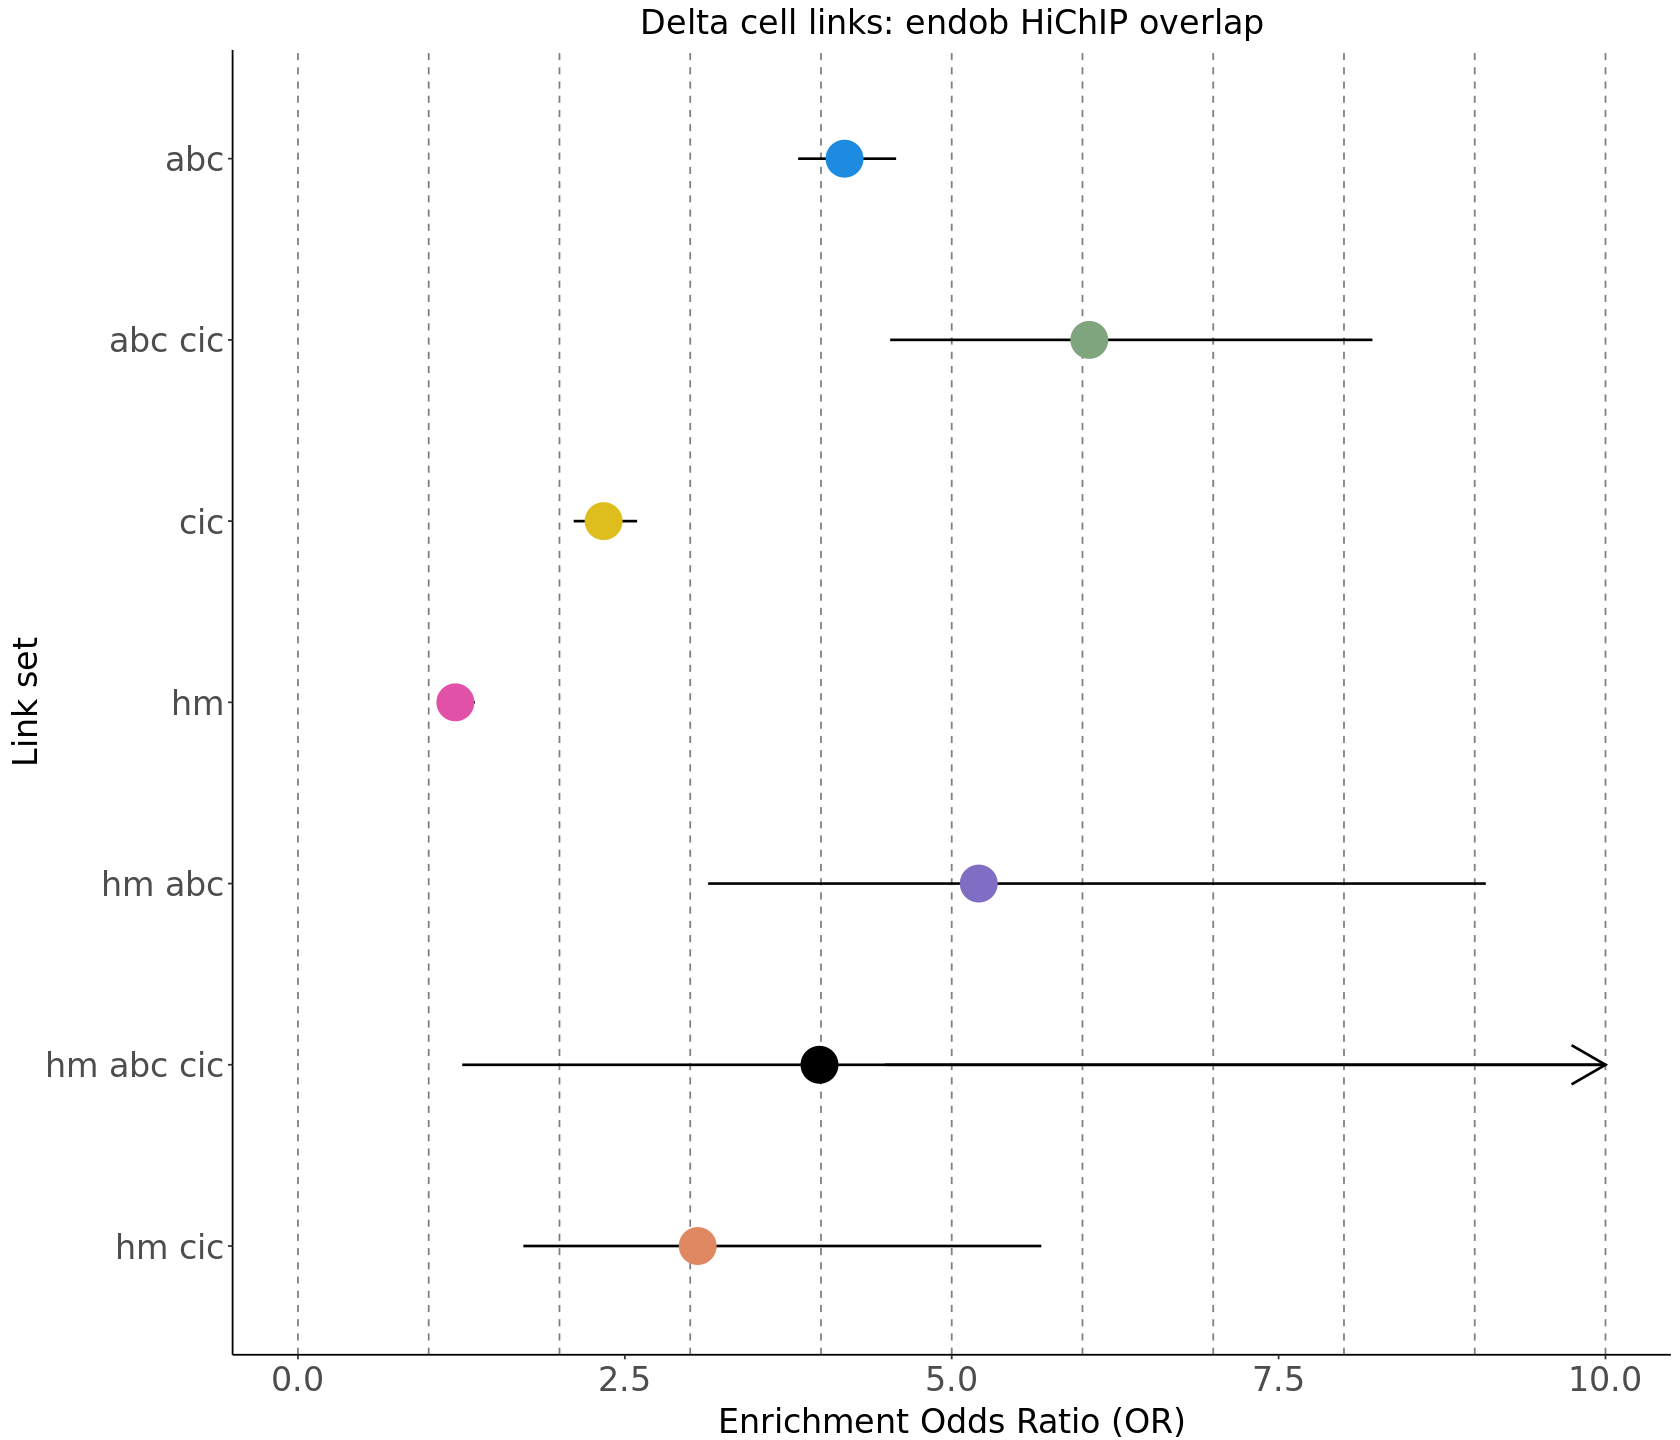

Warning message:
"Removed 6 rows containing missing values (`geom_segment()`)."


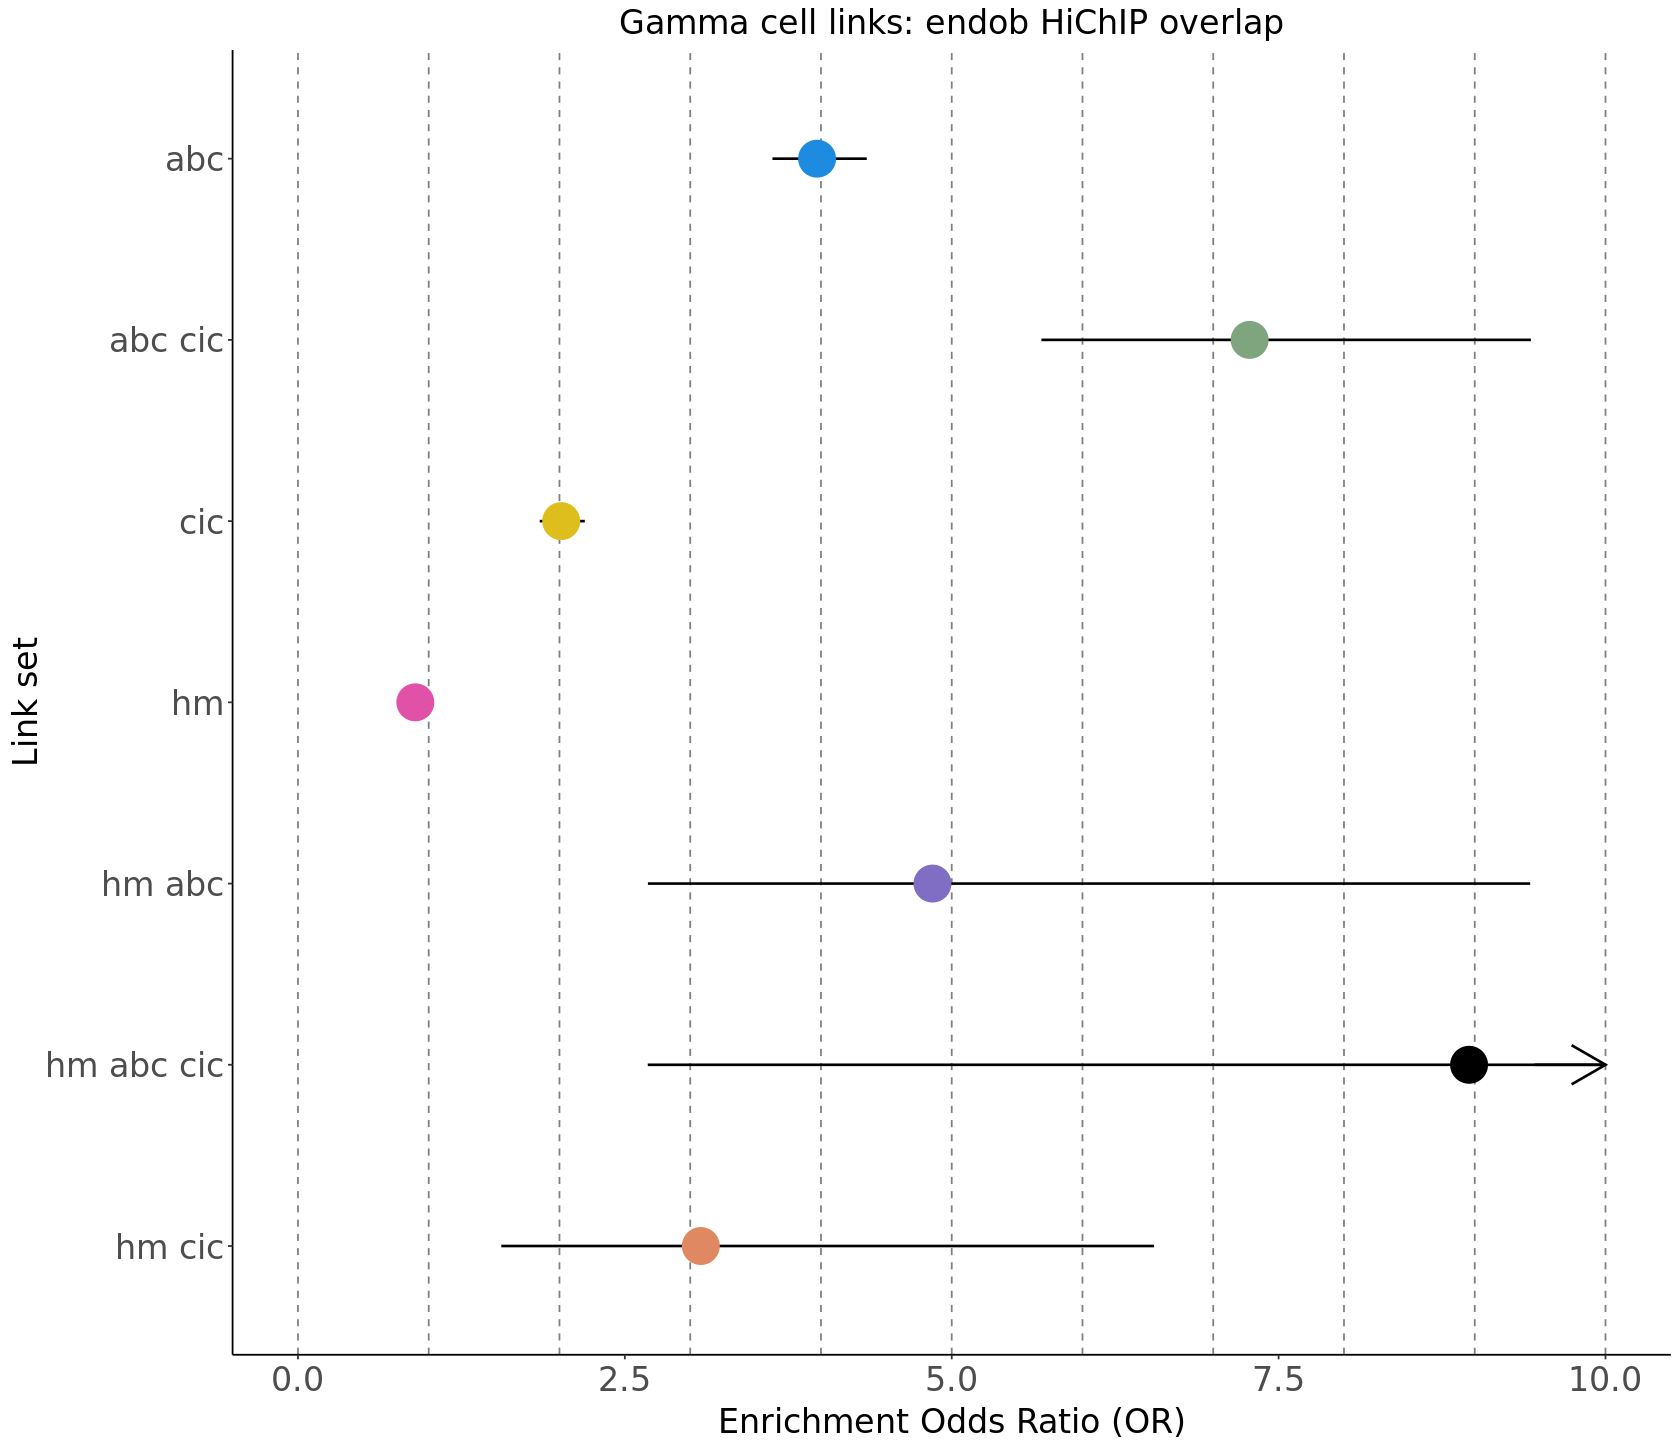

Warning message:
"Removed 6 rows containing missing values (`geom_segment()`)."


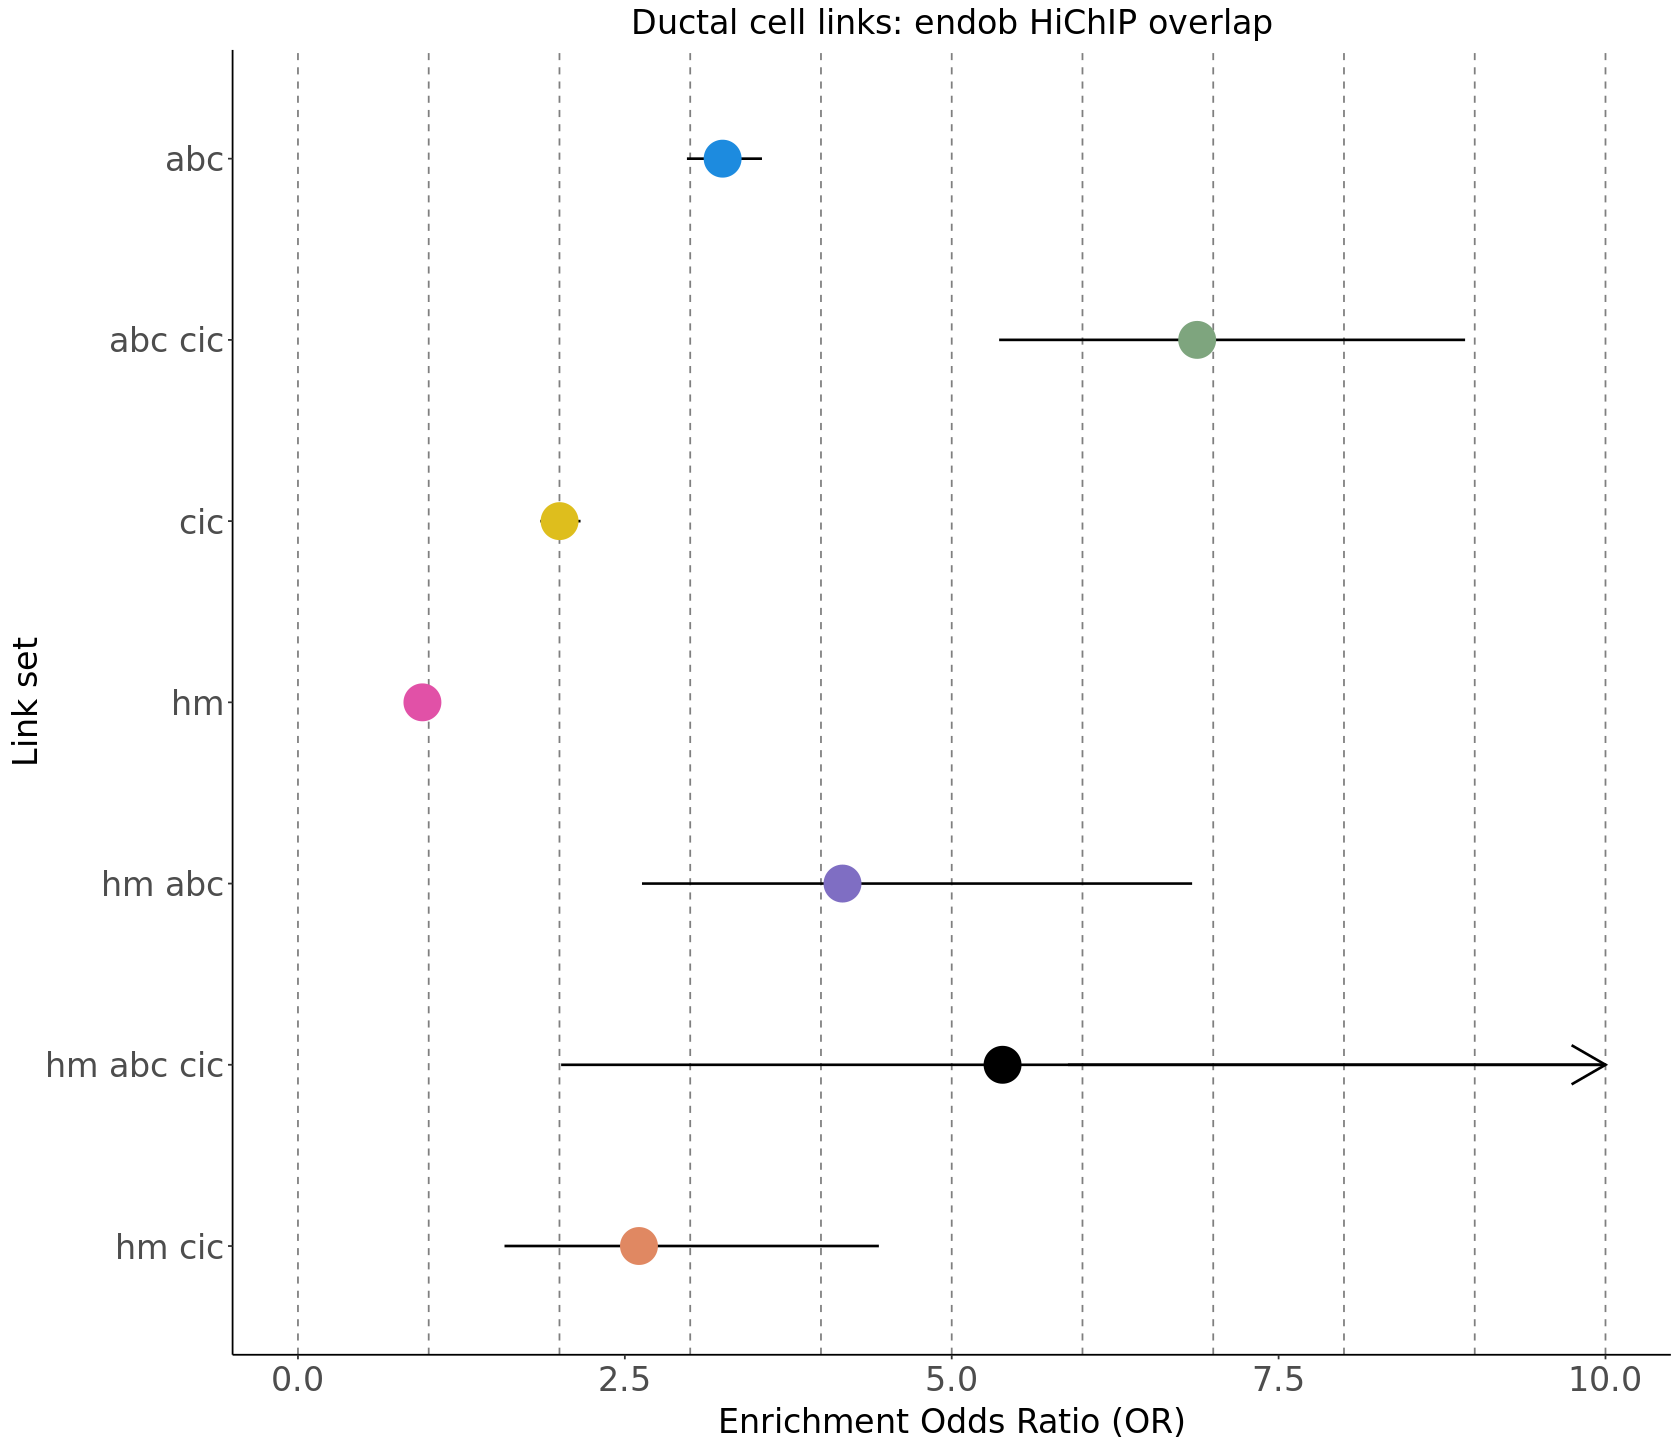

Warning message:
"Removed 4 rows containing missing values (`geom_segment()`)."


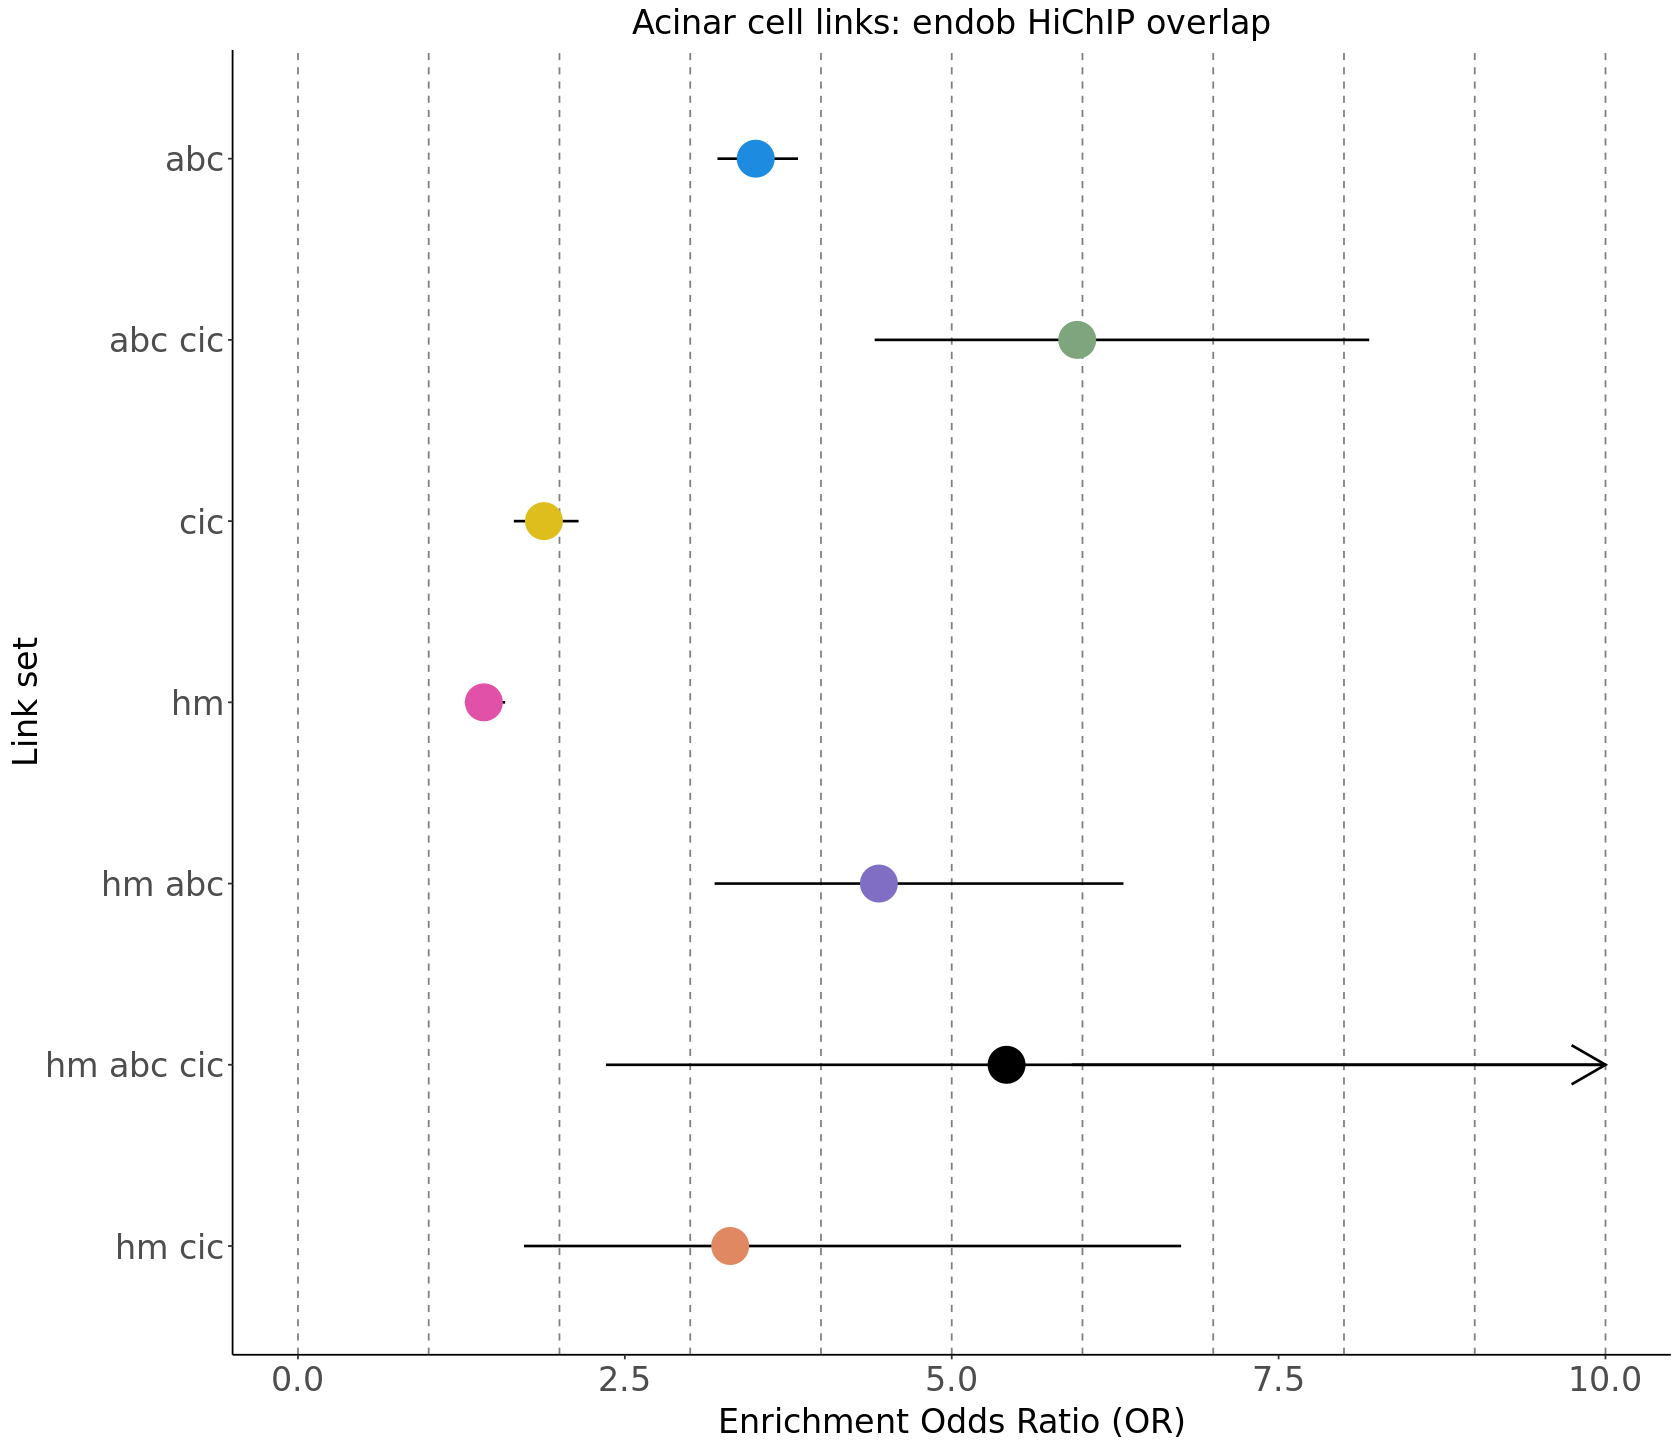

Warning message:
"Removed 4 rows containing missing values (`geom_segment()`)."


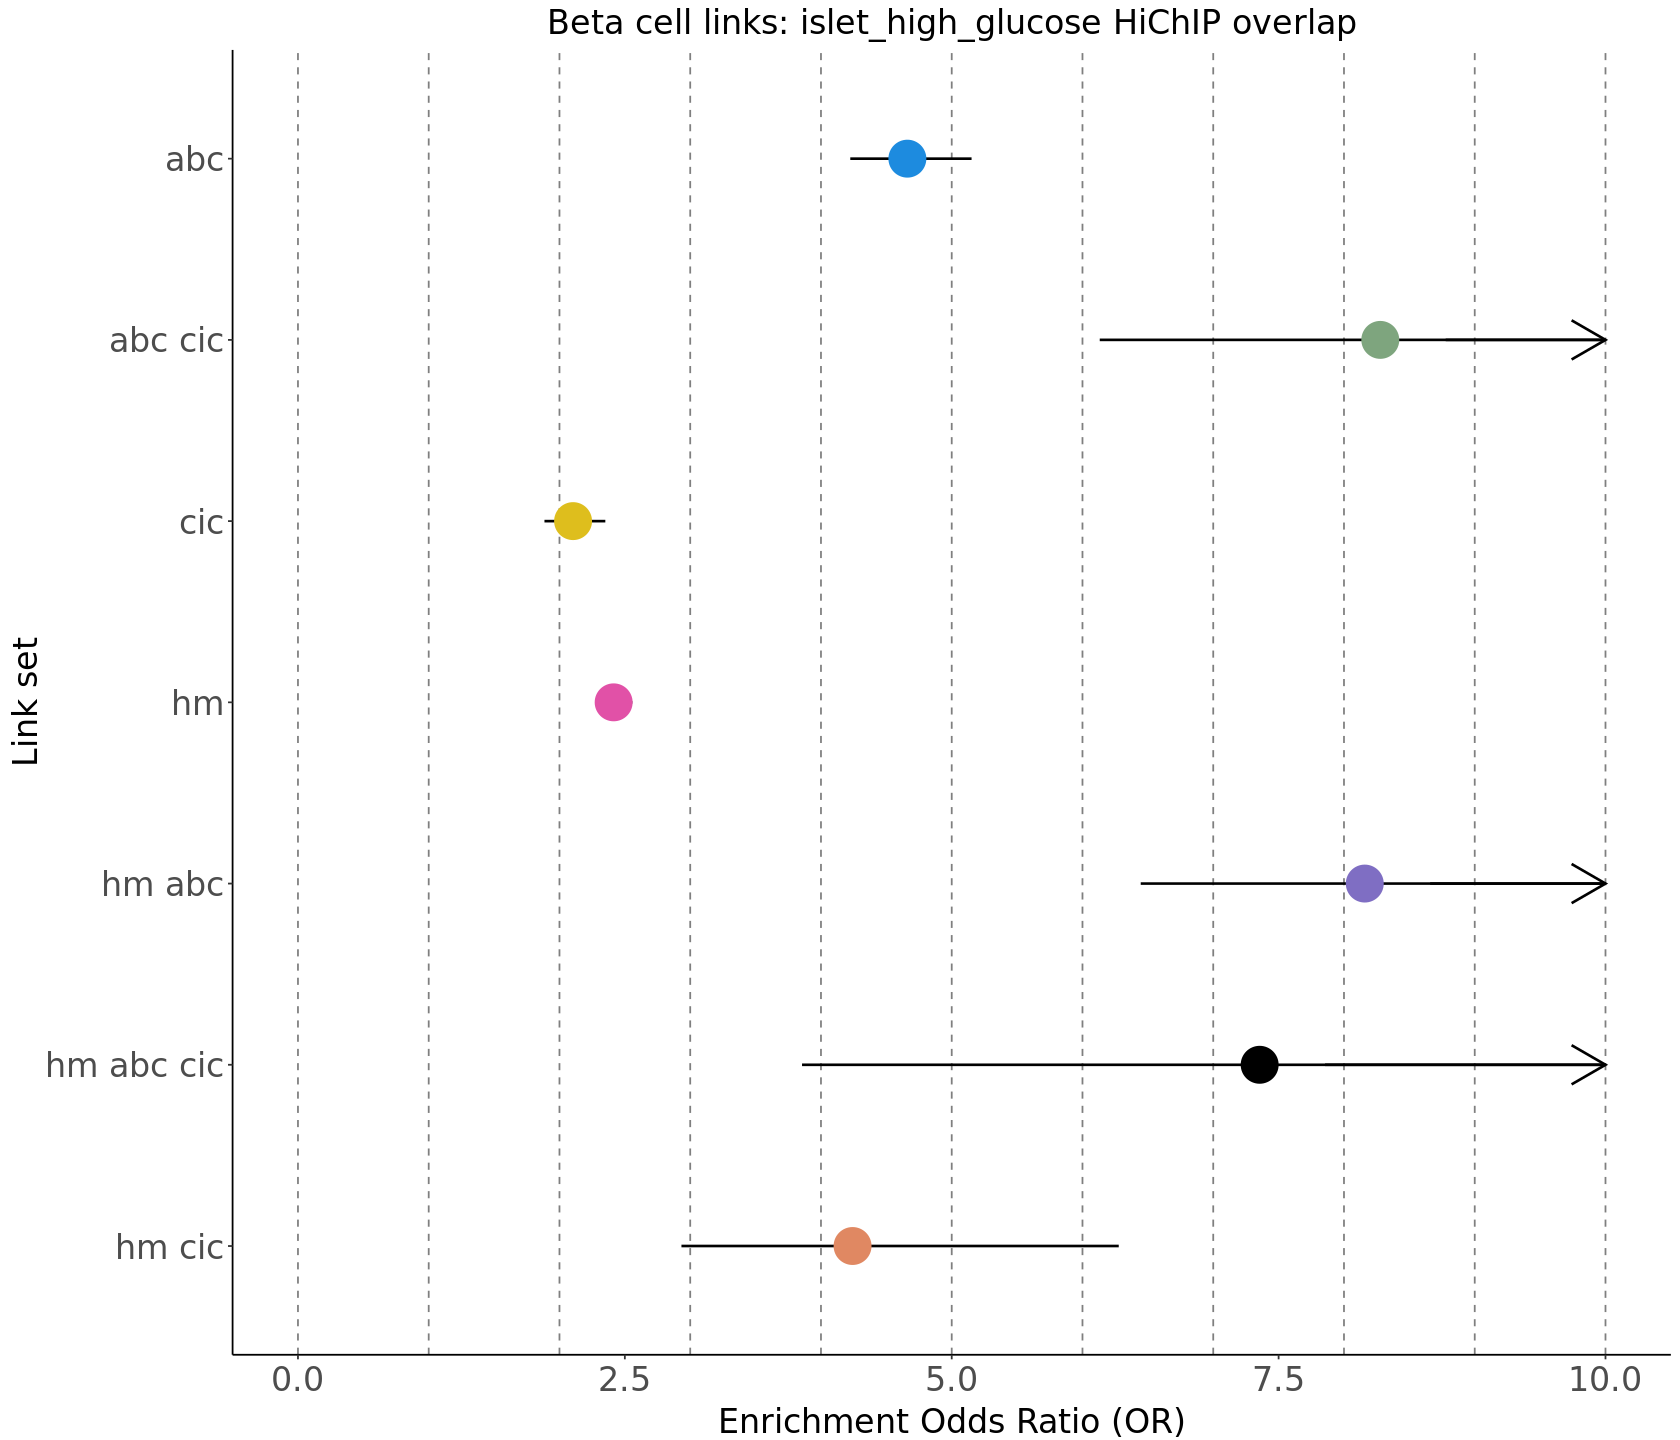

Warning message:
"Removed 3 rows containing missing values (`geom_segment()`)."


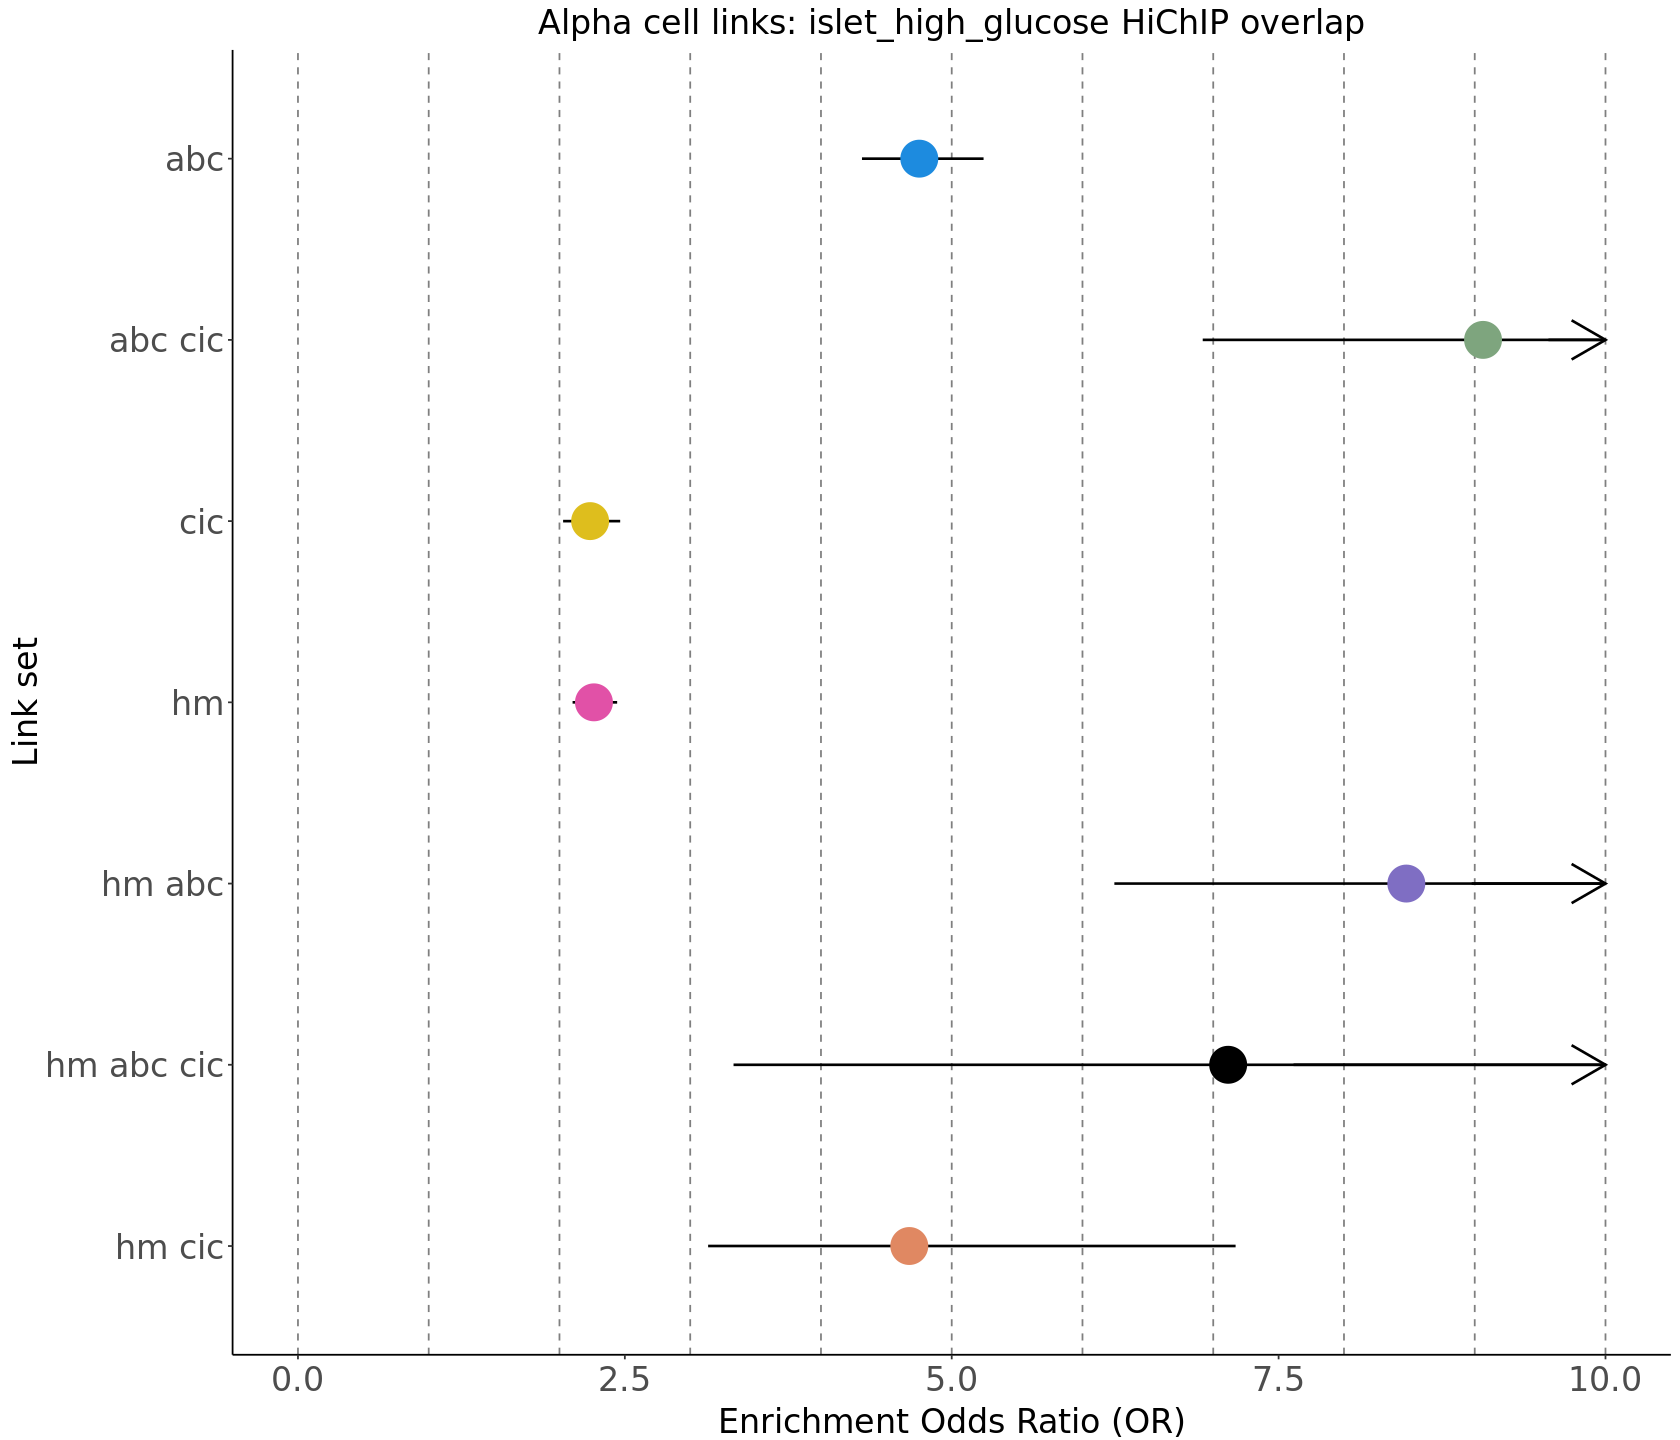

[1] "hm_abc_cic"


Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 5 rows containing missing values (`geom_segment()`)."


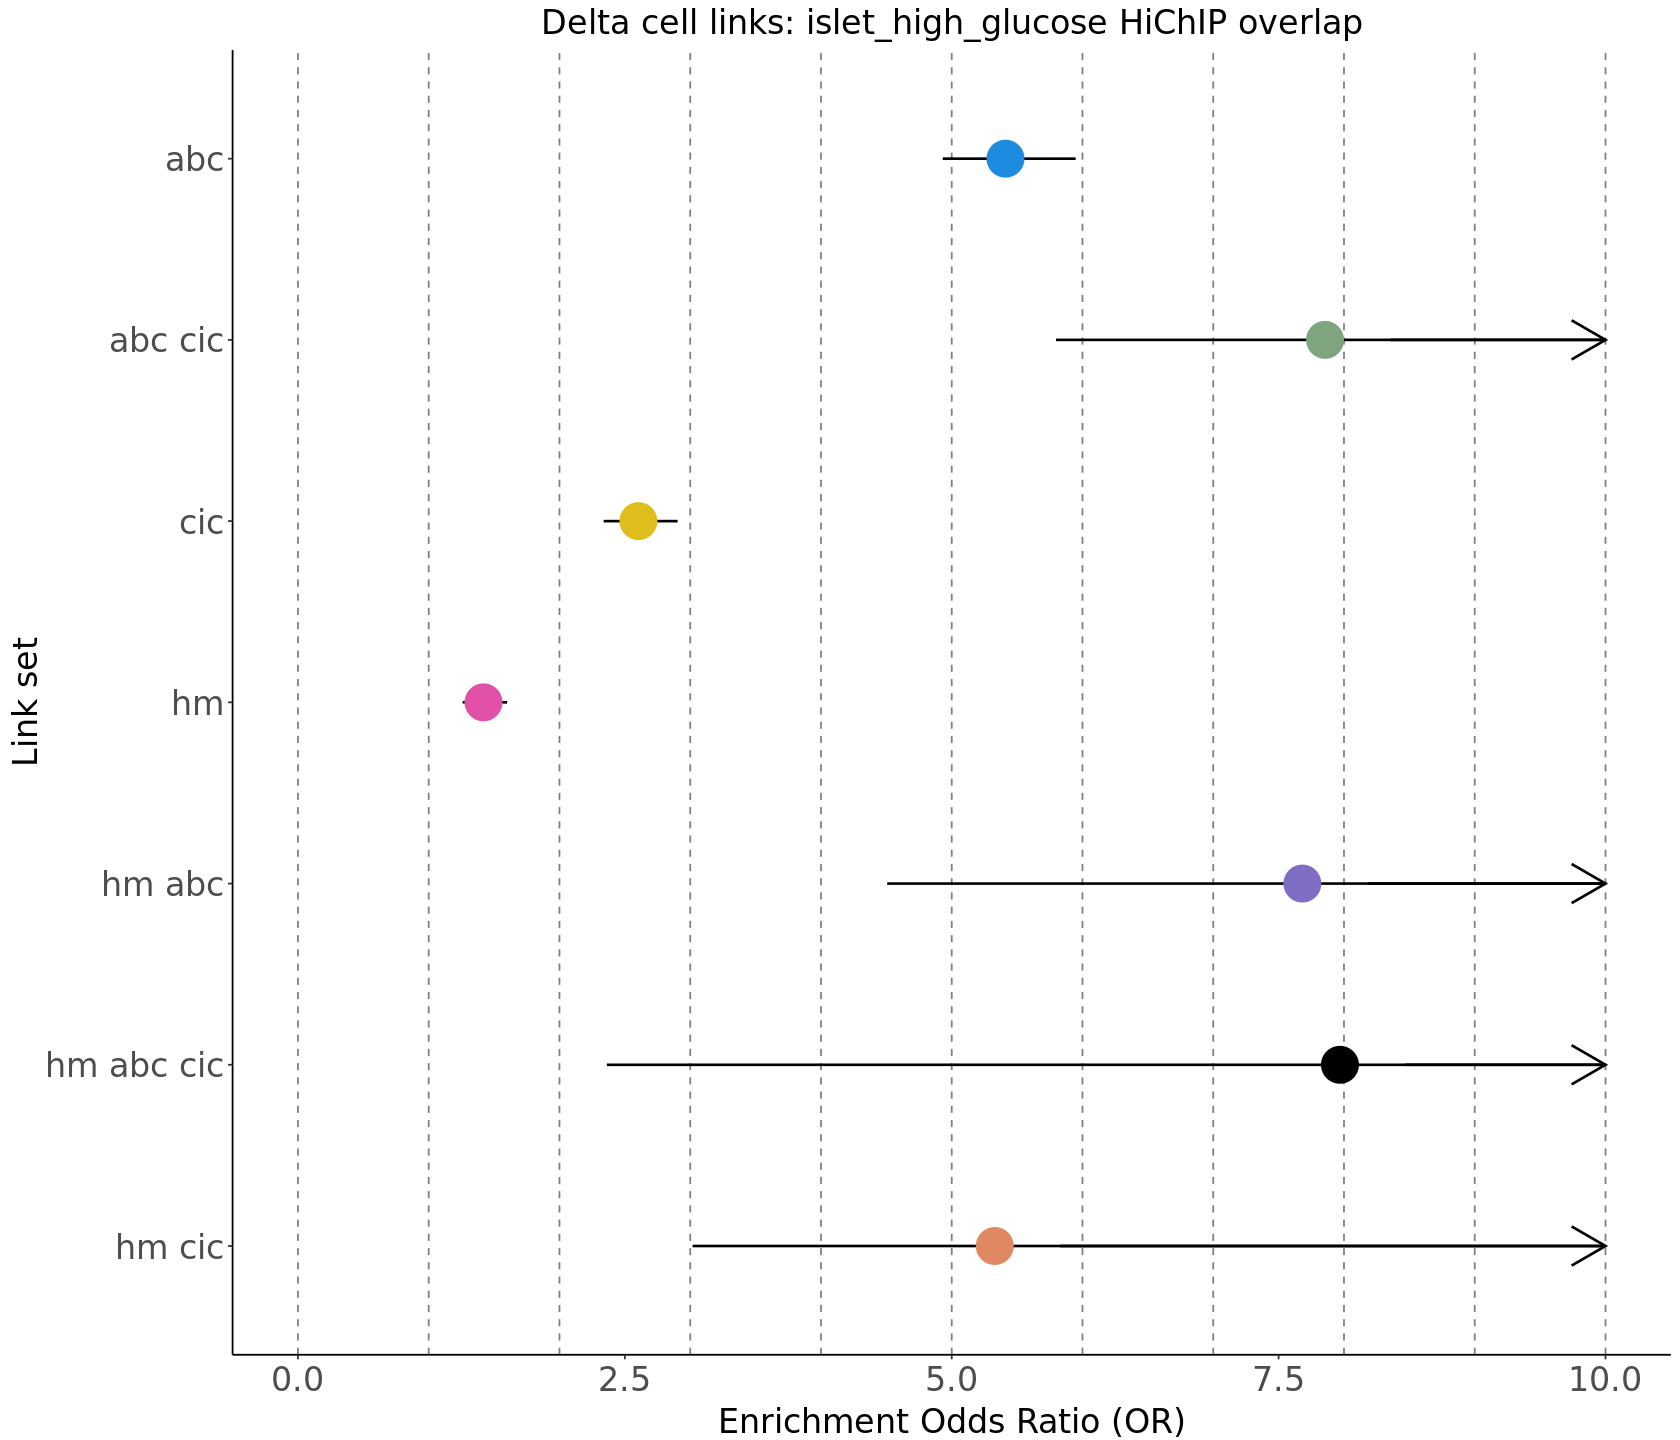

Warning message:
"Removed 5 rows containing missing values (`geom_segment()`)."


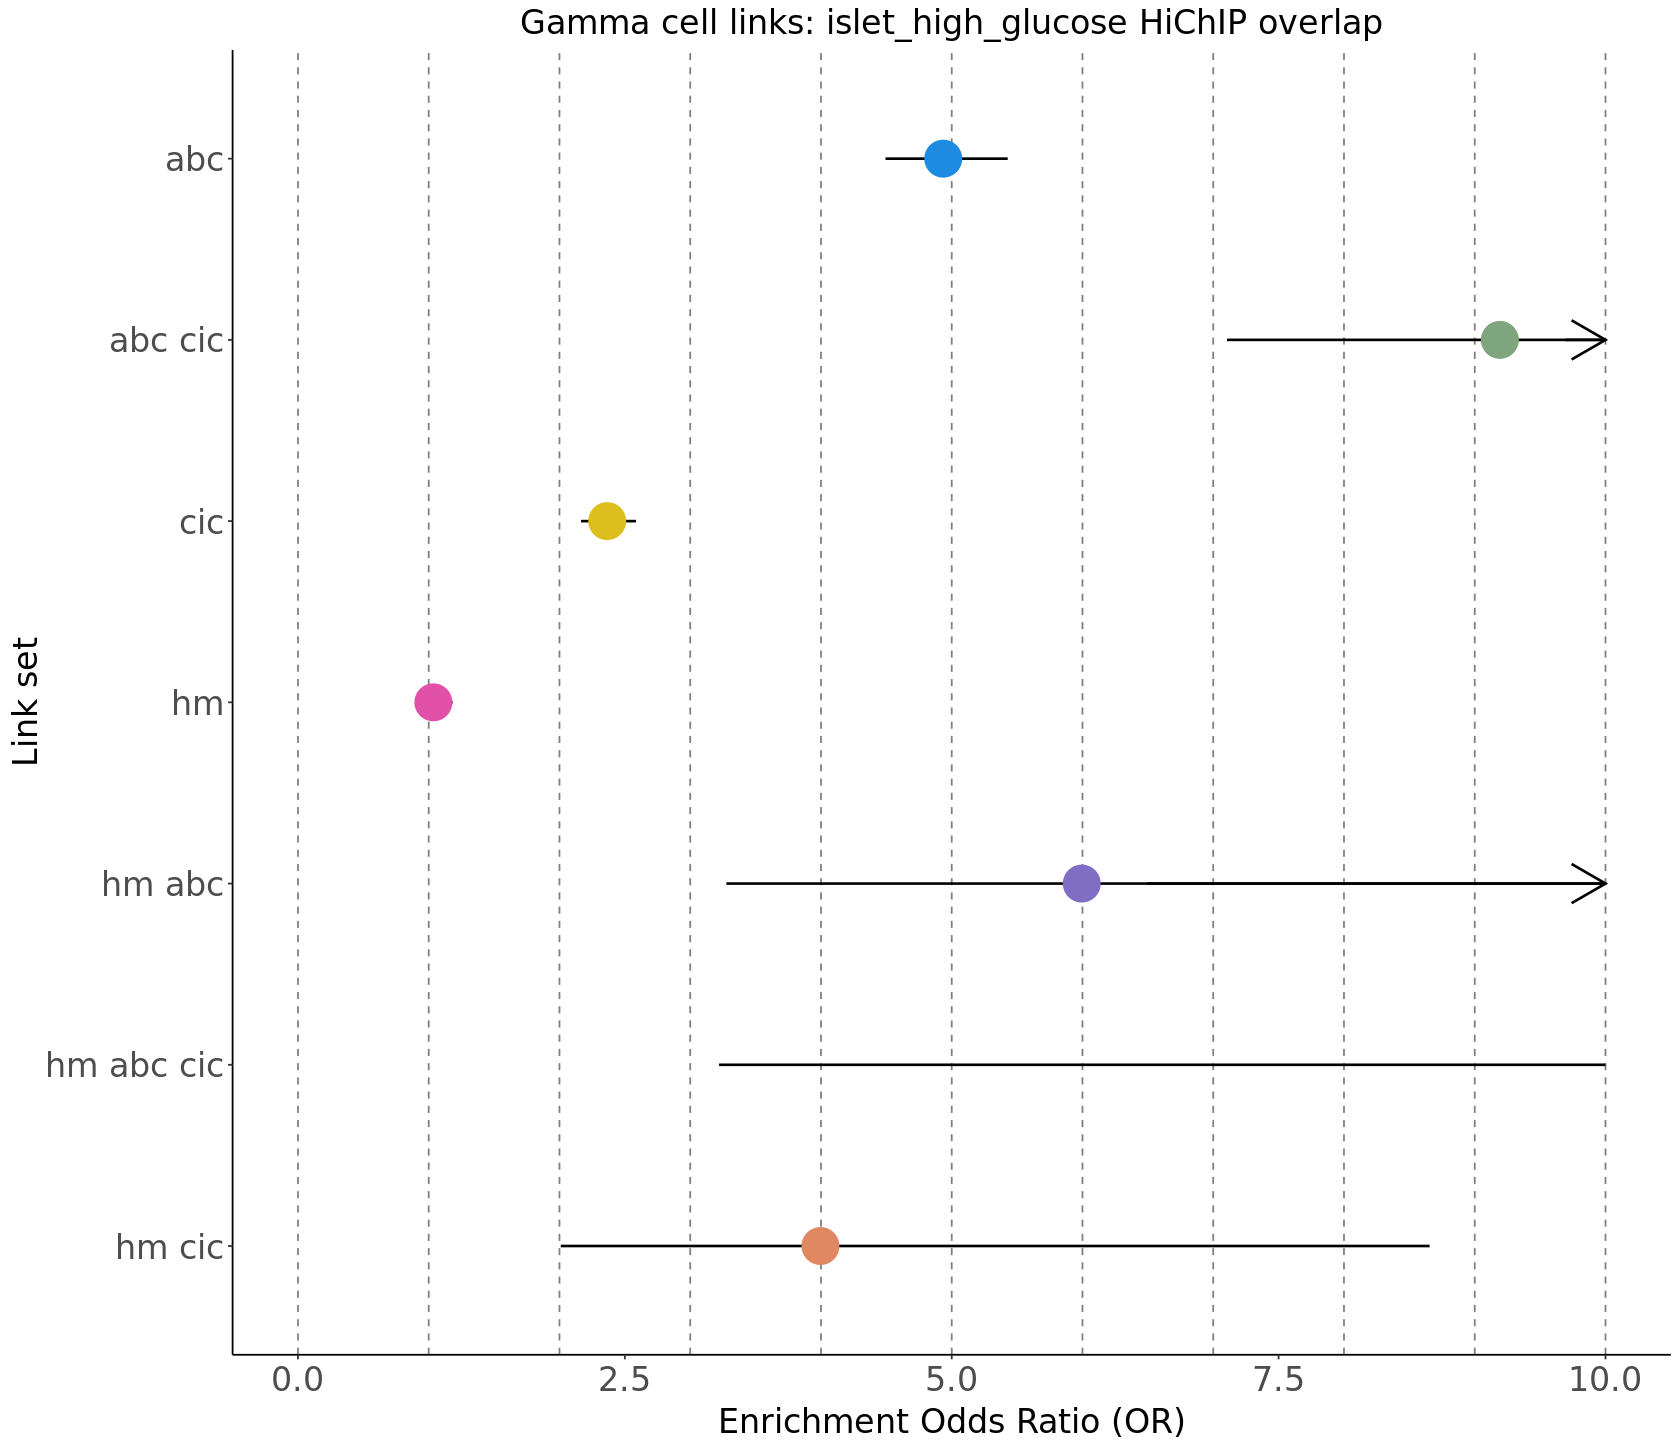

Warning message:
"Removed 4 rows containing missing values (`geom_segment()`)."


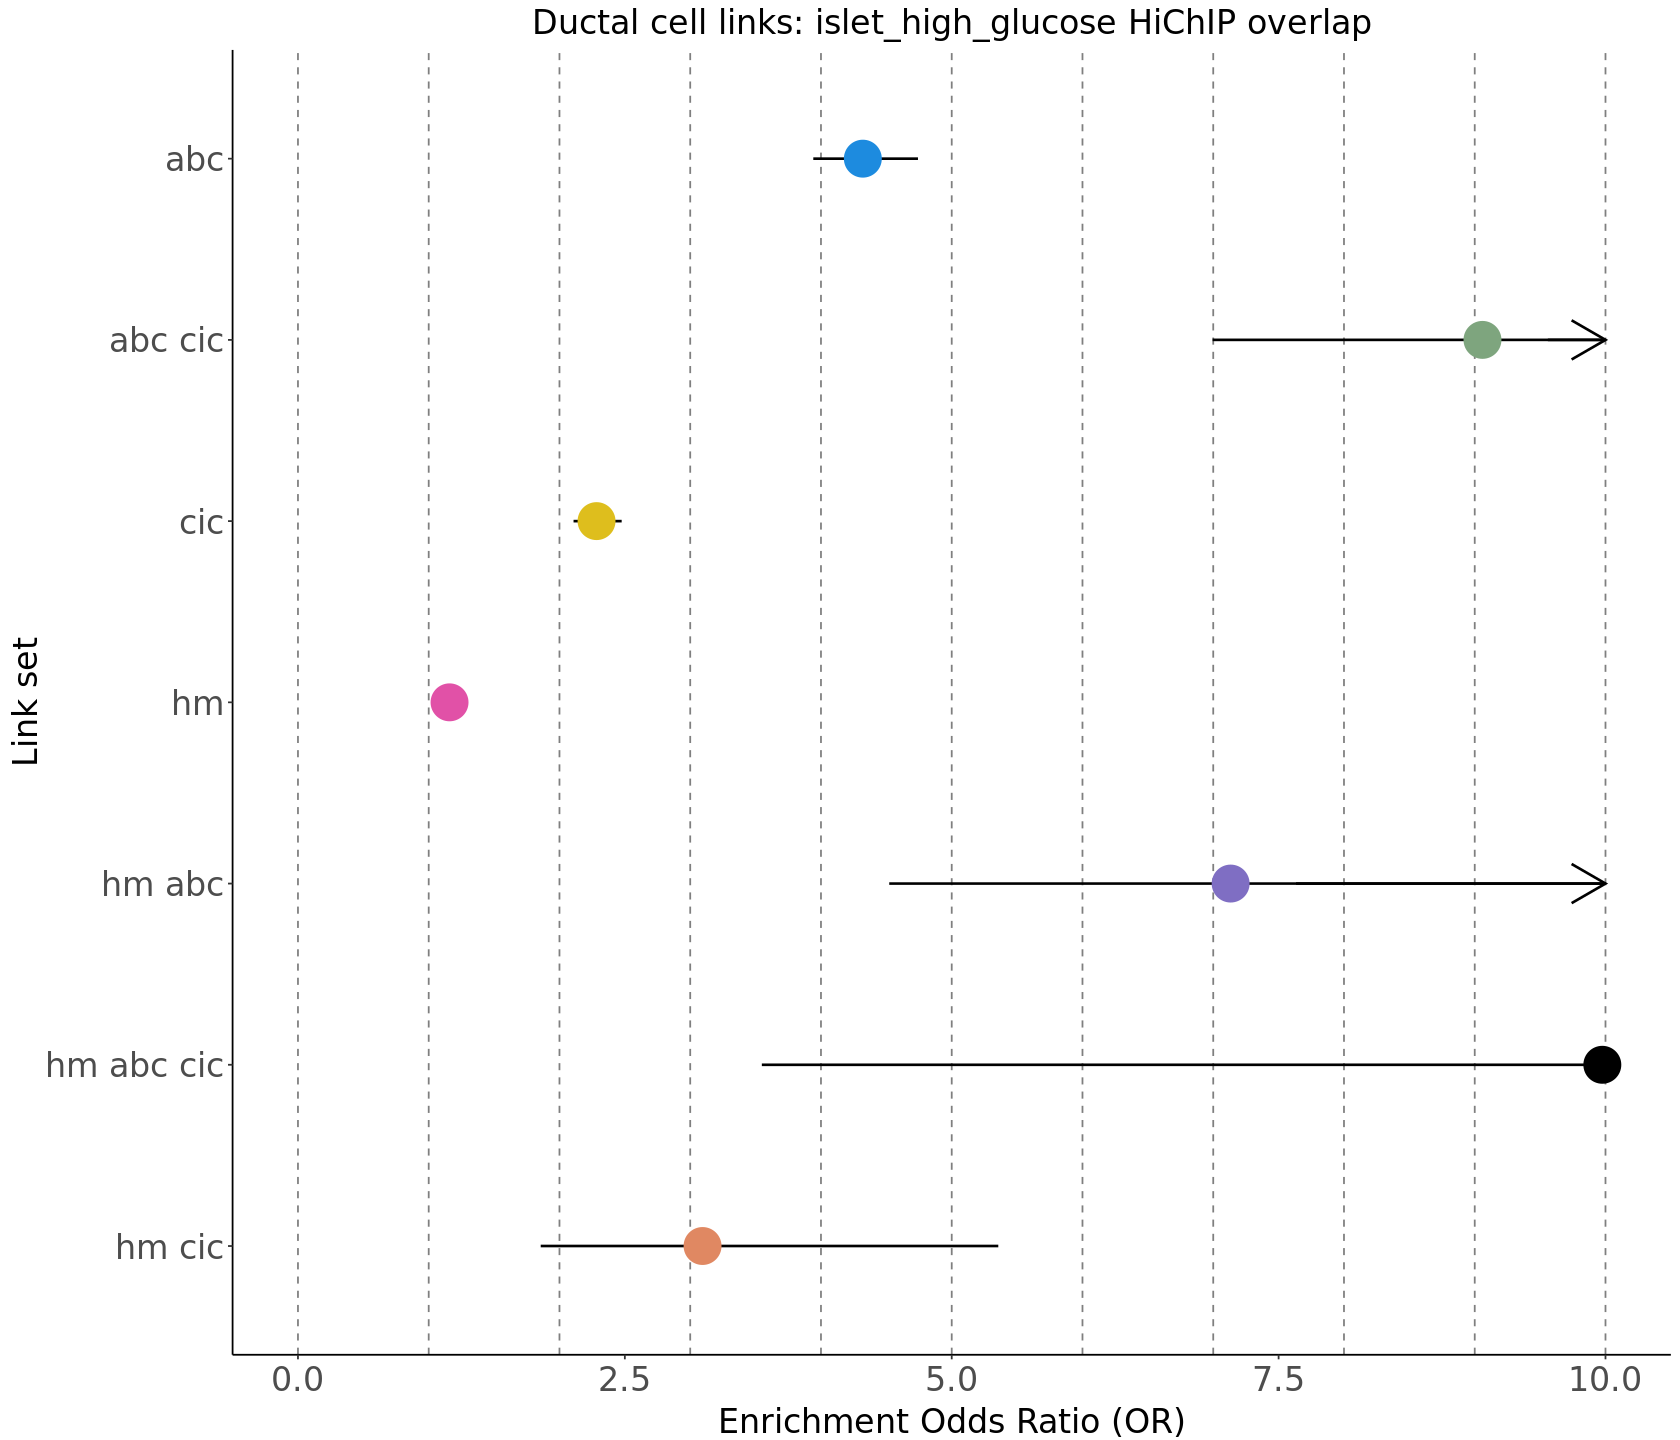

Warning message:
"Removed 5 rows containing missing values (`geom_segment()`)."


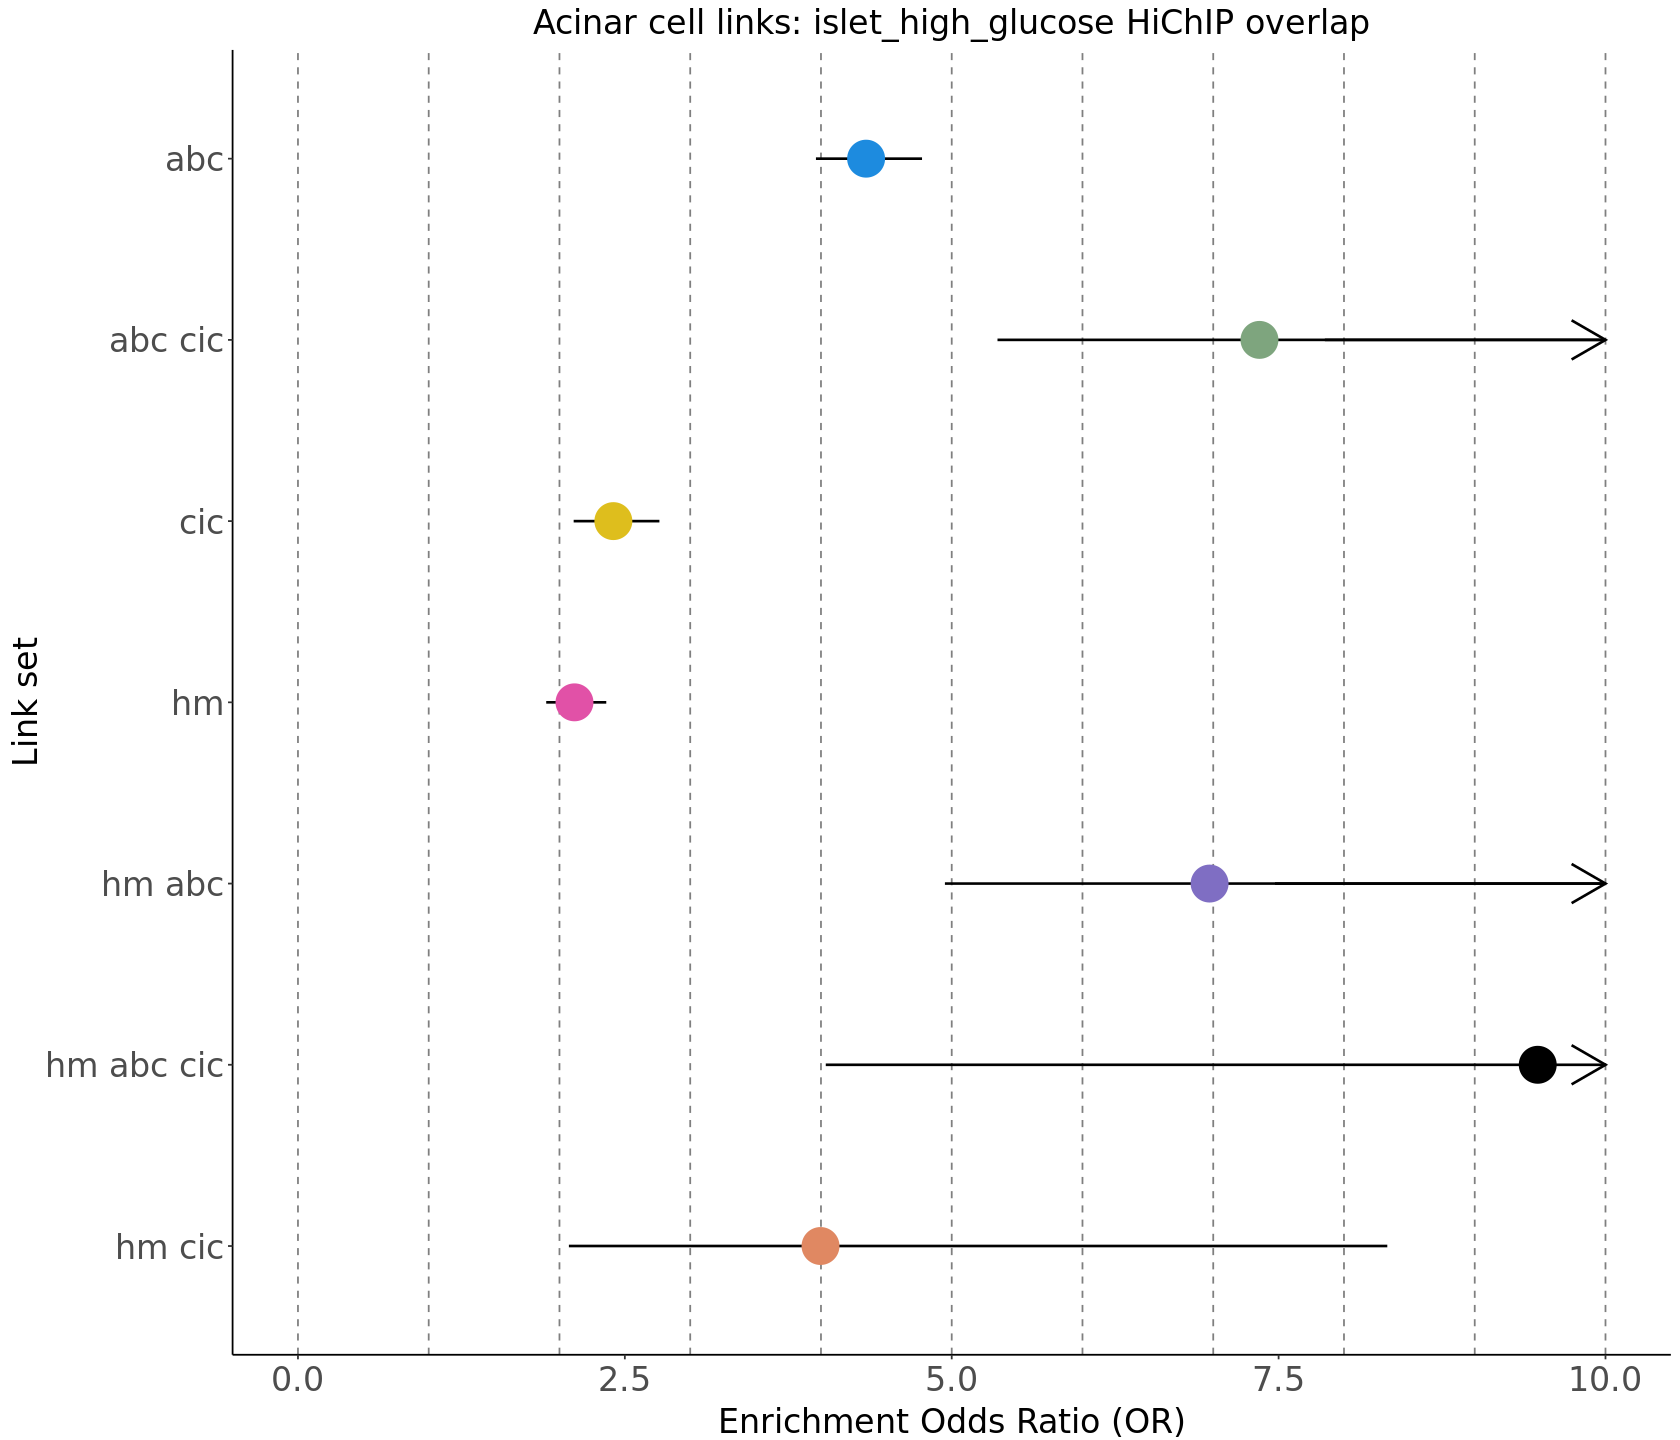

[1] "abc_cic"


Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 5 rows containing missing values (`geom_segment()`)."


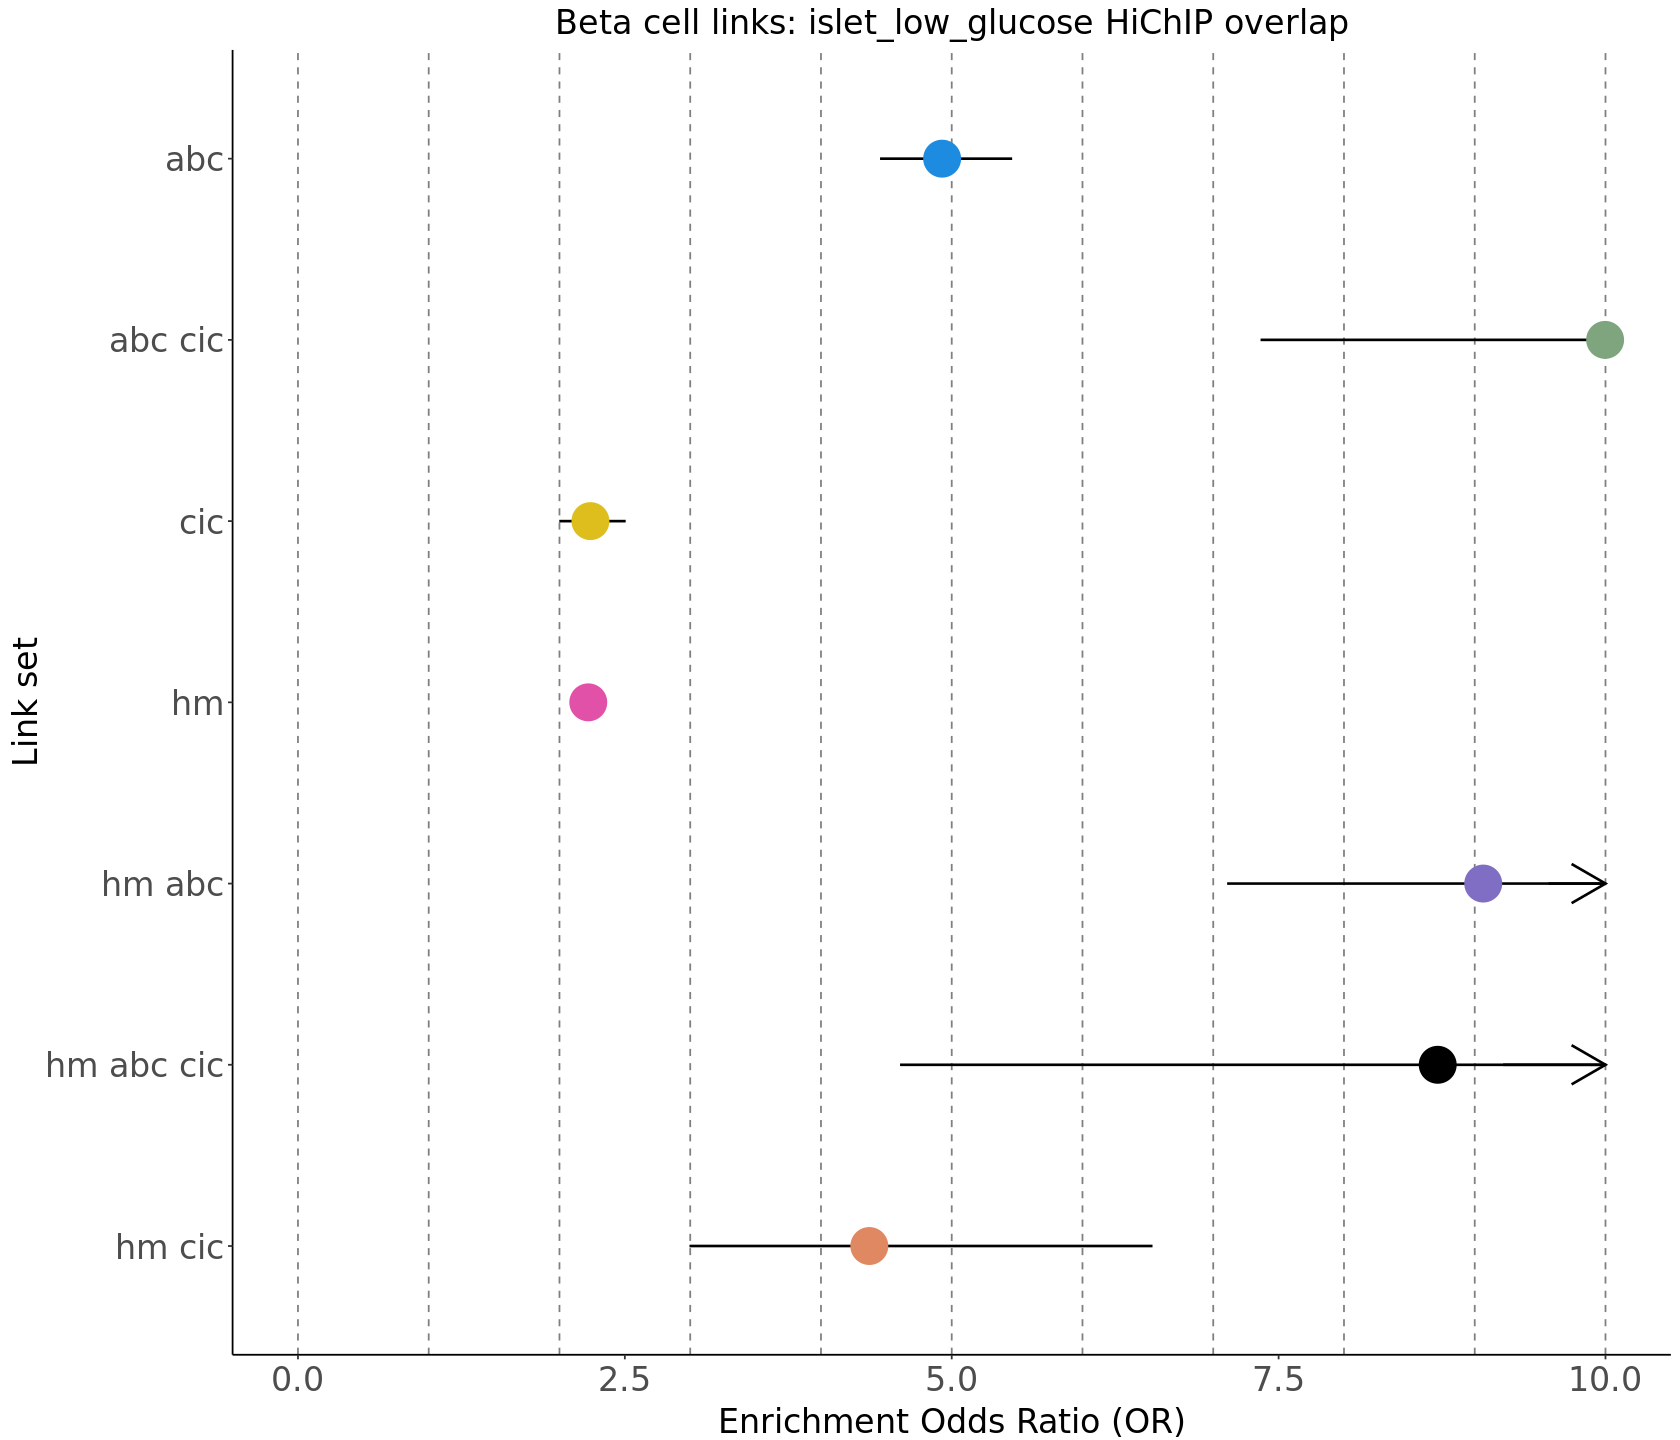

Warning message:
"Removed 4 rows containing missing values (`geom_segment()`)."


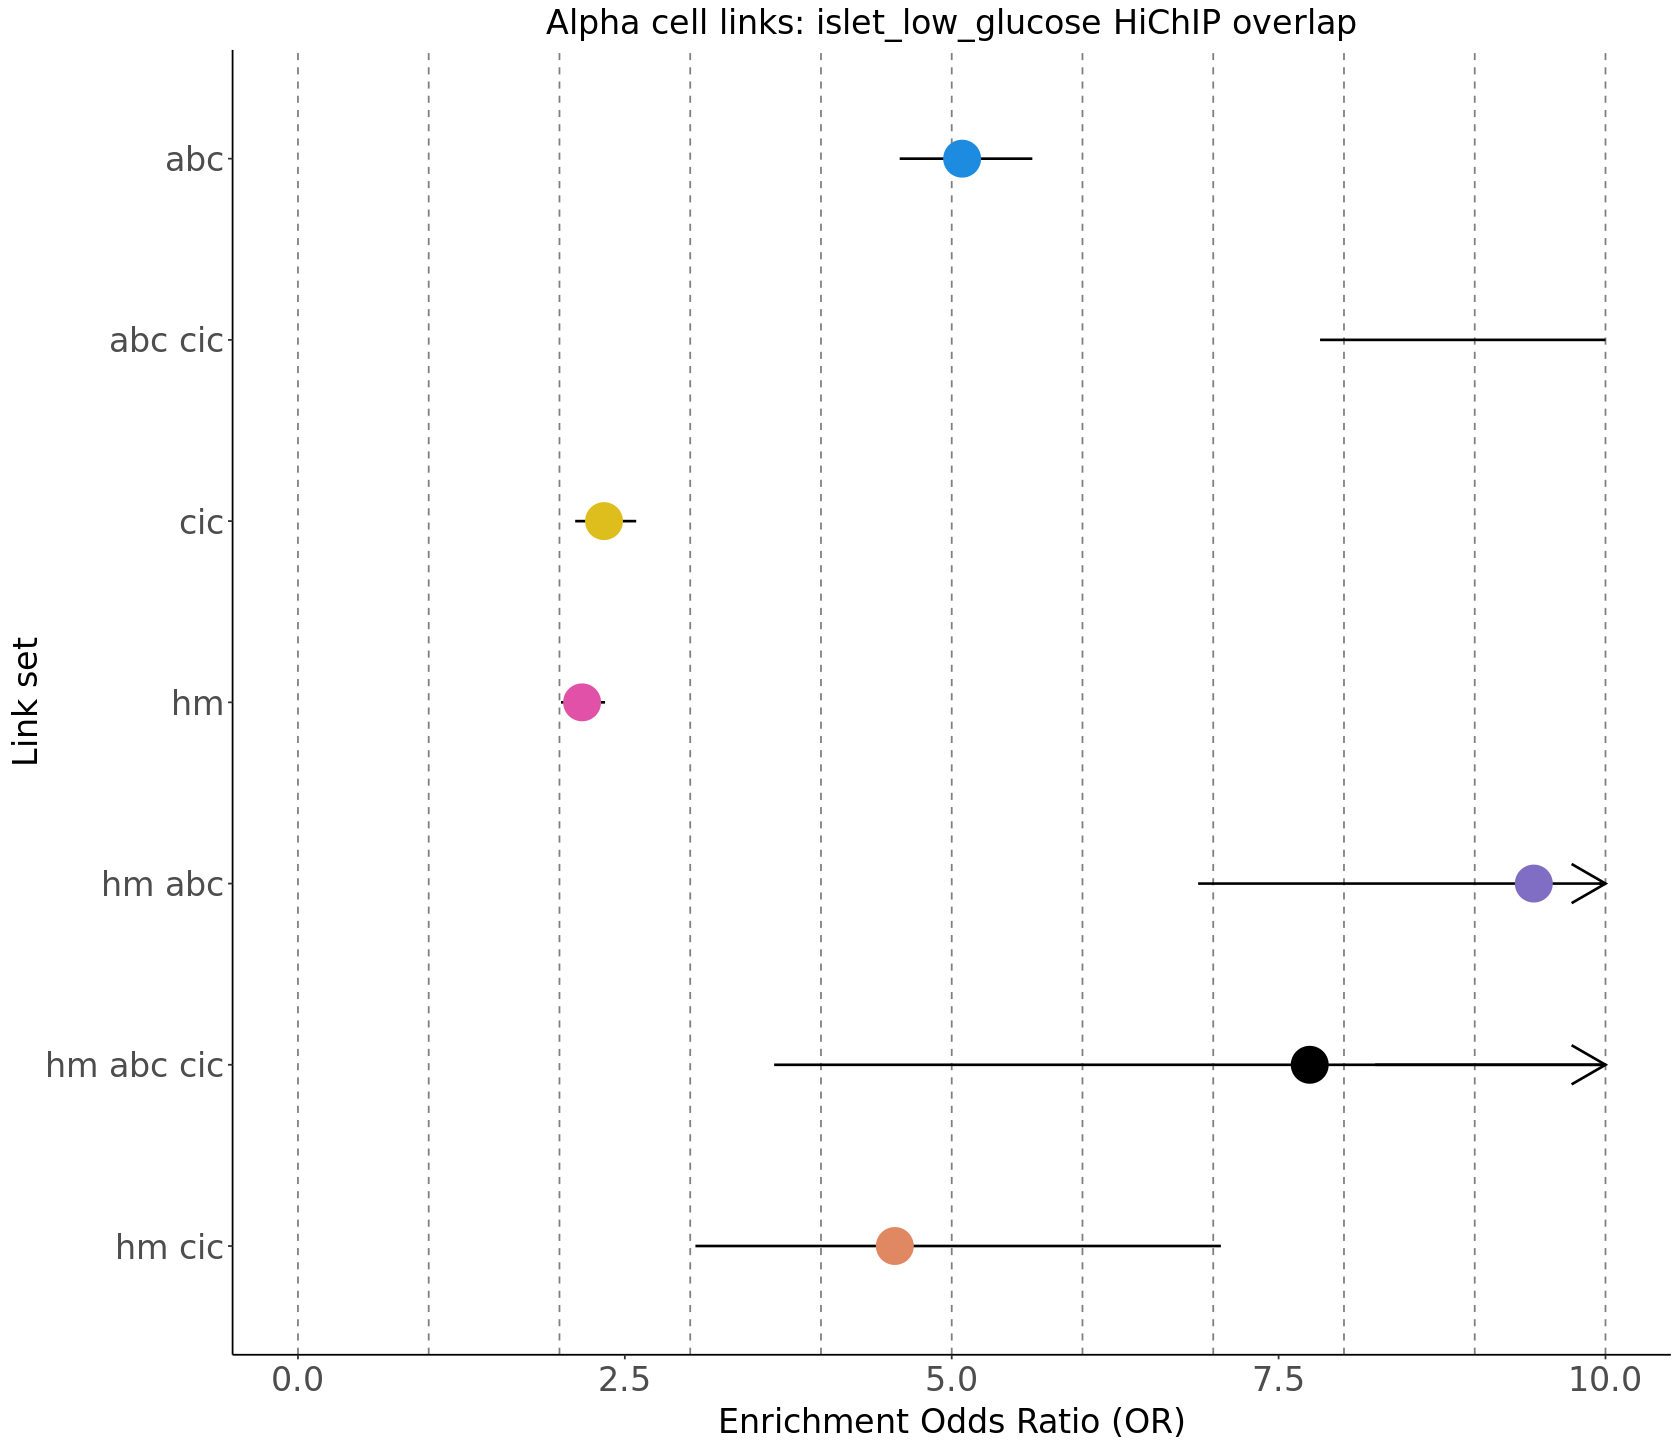

[1] "abc_cic"


Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 5 rows containing missing values (`geom_segment()`)."


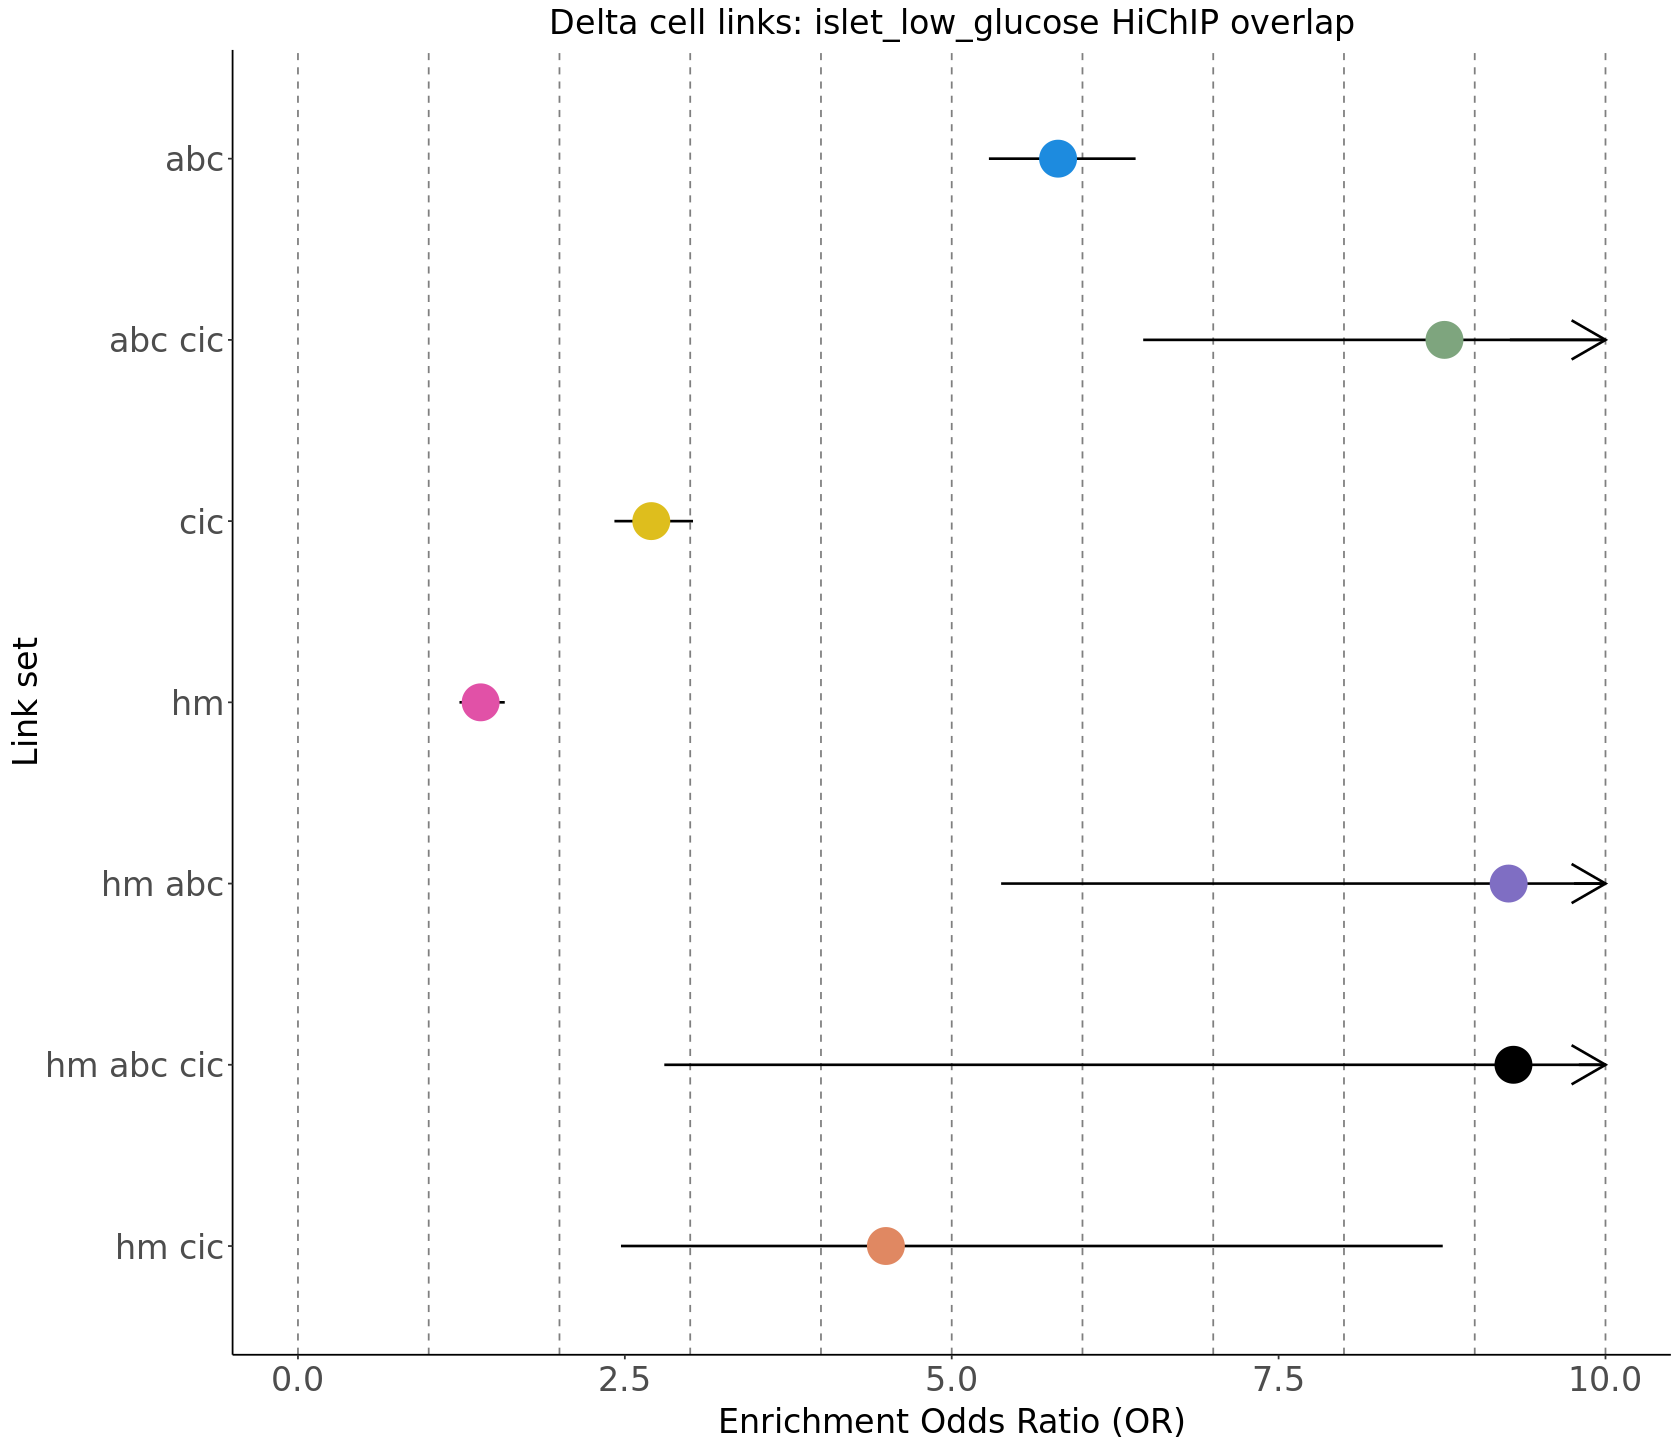

[1] "abc_cic"    "hm_abc_cic"


Warning message:
"Removed 2 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_segment()`)."


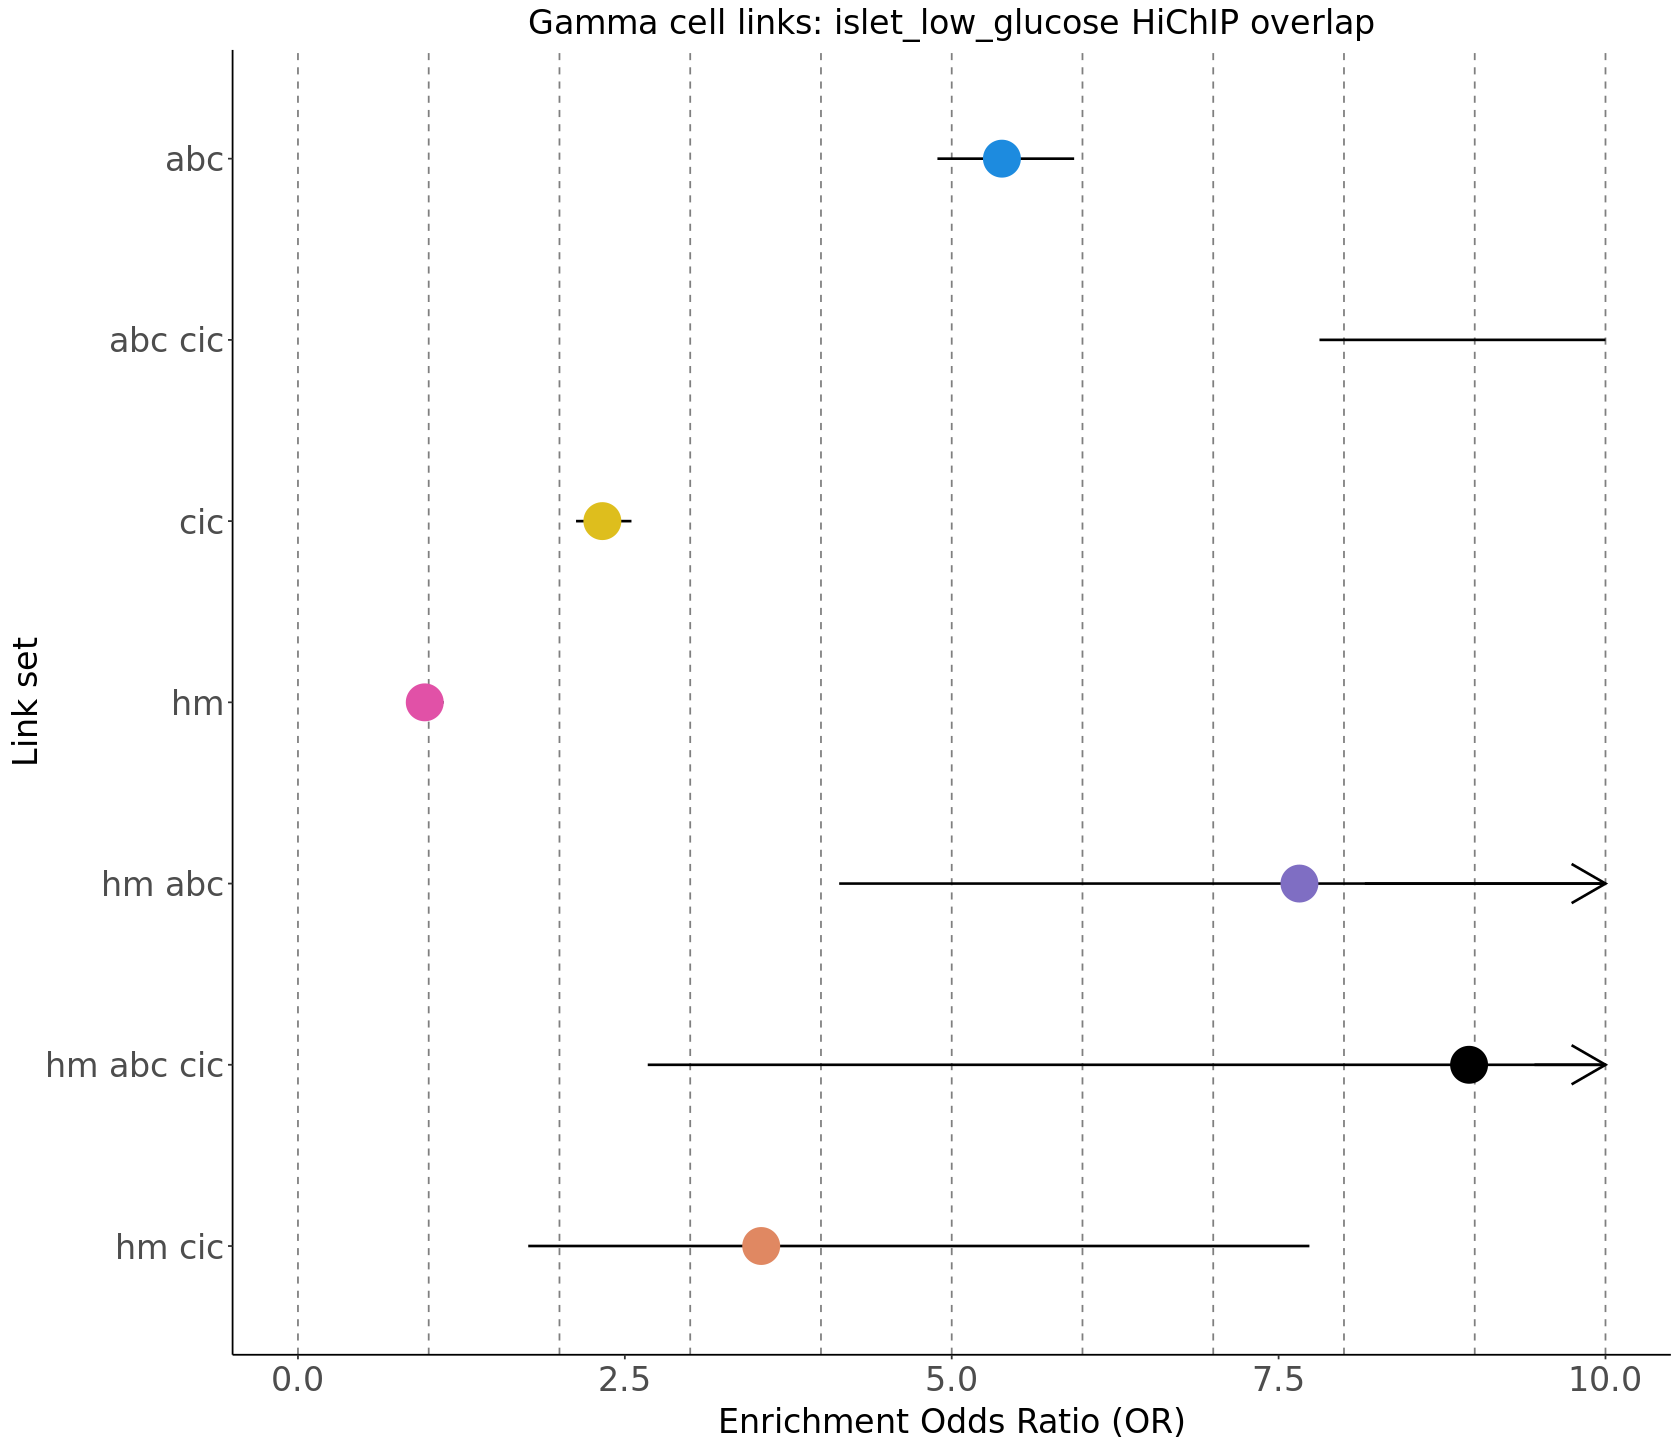

[1] "hm_abc_cic"


Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 4 rows containing missing values (`geom_segment()`)."


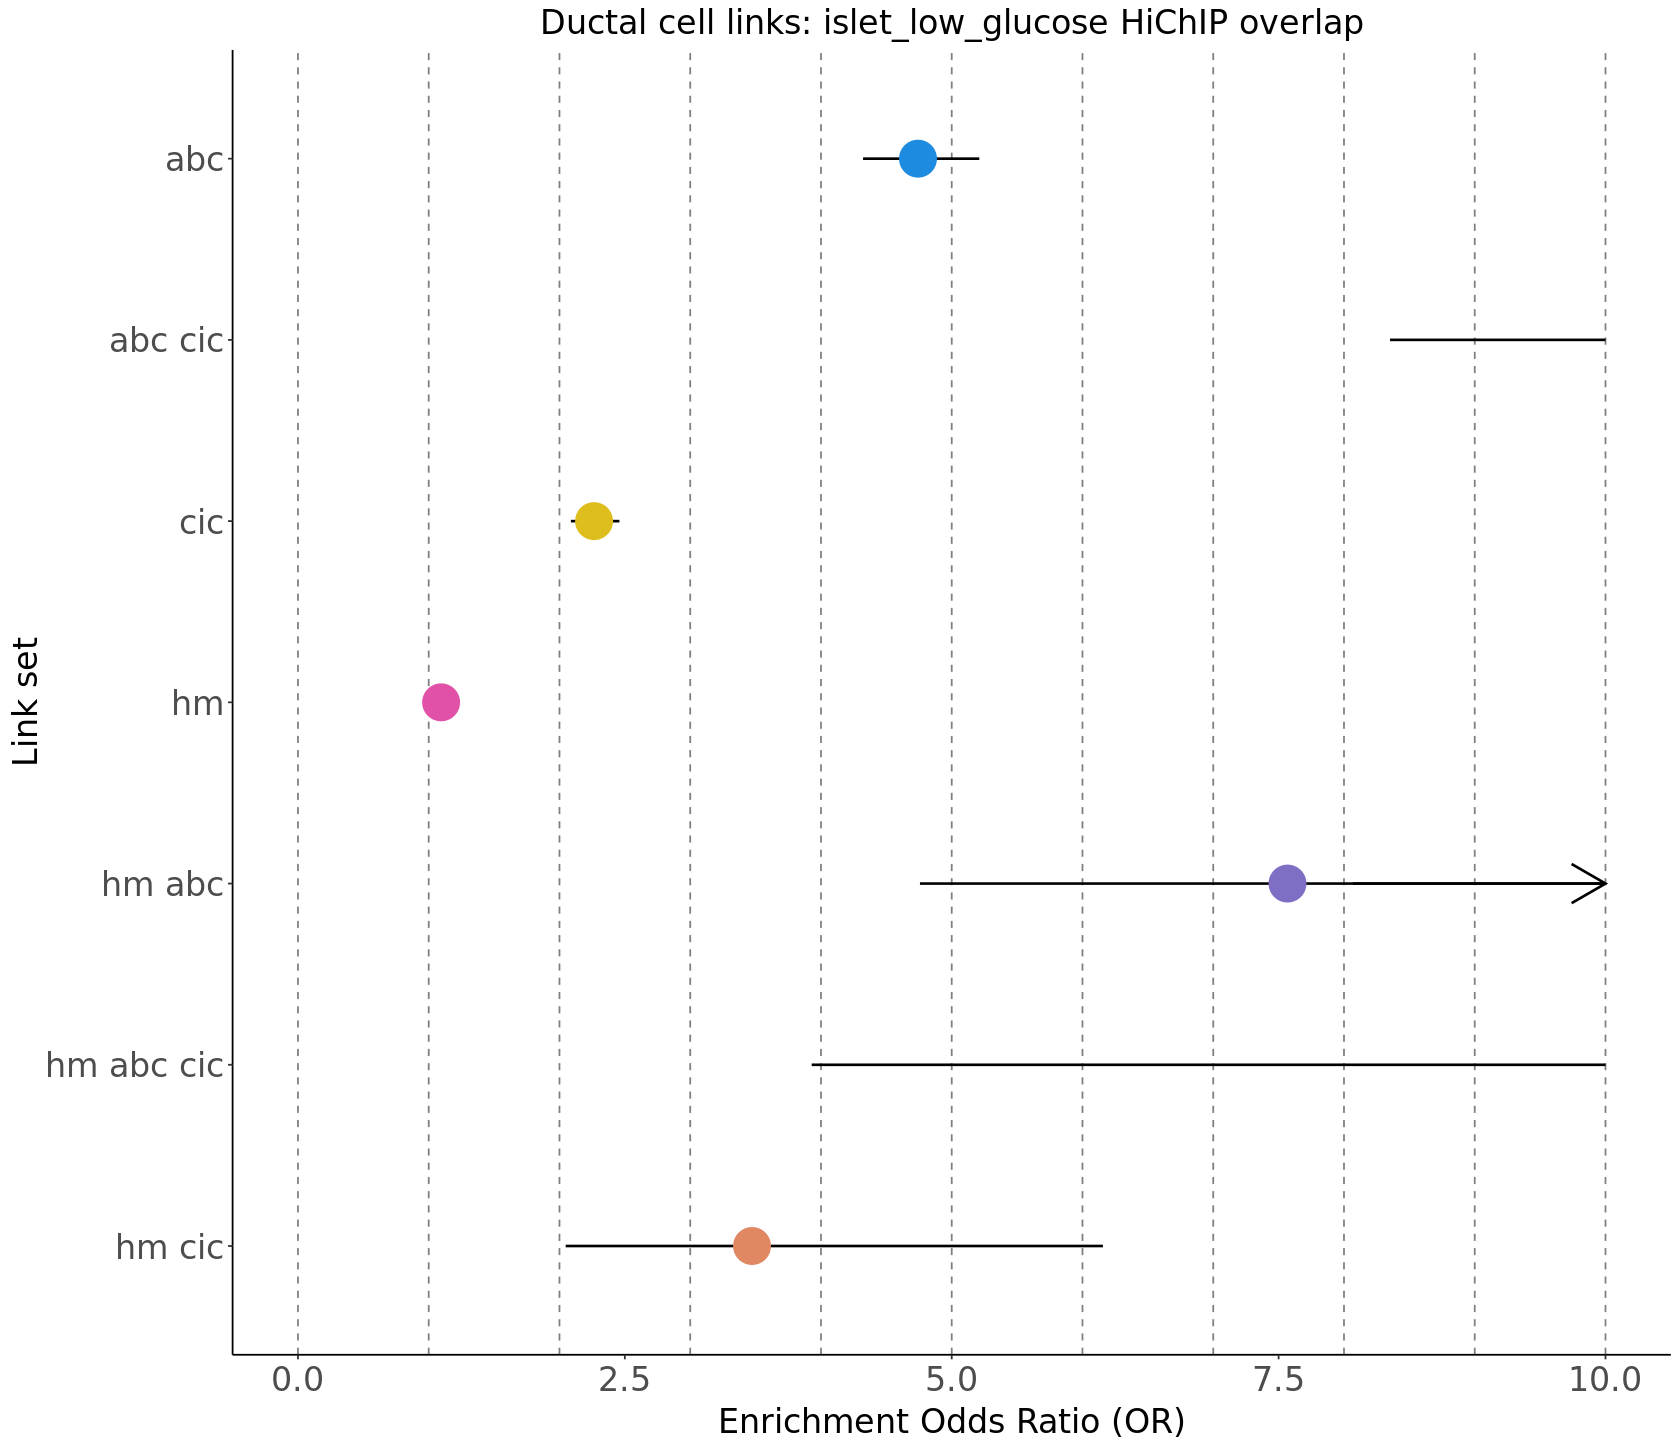

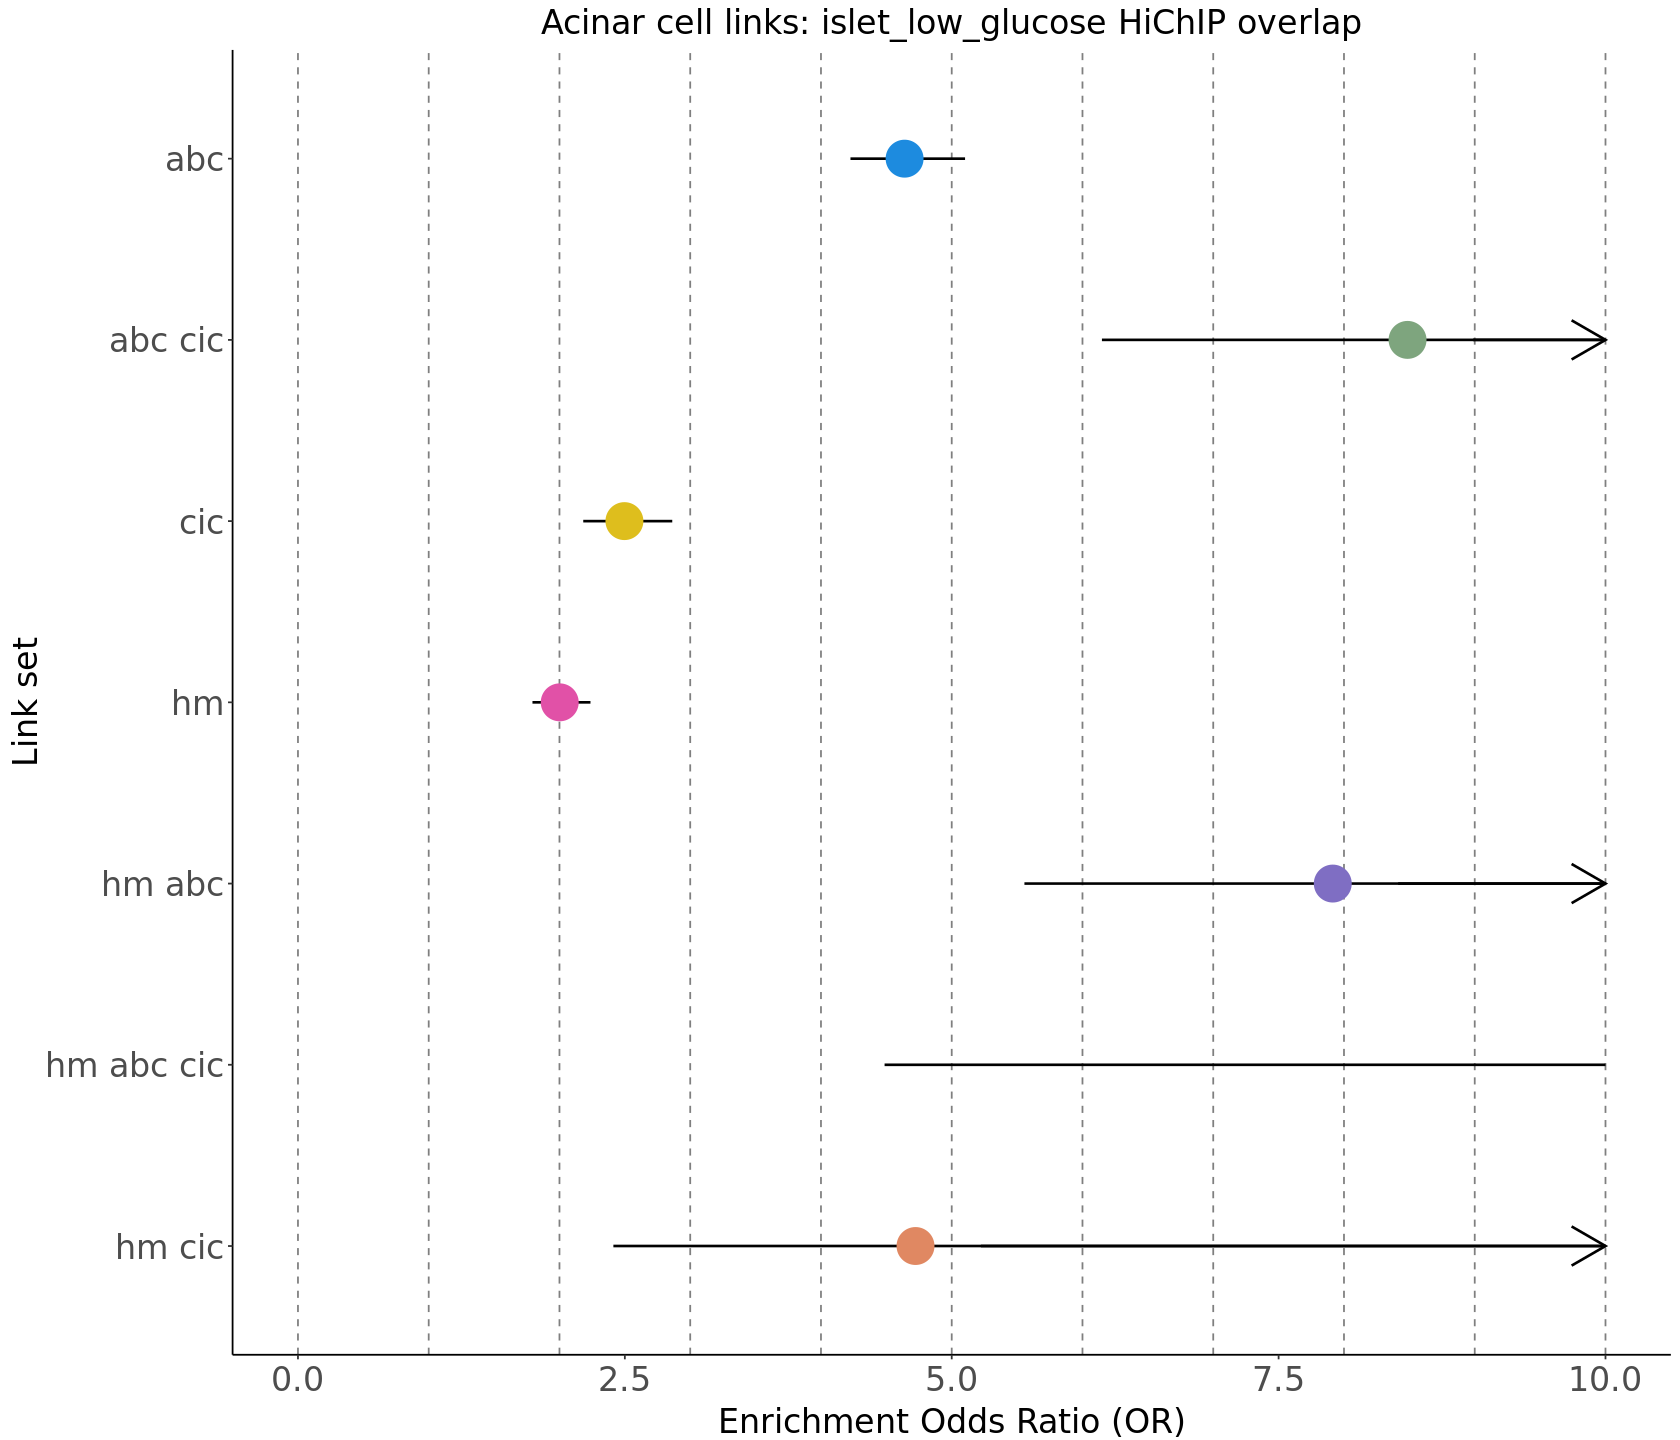

In [30]:
# Make plots by celltypes and/or methods
for (prefix in names(hichip_fps)){
    for (celltype in celltypes){
        results_fp <- file.path(fin_outdir2, sprintf('%s_%s_HiChIP_overlap.link_methods_overlap_comp.Fishers_enrichment.txt',celltype, prefix))
        title <- sprintf('%s cell links: %s HiChIP overlap', str_to_title(celltype), prefix)
        plot_enrichment_comp_fin2(results_fp, link_sets, 10, overlap_colors, title)
    }
}

# 4. Optional: print summary tables 

## 6a. Summarize # links at each distance threshold for different runs

In [5]:
# Most recent run of bins
outdir <- '/nfs/lab/hmummey/multiomic_islet/intermediates/230406_distance_thresholded_enrichment_bins_sigperm/230412_alt_distance_bins2'
distance_bins <- c('250000-1000000', '100000-250000', '50000-100000', '10000-50000', '0-10000') 
methods <- c('SMORES', 'ABC', 'Cicero')

In [11]:
celltype <- 'beta'
link_dir <- file.path(outdir, 'cut_links', celltype)

num_links <- list()
for (method in methods){
    prefix <- paste(celltype, method, 'sig', sep='_')
    for (distance_bin in distance_bins){
        fp <- file.path(link_dir, sprintf('%s_links_dist_bin_%s.bedpe', prefix, distance_bin))
        df <- read.table(fp, sep='\t')
        prefix2 <- paste(method, distance_bin, sep='_')
        num_links[[prefix2]] <- dim(df)[1]
    }
}

print(num_links)

$`SMORES_250000-1000000`
[1] 70852

$`SMORES_100000-250000`
[1] 20800

$`SMORES_50000-100000`
[1] 9861

$`SMORES_10000-50000`
[1] 10205

$`SMORES_0-10000`
[1] 2630

$`ABC_250000-1000000`
[1] 6869

$`ABC_100000-250000`
[1] 6262

$`ABC_50000-100000`
[1] 4882

$`ABC_10000-50000`
[1] 10433

$`ABC_0-10000`
[1] 7805

$`Cicero_250000-1000000`
[1] 18687

$`Cicero_100000-250000`
[1] 7300

$`Cicero_50000-100000`
[1] 2849

$`Cicero_10000-50000`
[1] 3549

$`Cicero_0-10000`
[1] 2404



In [16]:
#merge the num links with the #sig links tested and then get % (not 100% accurate tho bc I deleted eQTL intersect files)
results_fp <- file.path(outdir, 'eqtl_overlaps', 'outputs', 'eQTL_overlap_concordance.beta_method_dist_bin_comp.txt')
df <- read.table(results_fp, sep='\t')
row.names(df) == names(num_links)
df$total_links <- num_links
df[,c(7,1,2,3,4,5,6)]

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

total_links signif_links signif_genes_match_eQTL
SMORES_250000-1000000 70852       37855        246                    
SMORES_100000-250000  20800        8790        480                    
SMORES_50000-100000   9861         4436        555                    
SMORES_10000-50000    10205        5107        867                    
SMORES_0-10000        2630         1253        290                    
ABC_250000-1000000    6869         4986         52                    
ABC_100000-250000     6262         6224        211                    
ABC_50000-100000      4882         6337        334                    
ABC_10000-50000       10433        9063        893                    
ABC_0-10000           7805         2921        434                    
Cicero_250000-1000000 18687       23911         59                    
Cicero_100000-250000  7300         8046        177                    
Cicero_50000-100000   2849         3122        126                    
Cicero_10000-50000    3549         3663        329                    
Cicero_0-10000        2404         1372        206                    
                      percent_signif nonsignif_links nonsignif_genes_match_eQTL
SMORES_250000-1000000 0.006498481    37855           144                       
SMORES_100000-250000  0.054607509     8790           217                       
SMORES_50000-100000   0.125112714     4436           247                       
SMORES_10000-50000    0.169766986     5107           471                       
SMORES_0-10000        0.231444533     1253           157                       
ABC_250000-1000000    0.010429202     4986            12                       
ABC_100000-250000     0.033901028     6224           117                       
ABC_50000-100000      0.052706328     6337           276                       
ABC_10000-50000       0.098532495     9063           691                       
ABC_0-10000           0.148579254     2921           521                       
Cicero_250000-1000000 0.002467484    23911           117                       
Cicero_100000-250000  0.021998509     8046           219                       
Cicero_50000-100000   0.040358744     3122           202                       
Cicero_10000-50000    0.089817090     3663           432                       
Cicero_0-10000        0.150145773     1372           227                       
                      percent_nonsignif
SMORES_250000-1000000 0.003803989      
SMORES_100000-250000  0.024687144      
SMORES_50000-100000   0.055680794      
SMORES_10000-50000    0.092226356      
SMORES_0-10000        0.125299282      
ABC_250000-1000000    0.002406739      
ABC_100000-250000     0.018798201      
ABC_50000-100000      0.043553732      
ABC_10000-50000       0.076244069      
ABC_0-10000           0.178363574      
Cicero_250000-1000000 0.004893145      
Cicero_100000-250000  0.027218494      
Cicero_50000-100000   0.064702114      
Cicero_10000-50000    0.117936118      
Cicero_0-10000        0.165451895

In [17]:
# First set of bins
outdir <- '/nfs/lab/hmummey/multiomic_islet/intermediates/230406_distance_thresholded_enrichment_bins_sigperm'
distance_bins <- c('500000-1000000', '100000-500000', '50000-100000', '10000-50000', '0-10000')
methods <- c('SMORES', 'ABC', 'Cicero')

In [18]:
celltype <- 'beta'
link_dir <- file.path(outdir, 'cut_links', celltype)

num_links <- list()
for (method in methods){
    prefix <- paste(celltype, method, 'sig', sep='_')
    for (distance_bin in distance_bins){
        fp <- file.path(link_dir, sprintf('%s_links_dist_bin_%s.bedpe', prefix, distance_bin))
        df <- read.table(fp, sep='\t')
        prefix2 <- paste(method, distance_bin, sep='_')
        num_links[[prefix2]] <- dim(df)[1]
    }
}

print(num_links)

$`SMORES_500000-1000000`
[1] 44634

$`SMORES_100000-500000`
[1] 47018

$`SMORES_50000-100000`
[1] 9861

$`SMORES_10000-50000`
[1] 10205

$`SMORES_0-10000`
[1] 2630

$`ABC_500000-1000000`
[1] 3106

$`ABC_100000-500000`
[1] 10025

$`ABC_50000-100000`
[1] 4882

$`ABC_10000-50000`
[1] 10433

$`ABC_0-10000`
[1] 7805

$`Cicero_500000-1000000`
[1] 8459

$`Cicero_100000-500000`
[1] 17528

$`Cicero_50000-100000`
[1] 2849

$`Cicero_10000-50000`
[1] 3549

$`Cicero_0-10000`
[1] 2404



In [19]:
#merge the num links with the #sig links tested and then get % (not 100% accurate tho bc I deleted eQTL intersect files)
results_fp <- file.path(outdir, 'eqtl_overlaps', 'outputs', 'eQTL_overlap_concordance.beta_method_dist_bin_comp.txt')
df <- read.table(results_fp, sep='\t')
row.names(df) == names(num_links)
df$total_links <- num_links
df[,c(7,1,2,3,4,5,6)]

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

total_links signif_links signif_genes_match_eQTL
SMORES_500000-1000000 44634       25504         50                    
SMORES_100000-500000  47018       21141        676                    
SMORES_50000-100000   9861         4436        555                    
SMORES_10000-50000    10205        5107        867                    
SMORES_0-10000        2630         1253        290                    
ABC_500000-1000000    3106         1865         11                    
ABC_100000-500000     10025        9345        252                    
ABC_50000-100000      4882         6337        334                    
ABC_10000-50000       10433        9063        895                    
ABC_0-10000           7805         2921        432                    
Cicero_500000-1000000 8459         8822         32                    
Cicero_100000-500000  17528       23135        204                    
Cicero_50000-100000   2849         3122        126                    
Cicero_10000-50000    3549         3663        329                    
Cicero_0-10000        2404         1372        206                    
                      percent_signif nonsignif_links nonsignif_genes_match_eQTL
SMORES_500000-1000000 0.001960477    25504            58                       
SMORES_100000-500000  0.031975782    21141           293                       
SMORES_50000-100000   0.125112714     4436           244                       
SMORES_10000-50000    0.169766986     5107           471                       
SMORES_0-10000        0.231444533     1253           158                       
ABC_500000-1000000    0.005898123     1865             3                       
ABC_100000-500000     0.026966292     9345            92                       
ABC_50000-100000      0.052706328     6337           277                       
ABC_10000-50000       0.098753172     9063           691                       
ABC_0-10000           0.147894557     2921           521                       
Cicero_500000-1000000 0.003627295     8822            19                       
Cicero_100000-500000  0.008817809    23135           346                       
Cicero_50000-100000   0.040358744     3122           204                       
Cicero_10000-50000    0.089817090     3663           432                       
Cicero_0-10000        0.150145773     1372           225                       
                      percent_nonsignif
SMORES_500000-1000000 0.002274153      
SMORES_100000-500000  0.013859325      
SMORES_50000-100000   0.055004509      
SMORES_10000-50000    0.092226356      
SMORES_0-10000        0.126097366      
ABC_500000-1000000    0.001608579      
ABC_100000-500000     0.009844837      
ABC_50000-100000      0.043711535      
ABC_10000-50000       0.076244069      
ABC_0-10000           0.178363574      
Cicero_500000-1000000 0.002153707      
Cicero_100000-500000  0.014955695      
Cicero_50000-100000   0.065342729      
Cicero_10000-50000    0.117936118      
Cicero_0-10000        0.163994169

## 6a. Summarize # links concordant with an eQTL

### 3 Method sets

In [51]:
celltype <- 'beta'
eqtl_outdir1 <- file.path(outdir, 'eqtl_overlaps', 'outputs')
out_fp1 <- file.path(eqtl_outdir1, sprintf('eQTL_overlap_concordance.%s_method_dist_bin_comp.txt', celltype))

df1 <- read.table(out_fp1, sep='\t', header=TRUE)
separate_id <- function(id){
    indices <- unlist(gregexpr('_', id))
    fin_index <- indices[length(indices)]
    method <- substr(id, 1, fin_index-1)
    dist <- substr(id, fin_index+1, nchar(id))
    return(c(method,dist))
}
sep_ids <- unlist(lapply(row.names(df1), separate_id))
df1$method <- sep_ids[c(TRUE,FALSE)]
df1$dist_bin <- sep_ids[c(FALSE,TRUE)]
df1$dist_bin <- factor(df1$dist_bin, levels=rev(distance_bins))
df1[order(df1$method, df1$dist_bin),seq(6)]

signif_links signif_genes_match_eQTL percent_signif
ABC_0-10000            2921        432                     0.147894557   
ABC_10000-50000        9063        895                     0.098753172   
ABC_50000-100000       6337        334                     0.052706328   
ABC_100000-500000      9345        252                     0.026966292   
ABC_500000-1000000     1865         11                     0.005898123   
Cicero_0-10000         1372        206                     0.150145773   
Cicero_10000-50000     3663        329                     0.089817090   
Cicero_50000-100000    3122        126                     0.040358744   
Cicero_100000-500000  23135        204                     0.008817809   
Cicero_500000-1000000  8822         32                     0.003627295   
SMORES_0-10000         1253        290                     0.231444533   
SMORES_10000-50000     5107        867                     0.169766986   
SMORES_50000-100000    4436        555                     0.125112714   
SMORES_100000-500000  21141        676                     0.031975782   
SMORES_500000-1000000 25504         50                     0.001960477   
                      nonsignif_links nonsignif_genes_match_eQTL
ABC_0-10000            2921           521                       
ABC_10000-50000        9063           691                       
ABC_50000-100000       6337           277                       
ABC_100000-500000      9345            92                       
ABC_500000-1000000     1865             3                       
Cicero_0-10000         1372           225                       
Cicero_10000-50000     3663           432                       
Cicero_50000-100000    3122           204                       
Cicero_100000-500000  23135           346                       
Cicero_500000-1000000  8822            19                       
SMORES_0-10000         1253           158                       
SMORES_10000-50000     5107           471                       
SMORES_50000-100000    4436           244                       
SMORES_100000-500000  21141           293                       
SMORES_500000-1000000 25504            58                       
                      percent_nonsignif
ABC_0-10000           0.178363574      
ABC_10000-50000       0.076244069      
ABC_50000-100000      0.043711535      
ABC_100000-500000     0.009844837      
ABC_500000-1000000    0.001608579      
Cicero_0-10000        0.163994169      
Cicero_10000-50000    0.117936118      
Cicero_50000-100000   0.065342729      
Cicero_100000-500000  0.014955695      
Cicero_500000-1000000 0.002153707      
SMORES_0-10000        0.126097366      
SMORES_10000-50000    0.092226356      
SMORES_50000-100000   0.055004509      
SMORES_100000-500000  0.013859325      
SMORES_500000-1000000 0.002274153

### 3 Method overlap sets

In [52]:
celltype <- 'beta'
eqtl_outdir1 <- file.path(outdir, 'eqtl_overlaps_overlap_sets', 'outputs')
out_fp1 <- file.path(eqtl_outdir1, sprintf('eQTL_overlap_concordance.%s_method_dist_bin_comp.txt', celltype))

df1 <- read.table(out_fp1, sep='\t', header=TRUE)
separate_id <- function(id){
    indices <- unlist(gregexpr('_', id))
    fin_index <- indices[length(indices)]
    method <- substr(id, 1, fin_index-1)
    dist <- substr(id, fin_index+1, nchar(id))
    return(c(method,dist))
}
sep_ids <- unlist(lapply(row.names(df1), separate_id))
df1$method <- sep_ids[c(TRUE,FALSE)]
df1$dist_bin <- sep_ids[c(FALSE,TRUE)]
df1$dist_bin <- factor(df1$dist_bin, levels=rev(distance_bins))
df1[order(df1$method, df1$dist_bin),seq(6)]

signif_links signif_genes_match_eQTL percent_signif
abc_0-10000                4617         584                    0.126489062   
abc_10000-50000            7725         703                    0.091003236   
abc_50000-100000           4736         210                    0.044341216   
abc_100000-500000          7717         179                    0.023195542   
abc_500000-1000000         1673           7                    0.004184100   
abc_cic_0-10000             644          87                    0.135093168   
abc_cic_10000-50000        1361         112                    0.082292432   
abc_cic_50000-100000        831          45                    0.054151625   
abc_cic_100000-500000      1006          17                    0.016898608   
abc_cic_500000-1000000       51           0                    0.000000000   
cic_0-10000                 462          62                    0.134199134   
cic_10000-50000            1966         162                    0.082400814   
cic_50000-100000           1941          47                    0.024214323   
cic_100000-500000         20665         169                    0.008178079   
cic_500000-1000000         8232          28                    0.003401361   
hm_0-10000                 4035        1074                    0.266171004   
hm_10000-50000             5321         823                    0.154670175   
hm_50000-100000            5375         570                    0.106046512   
hm_100000-500000          31399         792                    0.025223733   
hm_500000-1000000         39221          75                    0.001912241   
hm_abc_0-10000              724         177                    0.244475138   
hm_abc_10000-50000         1323         194                    0.146636432   
hm_abc_50000-100000         663          74                    0.111613876   
hm_abc_100000-500000        548          56                    0.102189781   
hm_abc_500000-1000000       126           3                    0.023809524   
hm_abc_cic_0-10000          166          55                    0.331325301   
hm_abc_cic_10000-50000      188          30                    0.159574468   
hm_abc_cic_50000-100000      94           5                    0.053191489   
hm_abc_cic_100000-500000     72           1                    0.013888889   
hm_abc_cic_500000-1000000     8           0                    0.000000000   
hm_cic_0-10000               50           2                    0.040000000   
hm_cic_10000-50000          199          22                    0.110552764   
hm_cic_50000-100000         245          32                    0.130612245   
hm_cic_100000-500000       1391          17                    0.012221423   
hm_cic_500000-1000000       542           4                    0.007380074   
                          nonsignif_links nonsignif_genes_match_eQTL
abc_0-10000                4617           799                       
abc_10000-50000            7725           661                       
abc_50000-100000           4736           235                       
abc_100000-500000          7717            92                       
abc_500000-1000000         1673             3                       
abc_cic_0-10000             644           107                       
abc_cic_10000-50000        1361           117                       
abc_cic_50000-100000        831            41                       
abc_cic_100000-500000      1006            12                       
abc_cic_500000-1000000       51             0                       
cic_0-10000                 462            78                       
cic_10000-50000            1966           170                       
cic_50000-100000           1941            99                       
cic_100000-500000         20665           246                       
cic_500000-1000000         8232            15                       
hm_0-10000                 4035           631                       
hm_10000-50000             5321           444